# Residential Load Forecasting

## Data Preprocessing

### Raw Data 
* Location: Austin, TX
* Dates: 2016-01-01 to 2017-06-30
* Weather: Weather Underground. 
 * Link: https://www.wunderground.com/
 * Data resolution: ~ 1 hour
 * Access: open
* Energy: Pecan Street. 
 * Link: http://www.pecanstreet.org/
 * Data resolution: 1 minute
 * Access: universities
    

#### Utility functions to interpolate and resample raw data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt      
%matplotlib inline

def resampling(data, period):
	rule = str(period) + 'T'
	dataOut = data.resample(rule).mean()
	#print(dataOut.head())
	return dataOut

def interpolate(data):
	# resample to 1 minute data
	data = data.resample('T', how='mean')
	dataOut = data.interpolate(method='time')
	return dataOut

#### Weather Data

                      hum  tempC
datetime                        
2017-07-02 19:51:00  47.0   33.9
2017-07-02 20:51:00  55.0   32.2
2017-07-02 21:51:00  63.0   30.6
2017-07-02 22:51:00  65.0   29.4
2017-07-02 23:51:00  67.0   28.3


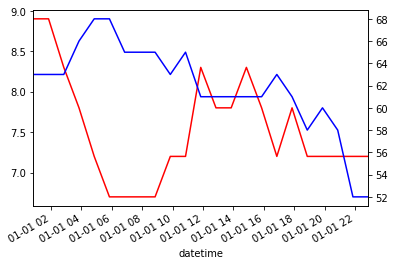

In [2]:
filenameWeather = "data/weather.csv"

# load raw data
# weatherRaw = pd.read_csv(filenameWeather, index_col="datetime")
weatherRaw = pd.read_csv(filenameWeather)
# convert to Series
weatherRaw['datetime'] = pd.to_datetime(weatherRaw['datetime'])
weatherRaw.index = weatherRaw['datetime']
del weatherRaw['datetime']
print(weatherRaw.tail())

# plot raw data
weatherRaw.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['tempC'].plot(style='r')
weatherRaw.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['hum'].plot(secondary_y=True, style='b')


/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


                           hum      tempC
datetime                                 
2017-07-02 19:00:00  45.606667  34.509167
2017-07-02 20:00:00  52.133333  32.810167
2017-07-02 21:00:00  60.073333  31.177333
2017-07-02 22:00:00  64.283333  29.831000
2017-07-02 23:00:00  66.150000  28.767500


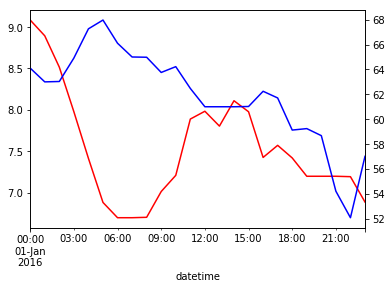

In [3]:
# 1 minute data
weatherData1 = interpolate(weatherRaw)
# 60 minute data
weatherData60 = resampling(weatherData1, 60)
print(weatherData60.tail())

# plot resampled data
weatherData60.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['tempC'].plot(style='r')
weatherData60.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

#### Energy Data

In [4]:
# load raw energy data
filenameEnergy = "data/dataport-export adding houses 1.csv"

energyRaw = pd.read_csv(filenameEnergy)
print(energyRaw.head(10))

              localminute  dataid    use    gen
0  2015-12-23 00:00:00-06     661  0.519 -0.008
1  2015-12-23 00:00:00-06    1642  0.316 -0.005
2  2015-12-23 00:00:00-06    1801  0.450 -0.009
3  2015-12-23 00:00:00-06     744  0.394 -0.008
4  2015-12-23 00:00:00-06    1192  0.168 -0.004
5  2015-12-23 00:00:00-06    1718  0.452 -0.002
6  2015-12-23 00:00:00-06    1800  0.514 -0.012
7  2015-12-23 00:01:00-06     661  0.520 -0.008
8  2015-12-23 00:01:00-06    1642  0.316 -0.005
9  2015-12-23 00:01:00-06    1801  0.451 -0.009


In [5]:
# change column name to share same name with weather data
energyData = energyRaw.rename(index=str, columns={"localminute" : "datetime"})

# convert to Series
energyData['datetime'] = pd.to_datetime(energyData['datetime'])
# shift 6 hours data to comply with weather data format
energyData["datetime"] -= pd.to_timedelta(6,unit='h')
energyData.index = energyData['datetime']
del energyData['datetime']
# delete generation data: not used
del energyData['gen']

In [6]:
# select by houseID
dataIDs = energyData.dataid.unique()
print("Households IDs")
print(dataIDs)
energyData1 = dict()
energyData60 = dict()

for id in dataIDs:
    energyData1[id] = energyData.loc[energyData['dataid'] == id]
    del energyData1[id]['dataid']

    energyData60[id] = resampling(energyData1[id], 60)

Households IDs
[ 661 1642 1801  744 1192 1718 1800 1185]


Raw Data: 1 min resolution
                       use
datetime                  
2015-12-23 00:00:00  0.316
2015-12-23 00:01:00  0.316
2015-12-23 00:02:00  0.314
2015-12-23 00:03:00  0.314
2015-12-23 00:04:00  0.313
Raw Data: 60 min resolution
                          use
datetime                     
2015-12-23 00:00:00  0.308033
2015-12-23 01:00:00  0.308367
2015-12-23 02:00:00  0.308900
2015-12-23 03:00:00  0.304700
2015-12-23 04:00:00  0.260550


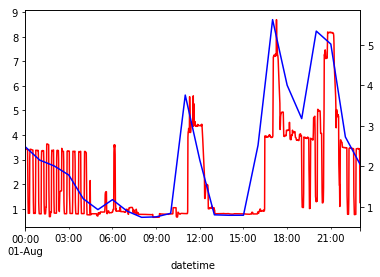

In [7]:
# for this experiment we select the first household
idHouse = dataIDs[1]

# raw data
print("Raw Data: 1 min resolution")
print(energyData1[idHouse].head())
energyData1[idHouse].loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['use'].plot(style='r')
# resampled data
print("Raw Data: 60 min resolution")
print(energyData60[idHouse].head())
energyData60[idHouse].loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['use'].plot(secondary_y=True, style='b')

### Data Exploration

In [8]:
# Weather summary statistics
weatherData60.loc['2016-01-01':'2016-12-31'].describe()

,hum,tempC
count,8784.000000,8784.000000
mean,68.610783,21.364618
std,19.899777,7.955016
min,15.378333,-4.978000
25%,53.233750,16.190333
50%,71.195833,22.300605
75%,85.958103,26.874417
max,100.000000,39.210833


In [9]:
# Energy summary statistics
energyData60[idHouse].loc['2016-01-01':'2016-12-31'].describe()

,use
count,8784.000000
mean,1.185386
std,1.201346
min,0.153667
25%,0.381329
50%,0.728233
75%,1.481175
max,8.385000


### Correlations between Variables and Target

In [10]:
from scipy.stats import pearsonr
from datetime import date, datetime, timedelta

# function to calculate Pearson Correlation Coefficient for 24 hours timeseries
def calculatePearsonCorr(vectors_1, vectors_2):
    
    pearsonCoef = []
    days = vectors_1.shape[0]
    # print(days)
    for day in range(days):
        x = vectors_1[day,:].reshape(-1)
        y = vectors_2[day,:].reshape(-1)
        
        # calculate coefficient for a single day
        pears_coef = pearsonr(x, y)[0]
        pearsonCoef.append(pears_coef)
        
        
    # print(pearsonCoef)
    return pearsonCoef

#### Correlation with Historical Power Consumption

Mean Pearson Correlation Coefficient is 0.347711


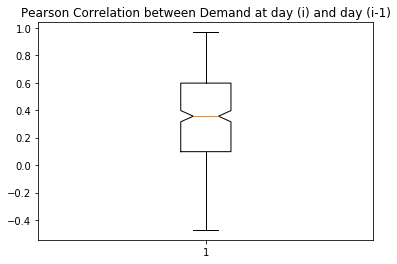

In [11]:
# plot boxplot of pearson correaltion coefficient for 365 days 
# between the target day and the previous day
startDate = date(2016, 1, 1)
endDate = date(2016, 12, 31)

start_1 = startDate.strftime('%Y-%m-%d')
end_1 = endDate.strftime('%Y-%m-%d')
start_2 = (startDate-timedelta(days=1)).strftime('%Y-%m-%d')
end_2 = (endDate-timedelta(days=1)).strftime('%Y-%m-%d')

vectors_1 = energyData60[idHouse].loc[start_1:end_1].as_matrix().reshape(-1, 24)
vectors_2 = energyData60[idHouse].loc[start_2:end_2].as_matrix().reshape(-1, 24)

pearsonCoef = calculatePearsonCorr(vectors_1, vectors_2)
print("Mean Pearson Correlation Coefficient is %f" %(np.mean(pearsonCoef)))

plt.figure()
plt.boxplot(pearsonCoef, 1)
plt.title('Pearson Correlation between Demand at day (i) and day (i-1)')

Mean Pearson Correlation Coefficient is 0.295798


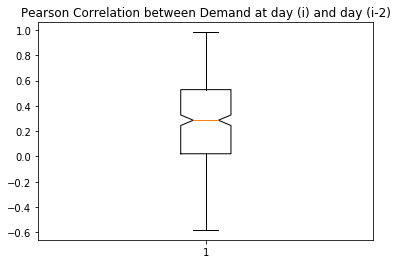

In [12]:
# plot boxplot of pearson correaltion coefficient for 365 days 
# between the target day and 2 days before
startDate = date(2016, 1, 1)
endDate = date(2016, 12, 31)

start_1 = startDate.strftime('%Y-%m-%d')
end_1 = endDate.strftime('%Y-%m-%d')
start_2 = (startDate-timedelta(days=2)).strftime('%Y-%m-%d')
end_2 = (endDate-timedelta(days=2)).strftime('%Y-%m-%d')

vectors_1 = energyData60[idHouse].loc[start_1:end_1].as_matrix().reshape(-1, 24)
vectors_2 = energyData60[idHouse].loc[start_2:end_2].as_matrix().reshape(-1, 24)

pearsonCoef = calculatePearsonCorr(vectors_1, vectors_2)
print("Mean Pearson Correlation Coefficient is %f" %(np.mean(pearsonCoef)))

plt.figure()
plt.boxplot(pearsonCoef, 1)
plt.title('Pearson Correlation between Demand at day (i) and day (i-2)')

Mean Pearson Correlation Coefficient is 0.346761


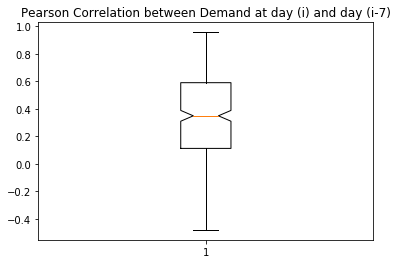

In [13]:
# plot boxplot of pearson correaltion coefficient for 365 days 
# between the target day and the same day one week ago
startDate = date(2016, 1, 1)
endDate = date(2016, 12, 31)

start_1 = startDate.strftime('%Y-%m-%d')
end_1 = endDate.strftime('%Y-%m-%d')
start_2 = (startDate-timedelta(days=7)).strftime('%Y-%m-%d')
end_2 = (endDate-timedelta(days=7)).strftime('%Y-%m-%d')

vectors_1 = energyData60[idHouse].loc[start_1:end_1].as_matrix().reshape(-1, 24)
vectors_2 = energyData60[idHouse].loc[start_2:end_2].as_matrix().reshape(-1, 24)

pearsonCoef = calculatePearsonCorr(vectors_1, vectors_2)
print("Mean Pearson Correlation Coefficient is %f" %(np.mean(pearsonCoef)))

plt.figure()
plt.boxplot(pearsonCoef, 1)
plt.title('Pearson Correlation between Demand at day (i) and day (i-7)')

#### Correlation with Weather

Mean Pearson Correlation Coefficient is 0.272360


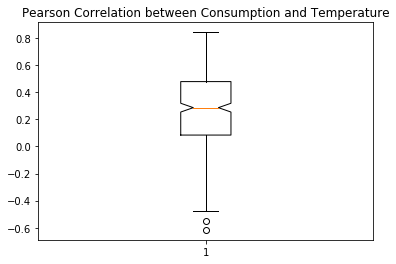

In [14]:
# plot boxplot of pearson correaltion coefficient for 365 days 
# between the target day and the same day's Temperature
startDate = date(2016, 1, 1)
endDate = date(2016, 12, 31)

start = startDate.strftime('%Y-%m-%d')
end = endDate.strftime('%Y-%m-%d')

vectors_1 = energyData60[idHouse].loc[start:end].as_matrix().reshape(-1, 24)
vectors_2 = weatherData60.loc[start:end]['tempC'].as_matrix().reshape(-1, 24)

pearsonCoef = calculatePearsonCorr(vectors_1, vectors_2)
print("Mean Pearson Correlation Coefficient is %f" %(np.mean(pearsonCoef)))

plt.figure()
plt.boxplot(pearsonCoef, 1)
plt.title('Pearson Correlation between Consumption and Temperature')

Mean Pearson Correlation Coefficient is -0.272405


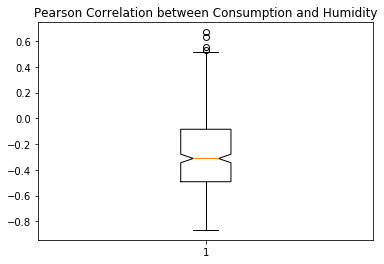

In [15]:
# plot boxplot of pearson correaltion coefficient for 365 days 
# between the target day and the same day's Humidity
startDate = date(2016, 1, 1)
endDate = date(2016, 12, 31)

start = startDate.strftime('%Y-%m-%d')
end = endDate.strftime('%Y-%m-%d')

vectors_1 = energyData60[idHouse].loc[start:end].as_matrix().reshape(-1, 24)
vectors_2 = weatherData60.loc[start:end]['hum'].as_matrix().reshape(-1, 24)

pearsonCoef = calculatePearsonCorr(vectors_1, vectors_2)
print("Mean Pearson Correlation Coefficient is %f" %(np.mean(pearsonCoef)))

plt.figure()
plt.boxplot(pearsonCoef, 1)
plt.title('Pearson Correlation between Consumption and Humidity')

### Load and Temperature Correlation through year

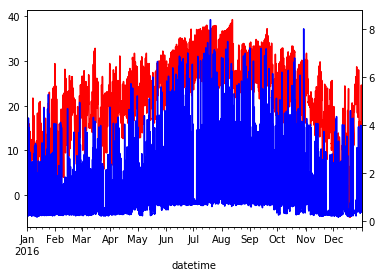

In [17]:
weatherData60.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']['tempC'].plot(style='r')
energyData60[idHouse].loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']['use'].plot(secondary_y=True, style='b')

/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=24).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=24).mean()
  after removing the cwd from sys.path.
/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=24).mean()
  """


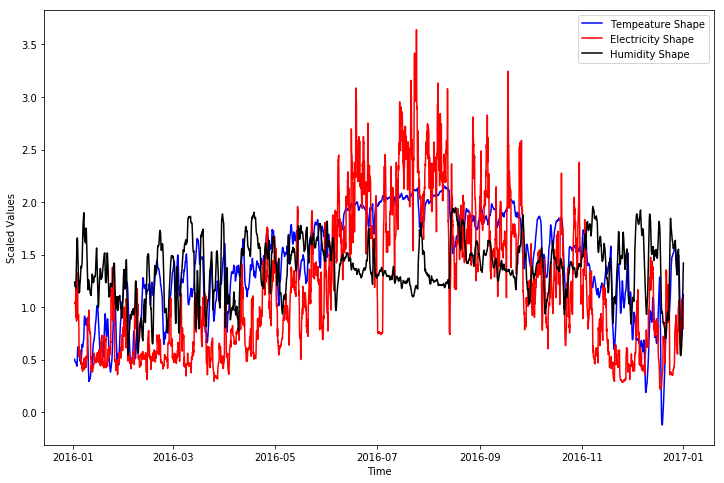

In [19]:
period = 24
#Determing rolling statistics
rolmean_temp = pd.rolling_mean(weatherData60.loc['2016-01-01':'2016-12-31']['tempC'], window=period)
rolmean_hum = pd.rolling_mean(weatherData60.loc['2016-01-01':'2016-12-31']['hum'], window=period)
rolmean_use = pd.rolling_mean(energyData60[idHouse].loc['2016-01-01':'2016-12-31']['use'], window=period)

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
plt.plot(rolmean_temp/15, color='blue',label='Tempeature Shape')
plt.plot(rolmean_use, color='red', label='Electricity Shape')
plt.plot(rolmean_hum/50, color='black', label = 'Humidity Shape')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.show()

### Load and Temperature Correlation through week

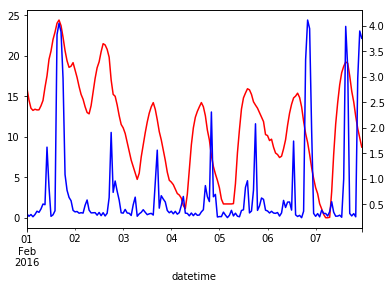

In [20]:
# winter week
weatherData60.loc['2016-02-01 00:00:00':'2016-02-7 23:00:00']['tempC'].plot(style='r')
energyData60[idHouse].loc['2016-02-01 00:00:00':'2016-02-07 23:00:00']['use'].plot(secondary_y=True, style='b')

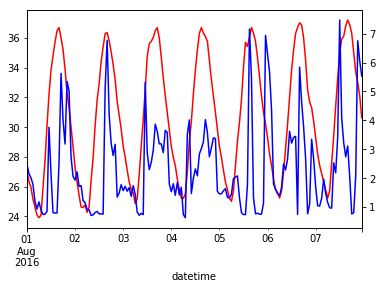

In [21]:
# summer week
weatherData60.loc['2016-08-01 00:00:00':'2016-08-7 23:00:00']['tempC'].plot(style='r', label='Temperature (C)')
energyData60[idHouse].loc['2016-08-01 00:00:00':'2016-08-07 23:00:00']['use'].plot(secondary_y=True, style='b', label='Consumption (kW)')

## Metrics
The metrics to evaluate the model are the Mean Square Error and the Mean Absolute Error.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluate_model(y_pred, y_test):
	mse = mean_squared_error(y_test, y_pred)
	mae = mean_absolute_error(y_test, y_pred)
	
	print("Mean Square Error: %f" % mse)
	print("Mean Absolute Error: %f" % mae)

## ARIMA Forecast Model

Use of AutoRegressive Integrated Moving Average (ARIMA) Model. In order to find the appropiate selection of parameters, the Box-Jenkins approach is used below. Following this procedure, the dataset is divided in two subsets: one for finding the right model and one for testing.


In [23]:
# divide data into training and testing
data_train = energyData60[idHouse].loc['2016-01-01':'2016-12-31']
data_test = energyData60[idHouse].loc['2017-01-01':'2017-06-30']

# data_train.to_csv("data/ARIMA_data_train.csv")
# data_test.to_csv("data/ARIMA_data_test.csv")

From the plots above we can observe some periodicity on the timeseries with period of 24 hours. However, the timeseries could have also seasonality effects over the year as shown in another plot above. In order to check those issues the following test of stationarity is performed.

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=24).mean()
  
/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=24).std()
  import sys


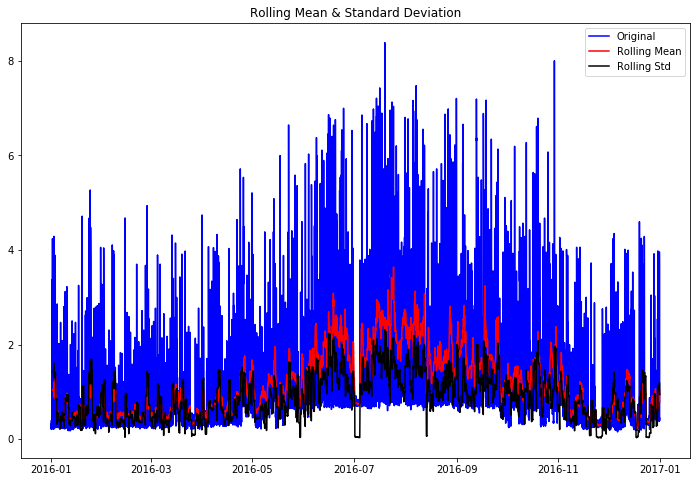

In [24]:
### Checking Stationarity and Seasonality
from statsmodels.tsa.stattools import adfuller

period = 24
#Determing rolling statistics
rolmean = pd.rolling_mean(data_train, window=period)
rolstd = pd.rolling_std(data_train, window=period)

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(data_train, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In order to be able to observe clearly the data, a week of data is selected so the concepts below can be better interpreted. Notice that the whole year of data is used to take decisions.

/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=24).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alberto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=24).std()
  after removing the cwd from sys.path.


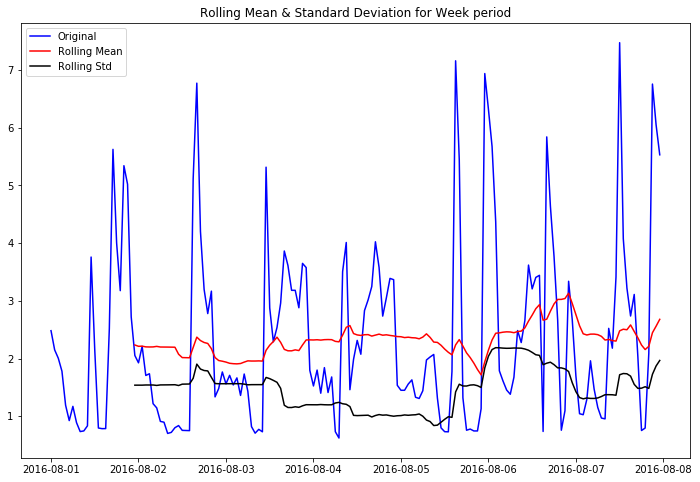

In [25]:
data_train_week = data_train.loc['2016-08-01 00:00:00':'2016-08-07 23:00:00']
#Determing rolling statistics
rolmean_week = pd.rolling_mean(data_train_week, window=period)
rolstd_week = pd.rolling_std(data_train_week, window=period)

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(data_train_week, color='blue',label='Original')
mean = plt.plot(rolmean_week, color='red', label='Rolling Mean')
std = plt.plot(rolstd_week, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for Week period')
plt.show()

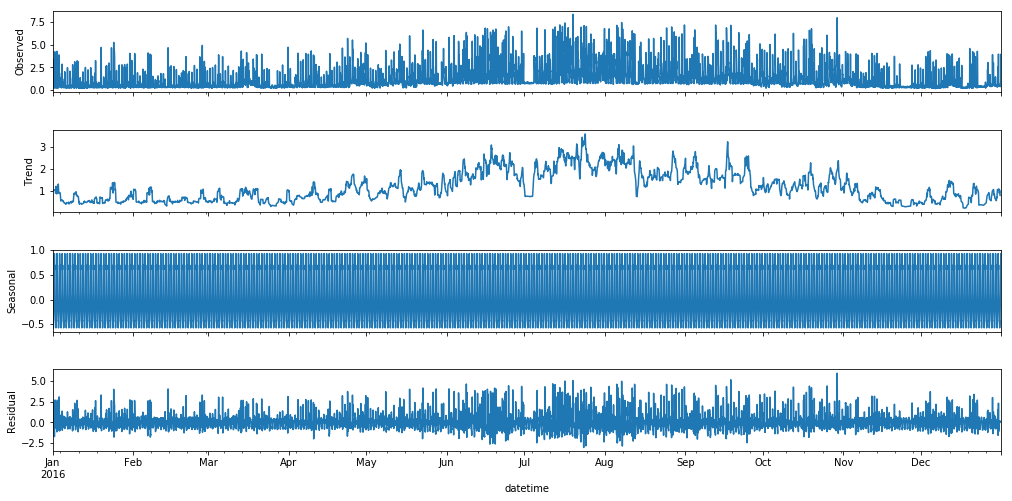

In [26]:
# checking annual seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_train, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

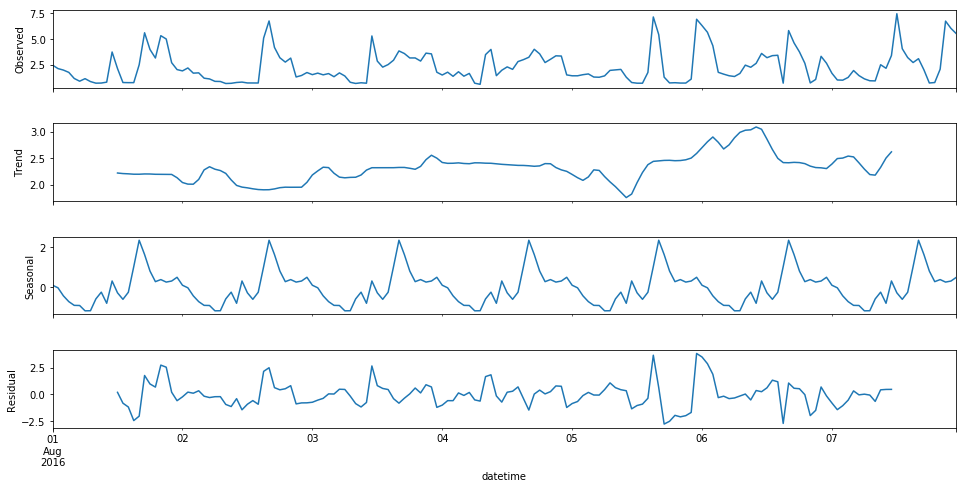

In [27]:
# checking weekly seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_train_week, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [28]:
#Perform Dickey-Fuller test:
data_train_array = data_train.as_matrix().reshape(-1)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(data_train_array, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -5.434701
p-value                           0.000003
#Lags Used                       32.000000
Number of Observations Used    8751.000000
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
Critical Value (1%)              -3.431097
dtype: float64


Because the test statistic value is lower than the critical values (for different interval of confidence). The null hypothesis (non-stationary timeseries) can be rejected and we can ensure that we are dealing with a stationary timeseries with 99% of confidence. 

Then, we are ready to try to fit an ARIMA(p,d,q) model. To do so, we need to find the model's parameters: p, d, q. The methodology suggest investigating the Auto-Correlation and Partial Auto-Correlation in the series.

"\nfrom statsmodels.tsa.stattools import acf, pacf\n\nlag_acf = acf(data_train_array, nlags=48)\nlag_pacf = pacf(data_train_array, nlags=48, method='ols')\n\nplt.subplot(121) \nplt.plot(lag_acf)\nplt.axhline(y=0,linestyle='--',color='gray')\nplt.axhline(y=-1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')\nplt.axhline(y=1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')\nplt.title('Autocorrelation Function')\n\n#Plot PACF:\nplt.subplot(122)\nplt.plot(lag_pacf)\nplt.axhline(y=0,linestyle='--',color='gray')\nplt.axhline(y=-1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')\nplt.axhline(y=1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')\nplt.title('Partial Autocorrelation Function')\nplt.tight_layout()\n"

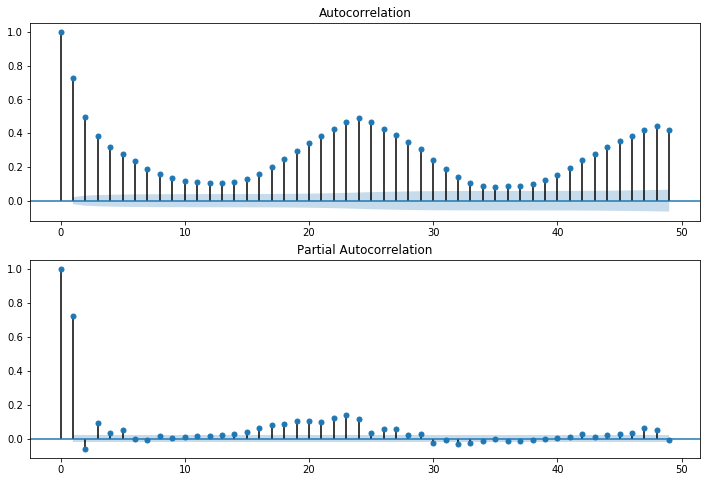

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
#Plot ACF: 
ax1 = fig.add_subplot(211)
fig = plot_acf(data_train_array, lags=49, ax=ax1)
#Plot PACF:
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_train_array, lags=49, ax=ax2)


'''
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(data_train_array, nlags=48)
lag_pacf = pacf(data_train_array, nlags=48, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_train_array)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
'''


In [33]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
p = 24
d = 0
q = 0
model = ARIMA(endog=data_train, order=(p, d, q))  

results_ARIMA = model.fit(disp=1, transparams=False) 
results_ARIMA.save("saved_models/arima_" +str(p)+"_"+str(d)+"_"+str(q)+".pkl")

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The 'predict' function of the ARIMA model in python has issues when applied Out-of-Sample datapoints. Therefore, the calculations of the predicted value are done manually by extracting the parameters of the fitted ARIMA model.

In [188]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    use   No. Observations:                 8784
Model:                    ARMA(24, 0)   Log Likelihood              -11727.842
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 31 Dec 2017   AIC                          23507.684
Time:                        19:10:54   BIC                          23691.782
Sample:                    01-01-2016   HQIC                         23570.404
                         - 12-31-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1822      0.017     71.484      0.000       1.150       1.215
ar.L1.use      0.3455      0.015     23.740      0.000       0.317       0.374
ar.L2.use     -0.0815      0.015     -5.381      0.000      -0.111      -0.052
ar.L3.use      0.0264      0.015      1.741      0.082      -0.003       0.056
ar.L4.use     -0.0149      0.015     -0.980      0.327      -0.045       0.015
ar.L5.use      0.0174      0.015      1.144      0.253      -0.012       0.047
ar.L6.use      0.0038      0.015      0.253      0.800      -0.026       0.034
ar.L7.use     -0.0104      0.015     -0.682      0.495      -0.040       0.019
ar.L8.use      0.0061      0.015      0.404      0.686      -0.024       0.036
ar.L9.use      0.0012      0.015      0.078      0.938      -0.029       0.031
ar.L10.use    -0.0025      0.015     -0.165      0.869      -0.032       0.027
ar.L11.use     0.0017      0.015      0.112      0.911      -0.028       0.031
ar.L12.use    -0.0012      0.015     -0.077      0.939      -0.031       0.029
ar.L13.use -3.542e-05      0.015     -0.002      0.998      -0.030       0.030
ar.L14.use    -0.0008      0.015     -0.051      0.960      -0.031       0.029
ar.L15.use    -0.0056      0.015     -0.366      0.715      -0.035       0.024
ar.L16.use     0.0006      0.015      0.040      0.968      -0.029       0.030
ar.L17.use     0.0048      0.015      0.315      0.752      -0.025       0.035
ar.L18.use     0.0033      0.015      0.218      0.828      -0.026       0.033
ar.L19.use     0.0046      0.015      0.304      0.761      -0.025       0.034
ar.L20.use     0.0195      0.015      1.281      0.200      -0.010       0.049
ar.L21.use     0.0054      0.015      0.358      0.720      -0.024       0.035
ar.L22.use     0.0145      0.015      0.957      0.339      -0.015       0.044
ar.L23.use     0.0112      0.015      0.739      0.460      -0.018       0.041
ar.L24.use     0.0576      0.013      4.572      0.000       0.033       0.082
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0817           -0.0000j            1.0817           -0.0000
AR.2             1.0478           -0.2907j            1.0874           -0.0431
AR.3             1.0478           +0.2907j            1.0874            0.0431
AR.4             0.9503           -0.5660j            1.1061           -0.0855
AR.5             0.9503           +0.5660j            1.1061            0.0855
AR.6             0.7906           -0.7941j            1.1205           -0.1253
AR.7             0.7906           +0.7941j            1.1205            0.1253
AR.8             0.5658           -0.9667j            1.1201           -0.1657
AR.9             0.5658           +0.9667j            1.1201            0.1657
AR

In [34]:
# get ARIMA coeficients
coef = results_ARIMA.arparams
print(coef)
# function to calculate prediction
def predictARIMA(history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat

[  3.45539543e-01  -8.14517194e-02   2.64216862e-02  -1.48771414e-02
   1.73596740e-02   3.84053717e-03  -1.03533953e-02   6.13586492e-03
   1.18085271e-03  -2.50465768e-03   1.69999514e-03  -1.16745989e-03
  -3.54172506e-05  -7.68463984e-04  -5.55473803e-03   6.11034631e-04
   4.79169598e-03   3.30867341e-03   4.62492039e-03   1.94591809e-02
   5.44220396e-03   1.45331244e-02   1.11819415e-02   5.75768170e-02]


In [35]:
start = date(2017, 1, 1)
end= date(2017, 6, 30)
# print(data_train.tail())
history = data_train.copy()

timestamp = datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
# print(timestamp)
test_pred = data_test.copy()
# print(data_test.head())

while start <= end:
    history_temp = history.copy()
    # print(history_temp.tail())
    # make predictions for each day
    for i in range(24):
        # print(i)
        yhat = predictARIMA(history_temp.as_matrix().reshape(-1))
        history_temp.set_value(index=timestamp, col='use', value=yhat)

        history.set_value(index=timestamp, col='use', value=data_test.loc[timestamp].get_value('use'))
        # history.append(data_test[timestamp])
        test_pred.loc[timestamp] = yhat
        timestamp += timedelta(seconds=3600)
        # print(timestamp)
    # print(history_temp.tail(24))
    # print(history.tail(24))
    # print(test_pred.head(24))
    # update day
    start += timedelta(days=1)
print(timestamp)


2017-07-01 00:00:00


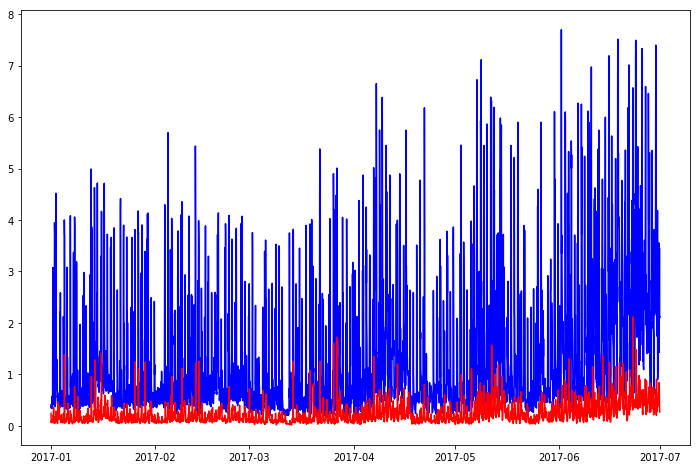

In [36]:
# plot train data real vs prediction
fig = plt.figure(figsize=(12, 8))
plt.plot(data_test, color='blue')
plt.plot(test_pred, color='red')

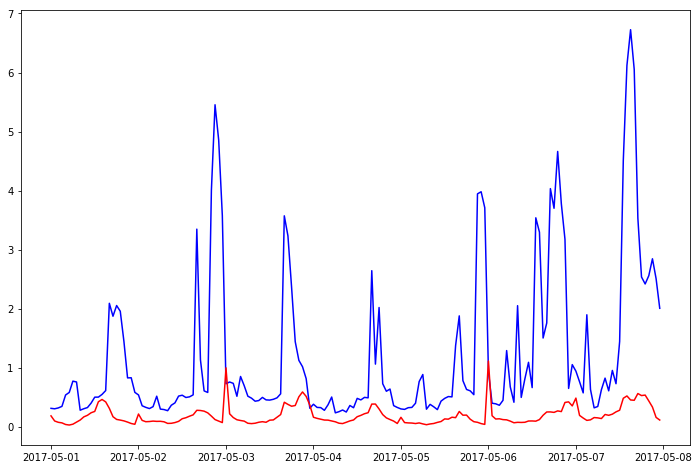

In [37]:
# plot train data real vs prediction for a week
fig = plt.figure(figsize=(12, 8))
plt.plot(data_test['2017-05-01':'2017-05-07'], color='blue')
plt.plot(test_pred['2017-05-01':'2017-05-07'], color='red')

### Model Evaluation

In [38]:
evaluate_model(test_pred.as_matrix().reshape(-1), data_test.as_matrix().reshape(-1))

Mean Square Error: 2.469624
Mean Absolute Error: 1.044264


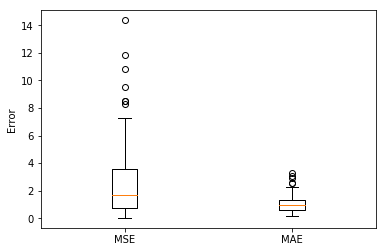

In [40]:
# error distribution across different days
y_test_pred_day = test_pred.as_matrix().reshape(-1, 24)
y_test_day = data_test.as_matrix().reshape(-1, 24)

mse_test = []
mae_test = []
for i in range(y_test_day.shape[0]):
    mse_test.append(mean_squared_error(y_test_day[i,:], y_test_pred_day[i,:]))
    mae_test.append(mean_absolute_error(y_test_day[i,:], y_test_pred_day[i,:]))
error_test = [mse_test, mae_test]
plt.figure()
plt.boxplot(error_test)
plt.xticks([1, 2], ['MSE', 'MAE'])
plt.ylabel('Error')


## LSTM Model

In this model we are able to consider weather as well as another features that consider human behaviour patterns such as distinguishing between weekdays and weekends. 

In order to train the Recurrent Neural Network we need to appropieately transform the data that is fed to it.

In this case we consider the historical energy consumption 1, 2 and 7 days before the target day as well as temperature and humidity.

In [42]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense

Using TensorFlow backend.


In [206]:
# days selected for each month to use as validation set.
val_days = [1, 2, 3, 4, 5, 6, 7]

# days that the network is using to predict. 1 day, 2 days ago and the same day last week (7 days).
days = [1, 2, 7]

# chunk data in days
weatherData60 = weatherData60.loc['2016-01-01':'2017-06-30']

startDate = date(2016, 1, 1)
endDate = date(2017, 6, 30)

resol = 60
n_features = 5

x_train = np.empty((1, 1440//resol, n_features))
y_train = np.empty((1, 1440//resol))

x_val = np.empty((1, 1440//resol, n_features))
y_val = np.empty((1, 1440//resol))

countTrain = 1
countTest = 1
countVal = 1

while startDate <= endDate:
    weekday = startDate.weekday()

    startDateSt = startDate.strftime('%Y-%m-%d')
    startDatetimeSt = startDateSt + ' 00:00:00'
    endDatetimeSt = startDateSt + ' 23:00:00'
    x = weatherData60.loc[startDatetimeSt:endDatetimeSt]
    x = x.reset_index(drop=True)

    # energy consumption
    for day in days:
        # previous datys consumption
        date_past = startDate - timedelta(days=day)
        date_past = date_past.strftime('%Y-%m-%d')
        startDatetimeSt = date_past + ' 00:00:00'
        endDatetimeSt = date_past + ' 23:00:00'
        x_i = energyData60[idHouse].loc[startDatetimeSt:endDatetimeSt]
        '''
        x_i = pd.DataFrame([x_i])
        '''
        x_i = x_i.reset_index(drop=True)
        column_name = 'day_' + str(day)
        x_i = pd.DataFrame(x_i['use'])
        x[column_name] = x_i

    x = x.as_matrix()
    # print(x.shape)
    x = x.reshape(1, x.shape[0], x.shape[1])
    # print(x.shape)

    # output on this day
    y = energyData60[idHouse].loc[startDatetimeSt:endDatetimeSt]
    y = y.reset_index(drop=True)
    y = pd.DataFrame(y['use']).as_matrix()
    # print(y.shape)
    y = y.reshape(1, y.shape[0])
    # print(y.shape)

    if startDate < date(2017, 1, 1):
        day = startDate.day
        if int(day) in val_days:
            # validation set
            if countVal == 1:
                x_val = x
                y_val = y
                countVal += 1
            else:
                x_val = np.concatenate((x_val, x), axis=0)
                y_val = np.concatenate((y_val, y), axis=0)
        else:
            # training set
            if countTrain == 1:
                x_train = x
                y_train = y
                countTrain += 1
            else:
                x_train = np.concatenate((x_train, x), axis=0)
                y_train = np.concatenate((y_train, y), axis=0)
    elif startDate < date(2017, 7, 1):
        if countTest == 1:
            x_test = x
            y_test = y
            countTest += 1
        else:
            x_test = np.concatenate((x_test, x), axis=0)
            y_test = np.concatenate((y_test, y), axis=0)

    # update date
    startDate = startDate + timedelta(days=1)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

# ensure all data is float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_val = x_val.astype('float32')
y_val = y_val.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

n_features = x_train.shape[2]

# Scale X
x_train = x_train.reshape((-1, n_features))
x_val = x_val.reshape((-1, n_features))
x_test = x_test.reshape((-1, n_features))

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
x_train = scalerFeatures.fit_transform(x_train)
x_val = scalerFeatures.transform(x_val)
x_test = scalerFeatures.transform(x_test)

x_train = x_train.reshape((-1, 1440 // resol, n_features))
x_val = x_val.reshape((-1, 1440 // resol, n_features))
x_test = x_test.reshape((-1, 1440 // resol, n_features))

# Scale y
y_train = y_train.reshape((-1))
y_val = y_val.reshape((-1))
y_test = y_test.reshape((-1))

scalerOutput = MinMaxScaler(feature_range=(0, 1))
y_train = scalerOutput.fit_transform(y_train)
y_val = scalerOutput.transform(y_val)
y_test = scalerOutput.transform(y_test)

y_train = y_train.reshape((-1, 1440 // resol))
y_val = y_val.reshape((-1, 1440 // resol))
y_test = y_test.reshape((-1, 1440 // resol))

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(282, 24, 6)
(282, 24)
(84, 24, 6)
(84, 24)
(181, 24, 6)
(181, 24)
(282, 24, 6)
(282, 24)
(84, 24, 6)
(84, 24)
(181, 24, 6)
(181, 24)


/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

#### Model Selection 

In [292]:
timesteps = 1440//resol
input_shape = (x_train.shape[1], x_train.shape[2])

In [293]:
# design network
modelLoad_1 = Sequential()
modelLoad_1.add(LSTM(timesteps, input_shape=input_shape))
modelLoad_1.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad_1.summary())

# compilation
modelLoad_1.compile(loss='mean_squared_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 24)                2976      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                600       
Total params: 3,576
Trainable params: 3,576
Non-trainable params: 0
_________________________________________________________________
None


Train on 282 samples, validate on 84 samples
Epoch 1/3000
Epoch 00000: val_loss improved from inf to 0.14772, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
6s - loss: 0.1559 - val_loss: 0.1477
Epoch 2/3000
Epoch 00001: val_loss improved from 0.14772 to 0.12807, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.1394 - val_loss: 0.1281
Epoch 3/3000
Epoch 00002: val_loss improved from 0.12807 to 0.10021, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.1163 - val_loss: 0.1002
Epoch 4/3000
Epoch 00003: val_loss improved from 0.10021 to 0.07223, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0883 - val_loss: 0.0722
Epoch 5/3000
Epoch 00004: val_loss improved from 0.07223 to 0.05174, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0639 - val_loss: 0.0517
Epoch 6/3000
Epoch 00005: val_loss improved from 0.05174 to 0.03769, saving model to saved_models/weight

Epoch 00049: val_loss improved from 0.01702 to 0.01701, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0184 - val_loss: 0.0170
Epoch 51/3000
Epoch 00050: val_loss improved from 0.01701 to 0.01699, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0184 - val_loss: 0.0170
Epoch 52/3000
Epoch 00051: val_loss improved from 0.01699 to 0.01698, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0184 - val_loss: 0.0170
Epoch 53/3000
Epoch 00052: val_loss improved from 0.01698 to 0.01697, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0184 - val_loss: 0.0170
Epoch 54/3000
Epoch 00053: val_loss improved from 0.01697 to 0.01696, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0183 - val_loss: 0.0170
Epoch 55/3000
Epoch 00054: val_loss improved from 0.01696 to 0.01695, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0183 -

Epoch 00097: val_loss improved from 0.01245 to 0.01233, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0136 - val_loss: 0.0123
Epoch 99/3000
Epoch 00098: val_loss improved from 0.01233 to 0.01222, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0134 - val_loss: 0.0122
Epoch 100/3000
Epoch 00099: val_loss improved from 0.01222 to 0.01211, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0133 - val_loss: 0.0121
Epoch 101/3000
Epoch 00100: val_loss improved from 0.01211 to 0.01200, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0132 - val_loss: 0.0120
Epoch 102/3000
Epoch 00101: val_loss improved from 0.01200 to 0.01191, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0131 - val_loss: 0.0119
Epoch 103/3000
Epoch 00102: val_loss improved from 0.01191 to 0.01181, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.01

Epoch 00151: val_loss did not improve
0s - loss: 0.0102 - val_loss: 0.0097
Epoch 153/3000
Epoch 00152: val_loss did not improve
0s - loss: 0.0102 - val_loss: 0.0098
Epoch 154/3000
Epoch 00153: val_loss improved from 0.00963 to 0.00952, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0104 - val_loss: 0.0095
Epoch 155/3000
Epoch 00154: val_loss did not improve
0s - loss: 0.0102 - val_loss: 0.0096
Epoch 156/3000
Epoch 00155: val_loss did not improve
0s - loss: 0.0101 - val_loss: 0.0096
Epoch 157/3000
Epoch 00156: val_loss did not improve
0s - loss: 0.0101 - val_loss: 0.0097
Epoch 158/3000
Epoch 00157: val_loss improved from 0.00952 to 0.00945, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0102 - val_loss: 0.0094
Epoch 159/3000
Epoch 00158: val_loss did not improve
0s - loss: 0.0102 - val_loss: 0.0095
Epoch 160/3000
Epoch 00159: val_loss did not improve
0s - loss: 0.0100 - val_loss: 0.0095
Epoch 161/3000
Epoch 00160: val_loss di

Epoch 00215: val_loss did not improve
0s - loss: 0.0083 - val_loss: 0.0079
Epoch 217/3000
Epoch 00216: val_loss did not improve
0s - loss: 0.0082 - val_loss: 0.0079
Epoch 218/3000
Epoch 00217: val_loss improved from 0.00790 to 0.00782, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0082 - val_loss: 0.0078
Epoch 219/3000
Epoch 00218: val_loss did not improve
0s - loss: 0.0081 - val_loss: 0.0078
Epoch 220/3000
Epoch 00219: val_loss did not improve
0s - loss: 0.0082 - val_loss: 0.0080
Epoch 221/3000
Epoch 00220: val_loss improved from 0.00782 to 0.00775, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0081 - val_loss: 0.0077
Epoch 222/3000
Epoch 00221: val_loss did not improve
0s - loss: 0.0081 - val_loss: 0.0078
Epoch 223/3000
Epoch 00222: val_loss did not improve
0s - loss: 0.0081 - val_loss: 0.0079
Epoch 224/3000
Epoch 00223: val_loss improved from 0.00775 to 0.00772, saving model to saved_models/weights.best.wo_pattern_cells

Epoch 00283: val_loss improved from 0.00665 to 0.00659, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0067 - val_loss: 0.0066
Epoch 285/3000
Epoch 00284: val_loss improved from 0.00659 to 0.00653, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0067 - val_loss: 0.0065
Epoch 286/3000
Epoch 00285: val_loss did not improve
0s - loss: 0.0066 - val_loss: 0.0066
Epoch 287/3000
Epoch 00286: val_loss improved from 0.00653 to 0.00653, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0066 - val_loss: 0.0065
Epoch 288/3000
Epoch 00287: val_loss improved from 0.00653 to 0.00650, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0066 - val_loss: 0.0065
Epoch 289/3000
Epoch 00288: val_loss improved from 0.00650 to 0.00649, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0066 - val_loss: 0.0065
Epoch 290/3000
Epoch 00289: val_loss improved from 0.00649 t

Epoch 00343: val_loss improved from 0.00596 to 0.00596, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0057 - val_loss: 0.0060
Epoch 345/3000
Epoch 00344: val_loss improved from 0.00596 to 0.00594, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0057 - val_loss: 0.0059
Epoch 346/3000
Epoch 00345: val_loss improved from 0.00594 to 0.00593, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0057 - val_loss: 0.0059
Epoch 347/3000
Epoch 00346: val_loss improved from 0.00593 to 0.00593, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0057 - val_loss: 0.0059
Epoch 348/3000
Epoch 00347: val_loss improved from 0.00593 to 0.00592, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0056 - val_loss: 0.0059
Epoch 349/3000
Epoch 00348: val_loss improved from 0.00592 to 0.00592, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0

Epoch 00401: val_loss improved from 0.00559 to 0.00559, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0050 - val_loss: 0.0056
Epoch 403/3000
Epoch 00402: val_loss improved from 0.00559 to 0.00559, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0050 - val_loss: 0.0056
Epoch 404/3000
Epoch 00403: val_loss improved from 0.00559 to 0.00557, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0049 - val_loss: 0.0056
Epoch 405/3000
Epoch 00404: val_loss did not improve
0s - loss: 0.0049 - val_loss: 0.0056
Epoch 406/3000
Epoch 00405: val_loss improved from 0.00557 to 0.00557, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0049 - val_loss: 0.0056
Epoch 407/3000
Epoch 00406: val_loss improved from 0.00557 to 0.00557, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0049 - val_loss: 0.0056
Epoch 408/3000
Epoch 00407: val_loss improved from 0.00557 t

Epoch 00469: val_loss improved from 0.00528 to 0.00527, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0041 - val_loss: 0.0053
Epoch 471/3000
Epoch 00470: val_loss did not improve
0s - loss: 0.0041 - val_loss: 0.0053
Epoch 472/3000
Epoch 00471: val_loss improved from 0.00527 to 0.00526, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0041 - val_loss: 0.0053
Epoch 473/3000
Epoch 00472: val_loss did not improve
0s - loss: 0.0041 - val_loss: 0.0053
Epoch 474/3000
Epoch 00473: val_loss improved from 0.00526 to 0.00525, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0041 - val_loss: 0.0052
Epoch 475/3000
Epoch 00474: val_loss did not improve
0s - loss: 0.0041 - val_loss: 0.0053
Epoch 476/3000
Epoch 00475: val_loss improved from 0.00525 to 0.00524, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0041 - val_loss: 0.0052
Epoch 477/3000
Epoch 00476: val_loss did not improve


Epoch 00545: val_loss did not improve
0s - loss: 0.0037 - val_loss: 0.0051
Epoch 547/3000
Epoch 00546: val_loss did not improve
0s - loss: 0.0037 - val_loss: 0.0054
Epoch 548/3000
Epoch 00547: val_loss did not improve
0s - loss: 0.0041 - val_loss: 0.0058
Epoch 549/3000
Epoch 00548: val_loss did not improve
0s - loss: 0.0040 - val_loss: 0.0053
Epoch 550/3000
Epoch 00549: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0051
Epoch 551/3000
Epoch 00550: val_loss did not improve
0s - loss: 0.0037 - val_loss: 0.0050
Epoch 552/3000
Epoch 00551: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0050
Epoch 553/3000
Epoch 00552: val_loss did not improve
0s - loss: 0.0036 - val_loss: 0.0052
Epoch 554/3000
Epoch 00553: val_loss did not improve
0s - loss: 0.0037 - val_loss: 0.0053
Epoch 555/3000
Epoch 00554: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0055
Epoch 556/3000
Epoch 00555: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0051
Epoch 557/3000
Epoch 0055

Epoch 00625: val_loss did not improve
0s - loss: 0.0032 - val_loss: 0.0048
Epoch 627/3000
Epoch 00626: val_loss did not improve
0s - loss: 0.0032 - val_loss: 0.0047
Epoch 628/3000
Epoch 00627: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0048
Epoch 629/3000
Epoch 00628: val_loss improved from 0.00467 to 0.00466, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0031 - val_loss: 0.0047
Epoch 630/3000
Epoch 00629: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0048
Epoch 631/3000
Epoch 00630: val_loss improved from 0.00466 to 0.00464, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0031 - val_loss: 0.0046
Epoch 632/3000
Epoch 00631: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0047
Epoch 633/3000
Epoch 00632: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0047
Epoch 634/3000
Epoch 00633: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0047
Epoch 635/3000
Epoch 00634: val_loss di

Epoch 00705: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0045
Epoch 707/3000
Epoch 00706: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0046
Epoch 708/3000
Epoch 00707: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0046
Epoch 709/3000
Epoch 00708: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0045
Epoch 710/3000
Epoch 00709: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0047
Epoch 711/3000
Epoch 00710: val_loss improved from 0.00439 to 0.00433, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0028 - val_loss: 0.0043
Epoch 712/3000
Epoch 00711: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0047
Epoch 713/3000
Epoch 00712: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0045
Epoch 714/3000
Epoch 00713: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0046
Epoch 715/3000
Epoch 00714: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0050
Epoch 716/3000
Epoch 00715: val_

Epoch 00791: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0044
Epoch 793/3000
Epoch 00792: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0044
Epoch 794/3000
Epoch 00793: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0042
Epoch 795/3000
Epoch 00794: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0044
Epoch 796/3000
Epoch 00795: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 797/3000
Epoch 00796: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0043
Epoch 798/3000
Epoch 00797: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0044
Epoch 799/3000
Epoch 00798: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0044
Epoch 800/3000
Epoch 00799: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 801/3000
Epoch 00800: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0044
Epoch 802/3000
Epoch 00801: val_loss improved from 0.00423 to 0.00423, saving model to saved_models/weights.best.wo

Epoch 00877: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0042
Epoch 879/3000
Epoch 00878: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0043
Epoch 880/3000
Epoch 00879: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0041
Epoch 881/3000
Epoch 00880: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 882/3000
Epoch 00881: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 883/3000
Epoch 00882: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 884/3000
Epoch 00883: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 885/3000
Epoch 00884: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0043
Epoch 886/3000
Epoch 00885: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 887/3000
Epoch 00886: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0042
Epoch 888/3000
Epoch 00887: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0041
Epoch 889/3000
Epoch 0088

Epoch 00967: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0040
Epoch 969/3000
Epoch 00968: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 970/3000
Epoch 00969: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0041
Epoch 971/3000
Epoch 00970: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0041
Epoch 972/3000
Epoch 00971: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0042
Epoch 973/3000
Epoch 00972: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 974/3000
Epoch 00973: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0040
Epoch 975/3000
Epoch 00974: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0042
Epoch 976/3000
Epoch 00975: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0041
Epoch 977/3000
Epoch 00976: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 978/3000
Epoch 00977: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0043
Epoch 979/3000
Epoch 0097

Epoch 01054: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0042
Epoch 1056/3000
Epoch 01055: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1057/3000
Epoch 01056: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1058/3000
Epoch 01057: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1059/3000
Epoch 01058: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1060/3000
Epoch 01059: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1061/3000
Epoch 01060: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0042
Epoch 1062/3000
Epoch 01061: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1063/3000
Epoch 01062: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0040
Epoch 1064/3000
Epoch 01063: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0042
Epoch 1065/3000
Epoch 01064: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1066/3000

Epoch 01144: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1146/3000
Epoch 01145: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1147/3000
Epoch 01146: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1148/3000
Epoch 01147: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1149/3000
Epoch 01148: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1150/3000
Epoch 01149: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1151/3000
Epoch 01150: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1152/3000
Epoch 01151: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0041
Epoch 1153/3000
Epoch 01152: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1154/3000
Epoch 01153: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1155/3000
Epoch 01154: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1156/3000

Epoch 01234: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0041
Epoch 1236/3000
Epoch 01235: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 1237/3000
Epoch 01236: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1238/3000
Epoch 01237: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1239/3000
Epoch 01238: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0044
Epoch 1240/3000
Epoch 01239: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0043
Epoch 1241/3000
Epoch 01240: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0042
Epoch 1242/3000
Epoch 01241: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1243/3000
Epoch 01242: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0040
Epoch 1244/3000
Epoch 01243: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 1245/3000
Epoch 01244: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0041
Epoch 1246/3000

Epoch 01323: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0042
Epoch 1325/3000
Epoch 01324: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 1326/3000
Epoch 01325: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0041
Epoch 1327/3000
Epoch 01326: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0039
Epoch 1328/3000
Epoch 01327: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0040
Epoch 1329/3000
Epoch 01328: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0040
Epoch 1330/3000
Epoch 01329: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0041
Epoch 1331/3000
Epoch 01330: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0039
Epoch 1332/3000
Epoch 01331: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0040
Epoch 1333/3000
Epoch 01332: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0039
Epoch 1334/3000
Epoch 01333: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0039
Epoch 1335/3000

Epoch 01410: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1412/3000
Epoch 01411: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1413/3000
Epoch 01412: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1414/3000
Epoch 01413: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1415/3000
Epoch 01414: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1416/3000
Epoch 01415: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1417/3000
Epoch 01416: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1418/3000
Epoch 01417: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1419/3000
Epoch 01418: val_loss improved from 0.00378 to 0.00377, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1420/3000
Epoch 01419: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1421/3000
Epoch 0

Epoch 01497: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1499/3000
Epoch 01498: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1500/3000
Epoch 01499: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1501/3000
Epoch 01500: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0039
Epoch 1502/3000
Epoch 01501: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1503/3000
Epoch 01502: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1504/3000
Epoch 01503: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1505/3000
Epoch 01504: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1506/3000
Epoch 01505: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1507/3000
Epoch 01506: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1508/3000
Epoch 01507: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0039
Epoch 1509/3000

Epoch 01585: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1587/3000
Epoch 01586: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0037
Epoch 1588/3000
Epoch 01587: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1589/3000
Epoch 01588: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1590/3000
Epoch 01589: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1591/3000
Epoch 01590: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0037
Epoch 1592/3000
Epoch 01591: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0038
Epoch 1593/3000
Epoch 01592: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1594/3000
Epoch 01593: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0038
Epoch 1595/3000
Epoch 01594: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0036
Epoch 1596/3000
Epoch 01595: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1597/3000

Epoch 01669: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0036
Epoch 1671/3000
Epoch 01670: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0037
Epoch 1672/3000
Epoch 01671: val_loss improved from 0.00355 to 0.00351, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0014 - val_loss: 0.0035
Epoch 1673/3000
Epoch 01672: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0035
Epoch 1674/3000
Epoch 01673: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1675/3000
Epoch 01674: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1676/3000
Epoch 01675: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0035
Epoch 1677/3000
Epoch 01676: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0036
Epoch 1678/3000
Epoch 01677: val_loss improved from 0.00351 to 0.00350, saving model to saved_models/weights.best.wo_pattern_cells1.hdf5
0s - loss: 0.0012 - val_loss: 0.0035
Epoch 1679/3000
Epoch 01678: va

Epoch 01755: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0041
Epoch 1757/3000
Epoch 01756: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0043
Epoch 1758/3000
Epoch 01757: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0041
Epoch 1759/3000
Epoch 01758: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0037
Epoch 1760/3000
Epoch 01759: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0036
Epoch 1761/3000
Epoch 01760: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0036
Epoch 1762/3000
Epoch 01761: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1763/3000
Epoch 01762: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0037
Epoch 1764/3000
Epoch 01763: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1765/3000
Epoch 01764: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0038
Epoch 1766/3000
Epoch 01765: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1767/3000

Epoch 01843: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0034
Epoch 1845/3000
Epoch 01844: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 1846/3000
Epoch 01845: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0034
Epoch 1847/3000
Epoch 01846: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 1848/3000
Epoch 01847: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 1849/3000
Epoch 01848: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 1850/3000
Epoch 01849: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0035
Epoch 1851/3000
Epoch 01850: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0036
Epoch 1852/3000
Epoch 01851: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0035
Epoch 1853/3000
Epoch 01852: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0037
Epoch 1854/3000
Epoch 01853: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0036
Epoch 1855/3000

Epoch 01934: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0036
Epoch 1936/3000
Epoch 01935: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0037
Epoch 1937/3000
Epoch 01936: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0035
Epoch 1938/3000
Epoch 01937: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 1939/3000
Epoch 01938: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0034
Epoch 1940/3000
Epoch 01939: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 1941/3000
Epoch 01940: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0034
Epoch 1942/3000
Epoch 01941: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 1943/3000
Epoch 01942: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 1944/3000
Epoch 01943: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 1945/3000
Epoch 01944: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 1946/3000

Epoch 02024: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0035
Epoch 2026/3000
Epoch 02025: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2027/3000
Epoch 02026: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2028/3000
Epoch 02027: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2029/3000
Epoch 02028: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2030/3000
Epoch 02029: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2031/3000
Epoch 02030: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2032/3000
Epoch 02031: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2033/3000
Epoch 02032: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2034/3000
Epoch 02033: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2035/3000
Epoch 02034: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2036/3000

Epoch 02114: val_loss did not improve
0s - loss: 9.6315e-04 - val_loss: 0.0035
Epoch 2116/3000
Epoch 02115: val_loss did not improve
0s - loss: 9.9792e-04 - val_loss: 0.0036
Epoch 2117/3000
Epoch 02116: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0036
Epoch 2118/3000
Epoch 02117: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 2119/3000
Epoch 02118: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0035
Epoch 2120/3000
Epoch 02119: val_loss did not improve
0s - loss: 9.9277e-04 - val_loss: 0.0035
Epoch 2121/3000
Epoch 02120: val_loss did not improve
0s - loss: 9.7834e-04 - val_loss: 0.0035
Epoch 2122/3000
Epoch 02121: val_loss did not improve
0s - loss: 9.6483e-04 - val_loss: 0.0035
Epoch 2123/3000
Epoch 02122: val_loss did not improve
0s - loss: 9.6730e-04 - val_loss: 0.0035
Epoch 2124/3000
Epoch 02123: val_loss did not improve
0s - loss: 9.5913e-04 - val_loss: 0.0035
Epoch 2125/3000
Epoch 02124: val_loss did not improve
0s - loss: 9.7230e-04 - 

Epoch 02202: val_loss did not improve
0s - loss: 9.2963e-04 - val_loss: 0.0035
Epoch 2204/3000
Epoch 02203: val_loss did not improve
0s - loss: 9.3668e-04 - val_loss: 0.0035
Epoch 2205/3000
Epoch 02204: val_loss did not improve
0s - loss: 9.3431e-04 - val_loss: 0.0035
Epoch 2206/3000
Epoch 02205: val_loss did not improve
0s - loss: 9.3917e-04 - val_loss: 0.0036
Epoch 2207/3000
Epoch 02206: val_loss did not improve
0s - loss: 9.4751e-04 - val_loss: 0.0035
Epoch 2208/3000
Epoch 02207: val_loss did not improve
0s - loss: 9.6543e-04 - val_loss: 0.0035
Epoch 2209/3000
Epoch 02208: val_loss did not improve
0s - loss: 9.5365e-04 - val_loss: 0.0036
Epoch 2210/3000
Epoch 02209: val_loss did not improve
0s - loss: 9.6995e-04 - val_loss: 0.0035
Epoch 2211/3000
Epoch 02210: val_loss did not improve
0s - loss: 9.5112e-04 - val_loss: 0.0037
Epoch 2212/3000
Epoch 02211: val_loss did not improve
0s - loss: 9.7332e-04 - val_loss: 0.0034
Epoch 2213/3000
Epoch 02212: val_loss did not improve
0s - loss: 0

Epoch 02291: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0037
Epoch 2293/3000
Epoch 02292: val_loss did not improve
0s - loss: 9.6834e-04 - val_loss: 0.0035
Epoch 2294/3000
Epoch 02293: val_loss did not improve
0s - loss: 9.3540e-04 - val_loss: 0.0036
Epoch 2295/3000
Epoch 02294: val_loss did not improve
0s - loss: 9.7262e-04 - val_loss: 0.0036
Epoch 2296/3000
Epoch 02295: val_loss did not improve
0s - loss: 9.6966e-04 - val_loss: 0.0035
Epoch 2297/3000
Epoch 02296: val_loss did not improve
0s - loss: 9.9269e-04 - val_loss: 0.0036
Epoch 2298/3000
Epoch 02297: val_loss did not improve
0s - loss: 9.6522e-04 - val_loss: 0.0035
Epoch 2299/3000
Epoch 02298: val_loss did not improve
0s - loss: 9.7301e-04 - val_loss: 0.0036
Epoch 2300/3000
Epoch 02299: val_loss did not improve
0s - loss: 9.3457e-04 - val_loss: 0.0035
Epoch 2301/3000
Epoch 02300: val_loss did not improve
0s - loss: 9.6477e-04 - val_loss: 0.0036
Epoch 2302/3000
Epoch 02301: val_loss did not improve
0s - loss: 9.441

Epoch 02377: val_loss did not improve
0s - loss: 9.3020e-04 - val_loss: 0.0036
Epoch 2379/3000
Epoch 02378: val_loss did not improve
0s - loss: 9.1560e-04 - val_loss: 0.0034
Epoch 2380/3000
Epoch 02379: val_loss did not improve
0s - loss: 9.2807e-04 - val_loss: 0.0036
Epoch 2381/3000
Epoch 02380: val_loss did not improve
0s - loss: 9.1418e-04 - val_loss: 0.0034
Epoch 2382/3000
Epoch 02381: val_loss did not improve
0s - loss: 9.2874e-04 - val_loss: 0.0036
Epoch 2383/3000
Epoch 02382: val_loss did not improve
0s - loss: 9.1448e-04 - val_loss: 0.0034
Epoch 2384/3000
Epoch 02383: val_loss did not improve
0s - loss: 9.3097e-04 - val_loss: 0.0036
Epoch 2385/3000
Epoch 02384: val_loss did not improve
0s - loss: 9.1606e-04 - val_loss: 0.0034
Epoch 2386/3000
Epoch 02385: val_loss did not improve
0s - loss: 9.3355e-04 - val_loss: 0.0036
Epoch 2387/3000
Epoch 02386: val_loss did not improve
0s - loss: 9.1730e-04 - val_loss: 0.0034
Epoch 2388/3000
Epoch 02387: val_loss did not improve
0s - loss: 9

Epoch 02464: val_loss did not improve
0s - loss: 8.5598e-04 - val_loss: 0.0035
Epoch 2466/3000
Epoch 02465: val_loss did not improve
0s - loss: 8.8723e-04 - val_loss: 0.0036
Epoch 2467/3000
Epoch 02466: val_loss did not improve
0s - loss: 8.8667e-04 - val_loss: 0.0036
Epoch 2468/3000
Epoch 02467: val_loss did not improve
0s - loss: 9.3849e-04 - val_loss: 0.0036
Epoch 2469/3000
Epoch 02468: val_loss did not improve
0s - loss: 8.9332e-04 - val_loss: 0.0035
Epoch 2470/3000
Epoch 02469: val_loss did not improve
0s - loss: 8.8887e-04 - val_loss: 0.0036
Epoch 2471/3000
Epoch 02470: val_loss did not improve
0s - loss: 8.6611e-04 - val_loss: 0.0035
Epoch 2472/3000
Epoch 02471: val_loss did not improve
0s - loss: 8.6342e-04 - val_loss: 0.0036
Epoch 2473/3000
Epoch 02472: val_loss did not improve
0s - loss: 8.6126e-04 - val_loss: 0.0035
Epoch 2474/3000
Epoch 02473: val_loss did not improve
0s - loss: 9.1480e-04 - val_loss: 0.0037
Epoch 2475/3000
Epoch 02474: val_loss did not improve
0s - loss: 9

Epoch 02552: val_loss did not improve
0s - loss: 8.1750e-04 - val_loss: 0.0036
Epoch 2554/3000
Epoch 02553: val_loss did not improve
0s - loss: 8.2958e-04 - val_loss: 0.0035
Epoch 2555/3000
Epoch 02554: val_loss did not improve
0s - loss: 8.7894e-04 - val_loss: 0.0036
Epoch 2556/3000
Epoch 02555: val_loss did not improve
0s - loss: 8.6129e-04 - val_loss: 0.0035
Epoch 2557/3000
Epoch 02556: val_loss did not improve
0s - loss: 8.5324e-04 - val_loss: 0.0034
Epoch 2558/3000
Epoch 02557: val_loss did not improve
0s - loss: 8.7195e-04 - val_loss: 0.0036
Epoch 2559/3000
Epoch 02558: val_loss did not improve
0s - loss: 8.7170e-04 - val_loss: 0.0034
Epoch 2560/3000
Epoch 02559: val_loss did not improve
0s - loss: 8.5970e-04 - val_loss: 0.0035
Epoch 2561/3000
Epoch 02560: val_loss did not improve
0s - loss: 8.8003e-04 - val_loss: 0.0037
Epoch 2562/3000
Epoch 02561: val_loss did not improve
0s - loss: 8.6390e-04 - val_loss: 0.0035
Epoch 2563/3000
Epoch 02562: val_loss did not improve
0s - loss: 9

Epoch 02639: val_loss did not improve
0s - loss: 8.6647e-04 - val_loss: 0.0036
Epoch 2641/3000
Epoch 02640: val_loss did not improve
0s - loss: 8.3489e-04 - val_loss: 0.0034
Epoch 2642/3000
Epoch 02641: val_loss did not improve
0s - loss: 8.5822e-04 - val_loss: 0.0036
Epoch 2643/3000
Epoch 02642: val_loss did not improve
0s - loss: 8.1369e-04 - val_loss: 0.0034
Epoch 2644/3000
Epoch 02643: val_loss did not improve
0s - loss: 8.0286e-04 - val_loss: 0.0035
Epoch 2645/3000
Epoch 02644: val_loss did not improve
0s - loss: 7.7897e-04 - val_loss: 0.0035
Epoch 2646/3000
Epoch 02645: val_loss did not improve
0s - loss: 7.8339e-04 - val_loss: 0.0035
Epoch 2647/3000
Epoch 02646: val_loss did not improve
0s - loss: 8.5202e-04 - val_loss: 0.0037
Epoch 2648/3000
Epoch 02647: val_loss did not improve
0s - loss: 8.5956e-04 - val_loss: 0.0036
Epoch 2649/3000
Epoch 02648: val_loss did not improve
0s - loss: 8.8083e-04 - val_loss: 0.0036
Epoch 2650/3000
Epoch 02649: val_loss did not improve
0s - loss: 8

Epoch 02723: val_loss did not improve
0s - loss: 7.6311e-04 - val_loss: 0.0034
Epoch 2725/3000
Epoch 02724: val_loss did not improve
0s - loss: 7.7358e-04 - val_loss: 0.0035
Epoch 2726/3000
Epoch 02725: val_loss did not improve
0s - loss: 7.6984e-04 - val_loss: 0.0035
Epoch 2727/3000
Epoch 02726: val_loss did not improve
0s - loss: 7.6229e-04 - val_loss: 0.0034
Epoch 2728/3000
Epoch 02727: val_loss did not improve
0s - loss: 7.8816e-04 - val_loss: 0.0036
Epoch 2729/3000
Epoch 02728: val_loss did not improve
0s - loss: 7.8144e-04 - val_loss: 0.0034
Epoch 2730/3000
Epoch 02729: val_loss did not improve
0s - loss: 8.1821e-04 - val_loss: 0.0036
Epoch 2731/3000
Epoch 02730: val_loss did not improve
0s - loss: 7.8356e-04 - val_loss: 0.0035
Epoch 2732/3000
Epoch 02731: val_loss did not improve
0s - loss: 7.6630e-04 - val_loss: 0.0034
Epoch 2733/3000
Epoch 02732: val_loss did not improve
0s - loss: 7.5824e-04 - val_loss: 0.0035
Epoch 2734/3000
Epoch 02733: val_loss did not improve
0s - loss: 7

Epoch 02810: val_loss did not improve
0s - loss: 7.4145e-04 - val_loss: 0.0035
Epoch 2812/3000
Epoch 02811: val_loss did not improve
0s - loss: 7.5222e-04 - val_loss: 0.0034
Epoch 2813/3000
Epoch 02812: val_loss did not improve
0s - loss: 8.1630e-04 - val_loss: 0.0038
Epoch 2814/3000
Epoch 02813: val_loss did not improve
0s - loss: 8.7485e-04 - val_loss: 0.0035
Epoch 2815/3000
Epoch 02814: val_loss did not improve
0s - loss: 9.0830e-04 - val_loss: 0.0036
Epoch 2816/3000
Epoch 02815: val_loss did not improve
0s - loss: 8.4864e-04 - val_loss: 0.0035
Epoch 2817/3000
Epoch 02816: val_loss did not improve
0s - loss: 7.7713e-04 - val_loss: 0.0035
Epoch 2818/3000
Epoch 02817: val_loss did not improve
0s - loss: 8.2543e-04 - val_loss: 0.0039
Epoch 2819/3000
Epoch 02818: val_loss did not improve
0s - loss: 8.8438e-04 - val_loss: 0.0036
Epoch 2820/3000
Epoch 02819: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0041
Epoch 2821/3000
Epoch 02820: val_loss did not improve
0s - loss: 0.001

Epoch 02897: val_loss did not improve
0s - loss: 6.9632e-04 - val_loss: 0.0035
Epoch 2899/3000
Epoch 02898: val_loss did not improve
0s - loss: 6.8619e-04 - val_loss: 0.0034
Epoch 2900/3000
Epoch 02899: val_loss did not improve
0s - loss: 6.9410e-04 - val_loss: 0.0035
Epoch 2901/3000
Epoch 02900: val_loss did not improve
0s - loss: 6.8343e-04 - val_loss: 0.0034
Epoch 2902/3000
Epoch 02901: val_loss did not improve
0s - loss: 6.9055e-04 - val_loss: 0.0035
Epoch 2903/3000
Epoch 02902: val_loss did not improve
0s - loss: 6.7965e-04 - val_loss: 0.0034
Epoch 2904/3000
Epoch 02903: val_loss did not improve
0s - loss: 6.8654e-04 - val_loss: 0.0035
Epoch 2905/3000
Epoch 02904: val_loss did not improve
0s - loss: 6.7620e-04 - val_loss: 0.0034
Epoch 2906/3000
Epoch 02905: val_loss did not improve
0s - loss: 6.8472e-04 - val_loss: 0.0035
Epoch 2907/3000
Epoch 02906: val_loss did not improve
0s - loss: 6.7429e-04 - val_loss: 0.0034
Epoch 2908/3000
Epoch 02907: val_loss did not improve
0s - loss: 6

Epoch 02984: val_loss did not improve
0s - loss: 6.9337e-04 - val_loss: 0.0034
Epoch 2986/3000
Epoch 02985: val_loss did not improve
0s - loss: 7.0316e-04 - val_loss: 0.0035
Epoch 2987/3000
Epoch 02986: val_loss did not improve
0s - loss: 7.2309e-04 - val_loss: 0.0035
Epoch 2988/3000
Epoch 02987: val_loss did not improve
0s - loss: 7.2588e-04 - val_loss: 0.0036
Epoch 2989/3000
Epoch 02988: val_loss did not improve
0s - loss: 7.2133e-04 - val_loss: 0.0035
Epoch 2990/3000
Epoch 02989: val_loss did not improve
0s - loss: 7.5778e-04 - val_loss: 0.0036
Epoch 2991/3000
Epoch 02990: val_loss did not improve
0s - loss: 7.4629e-04 - val_loss: 0.0035
Epoch 2992/3000
Epoch 02991: val_loss did not improve
0s - loss: 7.6461e-04 - val_loss: 0.0035
Epoch 2993/3000
Epoch 02992: val_loss did not improve
0s - loss: 7.3444e-04 - val_loss: 0.0035
Epoch 2994/3000
Epoch 02993: val_loss did not improve
0s - loss: 7.2015e-04 - val_loss: 0.0034
Epoch 2995/3000
Epoch 02994: val_loss did not improve
0s - loss: 7

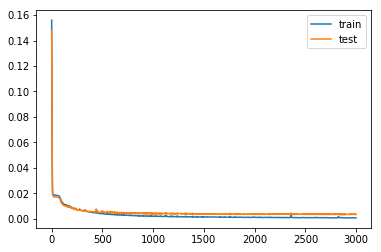

In [294]:
n_cells = 1
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.wo_pattern_cells'+str(n_cells)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad_1.fit(x_train, y_train, epochs=3000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Adding Human Pattern Behavior

The previous structure yields an MSE of 0.00334 without considering any human pattern behavior. In order to add more information to the model, a new categorical feature is invented to distinguish human behavior (driving consumption). This features aims at distinguishing weekdays from weekends.

In [43]:
# days selected for each month to use as validation set.
val_days = [1, 2, 3, 4, 5, 6, 7]

# days that the network is using to predict. 1 day, 2 days ago and the same day last week (7 days).
days = [1, 2, 7]

# chunk data in days
weatherData60 = weatherData60.loc['2016-01-01':'2017-06-30']

startDate = date(2016, 1, 1)
endDate = date(2017, 6, 30)

resol = 60
n_features = 6

x_train = np.empty((1, 1440//resol, n_features))
y_train = np.empty((1, 1440//resol))

x_val = np.empty((1, 1440//resol, n_features))
y_val = np.empty((1, 1440//resol))

countTrain = 1
countTest = 1
countVal = 1

while startDate <= endDate:
    weekday = startDate.weekday()

    startDateSt = startDate.strftime('%Y-%m-%d')
    startDatetimeSt = startDateSt + ' 00:00:00'
    endDatetimeSt = startDateSt + ' 23:00:00'
    
    x = weatherData60.loc[startDatetimeSt:endDatetimeSt]
    x = x.reset_index(drop=True)

    # adding categorical variable to distinguish weekdays from weekends
    if weekday < 5:
        x['weekday'] = pd.DataFrame(data=np.zeros((1440//resol, 1)))
    else:
        x['weekday'] = pd.DataFrame(np.ones((1440 // resol, 1)))

    # adding energy consumption to dataframe
    for day in days:
        # previous datys consumption
        date_past = startDate - timedelta(days=day)
        date_past = date_past.strftime('%Y-%m-%d')
        startDatetimeSt = date_past + ' 00:00:00'
        endDatetimeSt = date_past + ' 23:00:00'
        x_i = energyData60[idHouse].loc[startDatetimeSt:endDatetimeSt]
        '''
        x_i = pd.DataFrame([x_i])
        '''
        x_i = x_i.reset_index(drop=True)
        column_name = 'day_' + str(day)
        x_i = pd.DataFrame(x_i['use'])
        x[column_name] = x_i
    
    if startDate == date(2016, 1, 1):
        print(x.head(24))
    x = x.as_matrix()
    # print(x.shape)
    x = x.reshape(1, x.shape[0], x.shape[1])
    # print(x.shape)

    # output on target day
    y = energyData60[idHouse].loc[startDatetimeSt:endDatetimeSt]
    y = y.reset_index(drop=True)
    y = pd.DataFrame(y['use']).as_matrix()
    y = y.reshape(1, y.shape[0])


    # add data to training, validation or testing set
    if startDate < date(2017, 1, 1):
        day = startDate.day
        if int(day) in val_days:
            # validation set
            if countVal == 1:
                x_val = x
                y_val = y
                countVal += 1
            else:
                x_val = np.concatenate((x_val, x), axis=0)
                y_val = np.concatenate((y_val, y), axis=0)
        else:
            # training set
            if countTrain == 1:
                x_train = x
                y_train = y
                countTrain += 1
            else:
                x_train = np.concatenate((x_train, x), axis=0)
                y_train = np.concatenate((y_train, y), axis=0)
    elif startDate < date(2017, 7, 1):
        if countTest == 1:
            x_test = x
            y_test = y
            countTest += 1
        else:
            x_test = np.concatenate((x_test, x), axis=0)
            y_test = np.concatenate((y_test, y), axis=0)

    # update date
    startDate = startDate + timedelta(days=1)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

# ensure all data is float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_val = x_val.astype('float32')
y_val = y_val.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

n_features = x_train.shape[2]

# Normalize X
x_train = x_train.reshape((-1, n_features))
x_val = x_val.reshape((-1, n_features))
x_test = x_test.reshape((-1, n_features))

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
x_train = scalerFeatures.fit_transform(x_train)
x_val = scalerFeatures.transform(x_val)
x_test = scalerFeatures.transform(x_test)

x_train = x_train.reshape((-1, 1440 // resol, n_features))
x_val = x_val.reshape((-1, 1440 // resol, n_features))
x_test = x_test.reshape((-1, 1440 // resol, n_features))

# Normalize y
y_train = y_train.reshape((-1))
y_val = y_val.reshape((-1))
y_test = y_test.reshape((-1))

scalerOutput = MinMaxScaler(feature_range=(0, 1))
y_train = scalerOutput.fit_transform(y_train)
y_val = scalerOutput.transform(y_val)
y_test = scalerOutput.transform(y_test)

y_train = y_train.reshape((-1, 1440 // resol))
y_val = y_val.reshape((-1, 1440 // resol))
y_test = y_test.reshape((-1, 1440 // resol))

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

          hum     tempC  weekday     day_1     day_2     day_7
0   64.105000  9.084167      0.0  0.380900  0.281167  0.304600
1   63.000000  8.894000      0.0  0.420667  0.269450  0.290367
2   63.030000  8.516000      0.0  0.358583  0.296250  0.299300
3   64.915000  7.978167      0.0  0.481767  0.254833  0.321833
4   67.263333  7.416000      0.0  0.430117  0.282833  0.392267
5   67.970000  6.884167      0.0  0.443733  0.423083  0.328250
6   66.105000  6.700000      0.0  0.414533  0.346250  0.324950
7   65.000000  6.700000      0.0  0.444833  0.440583  0.270450
8   64.980000  6.705000      0.0  0.339767  0.394567  0.321033
9   63.756667  7.015833      0.0  0.662283  0.543417  0.268067
10  64.223333  7.211000      0.0  0.329183  0.829417  0.317733
11  62.473333  7.889833      0.0  0.339833  0.890300  0.276717
12  61.000000  7.984167      0.0  2.510483  0.347433  0.321167
13  61.000000  7.805000      0.0  0.644750  0.311667  0.387900
14  61.000000  8.110833      0.0  3.038367  0.279950  0

/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

### Model Selection

In [44]:
timesteps = 1440//resol
input_shape = (x_train.shape[1], x_train.shape[2])

### 1 LSTM Cell

In [45]:
# design network
modelLoad_1 = Sequential()
modelLoad_1.add(LSTM(timesteps, input_shape=input_shape))
modelLoad_1.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad_1.summary())

# compilation
modelLoad_1.compile(loss='mean_squared_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24)                2976      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 3,576
Trainable params: 3,576
Non-trainable params: 0
_________________________________________________________________
None


Train on 282 samples, validate on 84 samples
Epoch 1/3000
Epoch 00000: val_loss improved from inf to 0.14584, saving model to saved_models/weights.best.cells1.hdf5
1s - loss: 0.1557 - val_loss: 0.1458
Epoch 2/3000
Epoch 00001: val_loss improved from 0.14584 to 0.12360, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.1368 - val_loss: 0.1236
Epoch 3/3000
Epoch 00002: val_loss improved from 0.12360 to 0.09497, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.1117 - val_loss: 0.0950
Epoch 4/3000
Epoch 00003: val_loss improved from 0.09497 to 0.06950, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0844 - val_loss: 0.0695
Epoch 5/3000
Epoch 00004: val_loss improved from 0.06950 to 0.05102, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0622 - val_loss: 0.0510
Epoch 6/3000
Epoch 00005: val_loss improved from 0.05102 to 0.03803, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0464 - val_loss: 0.0380

Epoch 00052: val_loss improved from 0.01161 to 0.01148, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0125 - val_loss: 0.0115
Epoch 54/3000
Epoch 00053: val_loss improved from 0.01148 to 0.01136, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0124 - val_loss: 0.0114
Epoch 55/3000
Epoch 00054: val_loss improved from 0.01136 to 0.01126, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0122 - val_loss: 0.0113
Epoch 56/3000
Epoch 00055: val_loss improved from 0.01126 to 0.01117, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0121 - val_loss: 0.0112
Epoch 57/3000
Epoch 00056: val_loss improved from 0.01117 to 0.01108, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0120 - val_loss: 0.0111
Epoch 58/3000
Epoch 00057: val_loss improved from 0.01108 to 0.01101, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0119 - val_loss: 0.0110
Epoch 59/3000
Epoch 00058: val_loss improved fro

Epoch 00115: val_loss improved from 0.00913 to 0.00909, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0095 - val_loss: 0.0091
Epoch 117/3000
Epoch 00116: val_loss improved from 0.00909 to 0.00908, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0095 - val_loss: 0.0091
Epoch 118/3000
Epoch 00117: val_loss improved from 0.00908 to 0.00906, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0095 - val_loss: 0.0091
Epoch 119/3000
Epoch 00118: val_loss improved from 0.00906 to 0.00905, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0095 - val_loss: 0.0090
Epoch 120/3000
Epoch 00119: val_loss did not improve
0s - loss: 0.0095 - val_loss: 0.0091
Epoch 121/3000
Epoch 00120: val_loss improved from 0.00905 to 0.00904, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0094 - val_loss: 0.0090
Epoch 122/3000
Epoch 00121: val_loss improved from 0.00904 to 0.00900, saving model to saved_models/weights.best.ce

Epoch 00183: val_loss improved from 0.00755 to 0.00753, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0076 - val_loss: 0.0075
Epoch 185/3000
Epoch 00184: val_loss did not improve
0s - loss: 0.0076 - val_loss: 0.0076
Epoch 186/3000
Epoch 00185: val_loss improved from 0.00753 to 0.00747, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0075 - val_loss: 0.0075
Epoch 187/3000
Epoch 00186: val_loss improved from 0.00747 to 0.00746, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0074 - val_loss: 0.0075
Epoch 188/3000
Epoch 00187: val_loss improved from 0.00746 to 0.00742, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0075 - val_loss: 0.0074
Epoch 189/3000
Epoch 00188: val_loss did not improve
0s - loss: 0.0075 - val_loss: 0.0075
Epoch 190/3000
Epoch 00189: val_loss did not improve
0s - loss: 0.0074 - val_loss: 0.0074
Epoch 191/3000
Epoch 00190: val_loss improved from 0.00742 to 0.00736, saving model to saved_mode

0s - loss: 0.0062 - val_loss: 0.0063
Epoch 246/3000
Epoch 00245: val_loss improved from 0.00635 to 0.00635, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0061 - val_loss: 0.0063
Epoch 247/3000
Epoch 00246: val_loss improved from 0.00635 to 0.00634, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0061 - val_loss: 0.0063
Epoch 248/3000
Epoch 00247: val_loss improved from 0.00634 to 0.00633, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0061 - val_loss: 0.0063
Epoch 249/3000
Epoch 00248: val_loss improved from 0.00633 to 0.00633, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0061 - val_loss: 0.0063
Epoch 250/3000
Epoch 00249: val_loss improved from 0.00633 to 0.00630, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0061 - val_loss: 0.0063
Epoch 251/3000
Epoch 00250: val_loss improved from 0.00630 to 0.00629, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0060 - val_loss

Epoch 00302: val_loss did not improve
0s - loss: 0.0053 - val_loss: 0.0058
Epoch 304/3000
Epoch 00303: val_loss improved from 0.00575 to 0.00574, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0053 - val_loss: 0.0057
Epoch 305/3000
Epoch 00304: val_loss improved from 0.00574 to 0.00573, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0053 - val_loss: 0.0057
Epoch 306/3000
Epoch 00305: val_loss improved from 0.00573 to 0.00572, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0053 - val_loss: 0.0057
Epoch 307/3000
Epoch 00306: val_loss improved from 0.00572 to 0.00571, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0053 - val_loss: 0.0057
Epoch 308/3000
Epoch 00307: val_loss improved from 0.00571 to 0.00569, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0053 - val_loss: 0.0057
Epoch 309/3000
Epoch 00308: val_loss did not improve
0s - loss: 0.0052 - val_loss: 0.0057
Epoch 310/3000
Epoch 0030

Epoch 00372: val_loss improved from 0.00519 to 0.00518, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0044 - val_loss: 0.0052
Epoch 374/3000
Epoch 00373: val_loss improved from 0.00518 to 0.00517, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0044 - val_loss: 0.0052
Epoch 375/3000
Epoch 00374: val_loss improved from 0.00517 to 0.00514, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 376/3000
Epoch 00375: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0052
Epoch 377/3000
Epoch 00376: val_loss improved from 0.00514 to 0.00514, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 378/3000
Epoch 00377: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 379/3000
Epoch 00378: val_loss improved from 0.00514 to 0.00513, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0043 - val_loss: 0.0051
Epoch 380/3000
Epoch 0037

Epoch 00444: val_loss improved from 0.00468 to 0.00466, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0038 - val_loss: 0.0047
Epoch 446/3000
Epoch 00445: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0048
Epoch 447/3000
Epoch 00446: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0047
Epoch 448/3000
Epoch 00447: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0049
Epoch 449/3000
Epoch 00448: val_loss improved from 0.00466 to 0.00464, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0039 - val_loss: 0.0046
Epoch 450/3000
Epoch 00449: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0047
Epoch 451/3000
Epoch 00450: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0048
Epoch 452/3000
Epoch 00451: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0047
Epoch 453/3000
Epoch 00452: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0047
Epoch 454/3000
Epoch 00453: val_loss improved from 0.00464 to

Epoch 00520: val_loss improved from 0.00436 to 0.00436, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0034 - val_loss: 0.0044
Epoch 522/3000
Epoch 00521: val_loss improved from 0.00436 to 0.00435, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0033 - val_loss: 0.0044
Epoch 523/3000
Epoch 00522: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0044
Epoch 524/3000
Epoch 00523: val_loss improved from 0.00435 to 0.00435, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0033 - val_loss: 0.0043
Epoch 525/3000
Epoch 00524: val_loss improved from 0.00435 to 0.00434, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0033 - val_loss: 0.0043
Epoch 526/3000
Epoch 00525: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0043
Epoch 527/3000
Epoch 00526: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0044
Epoch 528/3000
Epoch 00527: val_loss improved from 0.00434 to 0.00431, saving model to saved_mode

Epoch 00600: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0043
Epoch 602/3000
Epoch 00601: val_loss did not improve
0s - loss: 0.0032 - val_loss: 0.0044
Epoch 603/3000
Epoch 00602: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0057
Epoch 604/3000
Epoch 00603: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0046
Epoch 605/3000
Epoch 00604: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0051
Epoch 606/3000
Epoch 00605: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0054
Epoch 607/3000
Epoch 00606: val_loss did not improve
0s - loss: 0.0037 - val_loss: 0.0047
Epoch 608/3000
Epoch 00607: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0043
Epoch 609/3000
Epoch 00608: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0046
Epoch 610/3000
Epoch 00609: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0049
Epoch 611/3000
Epoch 00610: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0049
Epoch 612/3000
Epoch 0061

Epoch 00688: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0043
Epoch 690/3000
Epoch 00689: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0043
Epoch 691/3000
Epoch 00690: val_loss did not improve
0s - loss: 0.0029 - val_loss: 0.0042
Epoch 692/3000
Epoch 00691: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0041
Epoch 693/3000
Epoch 00692: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0042
Epoch 694/3000
Epoch 00693: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0042
Epoch 695/3000
Epoch 00694: val_loss improved from 0.00400 to 0.00396, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0028 - val_loss: 0.0040
Epoch 696/3000
Epoch 00695: val_loss did not improve
0s - loss: 0.0027 - val_loss: 0.0041
Epoch 697/3000
Epoch 00696: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0042
Epoch 698/3000
Epoch 00697: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0040
Epoch 699/3000
Epoch 00698: val_loss did no

Epoch 00774: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0040
Epoch 776/3000
Epoch 00775: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0039
Epoch 777/3000
Epoch 00776: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0040
Epoch 778/3000
Epoch 00777: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0040
Epoch 779/3000
Epoch 00778: val_loss improved from 0.00388 to 0.00386, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0025 - val_loss: 0.0039
Epoch 780/3000
Epoch 00779: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0040
Epoch 781/3000
Epoch 00780: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0041
Epoch 782/3000
Epoch 00781: val_loss improved from 0.00386 to 0.00385, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0025 - val_loss: 0.0039
Epoch 783/3000
Epoch 00782: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0040
Epoch 784/3000
Epoch 00783: val_loss did not improve
0s - los

Epoch 00858: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0039
Epoch 860/3000
Epoch 00859: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0038
Epoch 861/3000
Epoch 00860: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0041
Epoch 862/3000
Epoch 00861: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0037
Epoch 863/3000
Epoch 00862: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0041
Epoch 864/3000
Epoch 00863: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0038
Epoch 865/3000
Epoch 00864: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0037
Epoch 866/3000
Epoch 00865: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0040
Epoch 867/3000
Epoch 00866: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0037
Epoch 868/3000
Epoch 00867: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0039
Epoch 869/3000
Epoch 00868: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0037
Epoch 870/3000
Epoch 0086

Epoch 00948: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0037
Epoch 950/3000
Epoch 00949: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0037
Epoch 951/3000
Epoch 00950: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0038
Epoch 952/3000
Epoch 00951: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0036
Epoch 953/3000
Epoch 00952: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0038
Epoch 954/3000
Epoch 00953: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0037
Epoch 955/3000
Epoch 00954: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0037
Epoch 956/3000
Epoch 00955: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0037
Epoch 957/3000
Epoch 00956: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0036
Epoch 958/3000
Epoch 00957: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0037
Epoch 959/3000
Epoch 00958: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0036
Epoch 960/3000
Epoch 0095

Epoch 01038: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0038
Epoch 1040/3000
Epoch 01039: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0035
Epoch 1041/3000
Epoch 01040: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0036
Epoch 1042/3000
Epoch 01041: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0038
Epoch 1043/3000
Epoch 01042: val_loss improved from 0.00348 to 0.00347, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0019 - val_loss: 0.0035
Epoch 1044/3000
Epoch 01043: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0036
Epoch 1045/3000
Epoch 01044: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0037
Epoch 1046/3000
Epoch 01045: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0035
Epoch 1047/3000
Epoch 01046: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0035
Epoch 1048/3000
Epoch 01047: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0036
Epoch 1049/3000
Epoch 01048: val_l

Epoch 01126: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1128/3000
Epoch 01127: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0036
Epoch 1129/3000
Epoch 01128: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0034
Epoch 1130/3000
Epoch 01129: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1131/3000
Epoch 01130: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1132/3000
Epoch 01131: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1133/3000
Epoch 01132: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1134/3000
Epoch 01133: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1135/3000
Epoch 01134: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1136/3000
Epoch 01135: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0035
Epoch 1137/3000
Epoch 01136: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0034
Epoch 1138/3000

Epoch 01212: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0036
Epoch 1214/3000
Epoch 01213: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1215/3000
Epoch 01214: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0035
Epoch 1216/3000
Epoch 01215: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1217/3000
Epoch 01216: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0034
Epoch 1218/3000
Epoch 01217: val_loss improved from 0.00331 to 0.00330, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1219/3000
Epoch 01218: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0036
Epoch 1220/3000
Epoch 01219: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1221/3000
Epoch 01220: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0036
Epoch 1222/3000
Epoch 01221: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1223/3000
Epoch 01222: val_l

Epoch 01298: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0034
Epoch 1300/3000
Epoch 01299: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1301/3000
Epoch 01300: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1302/3000
Epoch 01301: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1303/3000
Epoch 01302: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1304/3000
Epoch 01303: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1305/3000
Epoch 01304: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0034
Epoch 1306/3000
Epoch 01305: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1307/3000
Epoch 01306: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1308/3000
Epoch 01307: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0034
Epoch 1309/3000
Epoch 01308: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1310/3000

Epoch 01384: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0034
Epoch 1386/3000
Epoch 01385: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1387/3000
Epoch 01386: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1388/3000
Epoch 01387: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1389/3000
Epoch 01388: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1390/3000
Epoch 01389: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0032
Epoch 1391/3000
Epoch 01390: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1392/3000
Epoch 01391: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0032
Epoch 1393/3000
Epoch 01392: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1394/3000
Epoch 01393: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0032
Epoch 1395/3000
Epoch 01394: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0033
Epoch 1396/3000

Epoch 01476: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0037
Epoch 1478/3000
Epoch 01477: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0038
Epoch 1479/3000
Epoch 01478: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0033
Epoch 1480/3000
Epoch 01479: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0035
Epoch 1481/3000
Epoch 01480: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0038
Epoch 1482/3000
Epoch 01481: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0033
Epoch 1483/3000
Epoch 01482: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0032
Epoch 1484/3000
Epoch 01483: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0032
Epoch 1485/3000
Epoch 01484: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0032
Epoch 1486/3000
Epoch 01485: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1487/3000
Epoch 01486: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1488/3000

Epoch 01566: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1568/3000
Epoch 01567: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1569/3000
Epoch 01568: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1570/3000
Epoch 01569: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0033
Epoch 1571/3000
Epoch 01570: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1572/3000
Epoch 01571: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1573/3000
Epoch 01572: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1574/3000
Epoch 01573: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0033
Epoch 1575/3000
Epoch 01574: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0031
Epoch 1576/3000
Epoch 01575: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1577/3000
Epoch 01576: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0033
Epoch 1578/3000

Epoch 01656: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0034
Epoch 1658/3000
Epoch 01657: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1659/3000
Epoch 01658: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0030
Epoch 1660/3000
Epoch 01659: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0034
Epoch 1661/3000
Epoch 01660: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1662/3000
Epoch 01661: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0032
Epoch 1663/3000
Epoch 01662: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0033
Epoch 1664/3000
Epoch 01663: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0034
Epoch 1665/3000
Epoch 01664: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0031
Epoch 1666/3000
Epoch 01665: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0035
Epoch 1667/3000
Epoch 01666: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0031
Epoch 1668/3000

Epoch 01748: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0031
Epoch 1750/3000
Epoch 01749: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1751/3000
Epoch 01750: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1752/3000
Epoch 01751: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0031
Epoch 1753/3000
Epoch 01752: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1754/3000
Epoch 01753: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0032
Epoch 1755/3000
Epoch 01754: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0031
Epoch 1756/3000
Epoch 01755: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1757/3000
Epoch 01756: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1758/3000
Epoch 01757: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0031
Epoch 1759/3000
Epoch 01758: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0032
Epoch 1760/3000

Epoch 01838: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0032
Epoch 1840/3000
Epoch 01839: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0031
Epoch 1841/3000
Epoch 01840: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1842/3000
Epoch 01841: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0032
Epoch 1843/3000
Epoch 01842: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0030
Epoch 1844/3000
Epoch 01843: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1845/3000
Epoch 01844: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1846/3000
Epoch 01845: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0030
Epoch 1847/3000
Epoch 01846: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1848/3000
Epoch 01847: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1849/3000
Epoch 01848: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 1850/3000

Epoch 01930: val_loss improved from 0.00298 to 0.00295, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 0.0011 - val_loss: 0.0030
Epoch 1932/3000
Epoch 01931: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0031
Epoch 1933/3000
Epoch 01932: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0033
Epoch 1934/3000
Epoch 01933: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0031
Epoch 1935/3000
Epoch 01934: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0030
Epoch 1936/3000
Epoch 01935: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0033
Epoch 1937/3000
Epoch 01936: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0030
Epoch 1938/3000
Epoch 01937: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0031
Epoch 1939/3000
Epoch 01938: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0032
Epoch 1940/3000
Epoch 01939: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0030
Epoch 1941/3000
Epoch 01940: val_l

Epoch 02018: val_loss did not improve
0s - loss: 9.6212e-04 - val_loss: 0.0031
Epoch 2020/3000
Epoch 02019: val_loss did not improve
0s - loss: 9.5188e-04 - val_loss: 0.0030
Epoch 2021/3000
Epoch 02020: val_loss did not improve
0s - loss: 9.6276e-04 - val_loss: 0.0031
Epoch 2022/3000
Epoch 02021: val_loss did not improve
0s - loss: 9.5632e-04 - val_loss: 0.0030
Epoch 2023/3000
Epoch 02022: val_loss did not improve
0s - loss: 9.4137e-04 - val_loss: 0.0030
Epoch 2024/3000
Epoch 02023: val_loss did not improve
0s - loss: 9.3997e-04 - val_loss: 0.0031
Epoch 2025/3000
Epoch 02024: val_loss did not improve
0s - loss: 9.4824e-04 - val_loss: 0.0030
Epoch 2026/3000
Epoch 02025: val_loss did not improve
0s - loss: 9.4740e-04 - val_loss: 0.0030
Epoch 2027/3000
Epoch 02026: val_loss did not improve
0s - loss: 9.4077e-04 - val_loss: 0.0031
Epoch 2028/3000
Epoch 02027: val_loss did not improve
0s - loss: 9.4234e-04 - val_loss: 0.0030
Epoch 2029/3000
Epoch 02028: val_loss did not improve
0s - loss: 9

Epoch 02106: val_loss did not improve
0s - loss: 9.8287e-04 - val_loss: 0.0030
Epoch 2108/3000
Epoch 02107: val_loss did not improve
0s - loss: 9.3936e-04 - val_loss: 0.0030
Epoch 2109/3000
Epoch 02108: val_loss did not improve
0s - loss: 9.2925e-04 - val_loss: 0.0031
Epoch 2110/3000
Epoch 02109: val_loss did not improve
0s - loss: 9.3390e-04 - val_loss: 0.0030
Epoch 2111/3000
Epoch 02110: val_loss did not improve
0s - loss: 9.4683e-04 - val_loss: 0.0031
Epoch 2112/3000
Epoch 02111: val_loss did not improve
0s - loss: 9.8145e-04 - val_loss: 0.0030
Epoch 2113/3000
Epoch 02112: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0031
Epoch 2114/3000
Epoch 02113: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0031
Epoch 2115/3000
Epoch 02114: val_loss did not improve
0s - loss: 9.8879e-04 - val_loss: 0.0030
Epoch 2116/3000
Epoch 02115: val_loss did not improve
0s - loss: 9.8827e-04 - val_loss: 0.0030
Epoch 2117/3000
Epoch 02116: val_loss did not improve
0s - loss: 9.5257e-0

Epoch 02190: val_loss did not improve
0s - loss: 9.2561e-04 - val_loss: 0.0031
Epoch 2192/3000
Epoch 02191: val_loss did not improve
0s - loss: 9.5897e-04 - val_loss: 0.0030
Epoch 2193/3000
Epoch 02192: val_loss did not improve
0s - loss: 9.4836e-04 - val_loss: 0.0031
Epoch 2194/3000
Epoch 02193: val_loss did not improve
0s - loss: 9.5947e-04 - val_loss: 0.0030
Epoch 2195/3000
Epoch 02194: val_loss did not improve
0s - loss: 9.3328e-04 - val_loss: 0.0030
Epoch 2196/3000
Epoch 02195: val_loss did not improve
0s - loss: 9.5920e-04 - val_loss: 0.0030
Epoch 2197/3000
Epoch 02196: val_loss did not improve
0s - loss: 9.3668e-04 - val_loss: 0.0032
Epoch 2198/3000
Epoch 02197: val_loss did not improve
0s - loss: 9.3992e-04 - val_loss: 0.0029
Epoch 2199/3000
Epoch 02198: val_loss did not improve
0s - loss: 9.2339e-04 - val_loss: 0.0030
Epoch 2200/3000
Epoch 02199: val_loss did not improve
0s - loss: 9.3249e-04 - val_loss: 0.0032
Epoch 2201/3000
Epoch 02200: val_loss did not improve
0s - loss: 9

Epoch 02276: val_loss did not improve
0s - loss: 8.7915e-04 - val_loss: 0.0029
Epoch 2278/3000
Epoch 02277: val_loss did not improve
0s - loss: 8.9184e-04 - val_loss: 0.0029
Epoch 2279/3000
Epoch 02278: val_loss did not improve
0s - loss: 8.8644e-04 - val_loss: 0.0031
Epoch 2280/3000
Epoch 02279: val_loss improved from 0.00279 to 0.00276, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 8.9039e-04 - val_loss: 0.0028
Epoch 2281/3000
Epoch 02280: val_loss did not improve
0s - loss: 9.1118e-04 - val_loss: 0.0030
Epoch 2282/3000
Epoch 02281: val_loss did not improve
0s - loss: 9.2606e-04 - val_loss: 0.0031
Epoch 2283/3000
Epoch 02282: val_loss did not improve
0s - loss: 9.4334e-04 - val_loss: 0.0030
Epoch 2284/3000
Epoch 02283: val_loss did not improve
0s - loss: 9.1940e-04 - val_loss: 0.0028
Epoch 2285/3000
Epoch 02284: val_loss did not improve
0s - loss: 9.6325e-04 - val_loss: 0.0032
Epoch 2286/3000
Epoch 02285: val_loss did not improve
0s - loss: 9.7266e-04 - val_loss: 0

Epoch 02364: val_loss did not improve
0s - loss: 9.4181e-04 - val_loss: 0.0030
Epoch 2366/3000
Epoch 02365: val_loss did not improve
0s - loss: 8.7117e-04 - val_loss: 0.0030
Epoch 2367/3000
Epoch 02366: val_loss improved from 0.00276 to 0.00275, saving model to saved_models/weights.best.cells1.hdf5
0s - loss: 8.4345e-04 - val_loss: 0.0028
Epoch 2368/3000
Epoch 02367: val_loss did not improve
0s - loss: 8.8200e-04 - val_loss: 0.0031
Epoch 2369/3000
Epoch 02368: val_loss did not improve
0s - loss: 8.5699e-04 - val_loss: 0.0029
Epoch 2370/3000
Epoch 02369: val_loss did not improve
0s - loss: 8.2415e-04 - val_loss: 0.0029
Epoch 2371/3000
Epoch 02370: val_loss did not improve
0s - loss: 8.2755e-04 - val_loss: 0.0030
Epoch 2372/3000
Epoch 02371: val_loss did not improve
0s - loss: 8.3416e-04 - val_loss: 0.0029
Epoch 2373/3000
Epoch 02372: val_loss did not improve
0s - loss: 8.4895e-04 - val_loss: 0.0030
Epoch 2374/3000
Epoch 02373: val_loss did not improve
0s - loss: 8.4885e-04 - val_loss: 0

Epoch 02451: val_loss did not improve
0s - loss: 7.9252e-04 - val_loss: 0.0029
Epoch 2453/3000
Epoch 02452: val_loss did not improve
0s - loss: 7.9402e-04 - val_loss: 0.0028
Epoch 2454/3000
Epoch 02453: val_loss did not improve
0s - loss: 7.8697e-04 - val_loss: 0.0029
Epoch 2455/3000
Epoch 02454: val_loss did not improve
0s - loss: 7.8538e-04 - val_loss: 0.0028
Epoch 2456/3000
Epoch 02455: val_loss did not improve
0s - loss: 7.8266e-04 - val_loss: 0.0029
Epoch 2457/3000
Epoch 02456: val_loss did not improve
0s - loss: 7.8004e-04 - val_loss: 0.0028
Epoch 2458/3000
Epoch 02457: val_loss did not improve
0s - loss: 7.7269e-04 - val_loss: 0.0029
Epoch 2459/3000
Epoch 02458: val_loss did not improve
0s - loss: 7.7825e-04 - val_loss: 0.0028
Epoch 2460/3000
Epoch 02459: val_loss did not improve
0s - loss: 7.7753e-04 - val_loss: 0.0029
Epoch 2461/3000
Epoch 02460: val_loss did not improve
0s - loss: 7.8008e-04 - val_loss: 0.0028
Epoch 2462/3000
Epoch 02461: val_loss did not improve
0s - loss: 7

Epoch 02537: val_loss did not improve
0s - loss: 8.1513e-04 - val_loss: 0.0029
Epoch 2539/3000
Epoch 02538: val_loss did not improve
0s - loss: 7.9896e-04 - val_loss: 0.0028
Epoch 2540/3000
Epoch 02539: val_loss did not improve
0s - loss: 8.2496e-04 - val_loss: 0.0029
Epoch 2541/3000
Epoch 02540: val_loss did not improve
0s - loss: 7.9327e-04 - val_loss: 0.0029
Epoch 2542/3000
Epoch 02541: val_loss did not improve
0s - loss: 7.8798e-04 - val_loss: 0.0027
Epoch 2543/3000
Epoch 02542: val_loss did not improve
0s - loss: 8.0295e-04 - val_loss: 0.0030
Epoch 2544/3000
Epoch 02543: val_loss did not improve
0s - loss: 8.1521e-04 - val_loss: 0.0028
Epoch 2545/3000
Epoch 02544: val_loss did not improve
0s - loss: 7.9793e-04 - val_loss: 0.0028
Epoch 2546/3000
Epoch 02545: val_loss did not improve
0s - loss: 7.9967e-04 - val_loss: 0.0029
Epoch 2547/3000
Epoch 02546: val_loss did not improve
0s - loss: 7.8970e-04 - val_loss: 0.0028
Epoch 2548/3000
Epoch 02547: val_loss did not improve
0s - loss: 8

Epoch 02624: val_loss did not improve
0s - loss: 7.7744e-04 - val_loss: 0.0028
Epoch 2626/3000
Epoch 02625: val_loss did not improve
0s - loss: 8.6908e-04 - val_loss: 0.0030
Epoch 2627/3000
Epoch 02626: val_loss did not improve
0s - loss: 8.0675e-04 - val_loss: 0.0029
Epoch 2628/3000
Epoch 02627: val_loss did not improve
0s - loss: 7.6744e-04 - val_loss: 0.0027
Epoch 2629/3000
Epoch 02628: val_loss did not improve
0s - loss: 8.1119e-04 - val_loss: 0.0030
Epoch 2630/3000
Epoch 02629: val_loss did not improve
0s - loss: 8.0374e-04 - val_loss: 0.0029
Epoch 2631/3000
Epoch 02630: val_loss did not improve
0s - loss: 7.7524e-04 - val_loss: 0.0027
Epoch 2632/3000
Epoch 02631: val_loss did not improve
0s - loss: 8.0214e-04 - val_loss: 0.0030
Epoch 2633/3000
Epoch 02632: val_loss did not improve
0s - loss: 7.9194e-04 - val_loss: 0.0028
Epoch 2634/3000
Epoch 02633: val_loss did not improve
0s - loss: 8.1917e-04 - val_loss: 0.0030
Epoch 2635/3000
Epoch 02634: val_loss did not improve
0s - loss: 8

Epoch 02711: val_loss did not improve
0s - loss: 7.8736e-04 - val_loss: 0.0029
Epoch 2713/3000
Epoch 02712: val_loss did not improve
0s - loss: 7.9912e-04 - val_loss: 0.0028
Epoch 2714/3000
Epoch 02713: val_loss did not improve
0s - loss: 8.1191e-04 - val_loss: 0.0028
Epoch 2715/3000
Epoch 02714: val_loss did not improve
0s - loss: 8.2705e-04 - val_loss: 0.0029
Epoch 2716/3000
Epoch 02715: val_loss did not improve
0s - loss: 7.9717e-04 - val_loss: 0.0028
Epoch 2717/3000
Epoch 02716: val_loss did not improve
0s - loss: 8.3830e-04 - val_loss: 0.0028
Epoch 2718/3000
Epoch 02717: val_loss did not improve
0s - loss: 7.8715e-04 - val_loss: 0.0029
Epoch 2719/3000
Epoch 02718: val_loss did not improve
0s - loss: 7.8686e-04 - val_loss: 0.0028
Epoch 2720/3000
Epoch 02719: val_loss did not improve
0s - loss: 7.8417e-04 - val_loss: 0.0028
Epoch 2721/3000
Epoch 02720: val_loss did not improve
0s - loss: 7.9621e-04 - val_loss: 0.0029
Epoch 2722/3000
Epoch 02721: val_loss did not improve
0s - loss: 7

Epoch 02793: val_loss did not improve
0s - loss: 7.3890e-04 - val_loss: 0.0027
Epoch 2795/3000
Epoch 02794: val_loss did not improve
0s - loss: 7.9033e-04 - val_loss: 0.0029
Epoch 2796/3000
Epoch 02795: val_loss did not improve
0s - loss: 7.6780e-04 - val_loss: 0.0028
Epoch 2797/3000
Epoch 02796: val_loss did not improve
0s - loss: 7.5812e-04 - val_loss: 0.0028
Epoch 2798/3000
Epoch 02797: val_loss did not improve
0s - loss: 7.3876e-04 - val_loss: 0.0029
Epoch 2799/3000
Epoch 02798: val_loss did not improve
0s - loss: 7.1405e-04 - val_loss: 0.0027
Epoch 2800/3000
Epoch 02799: val_loss did not improve
0s - loss: 7.2666e-04 - val_loss: 0.0027
Epoch 2801/3000
Epoch 02800: val_loss did not improve
0s - loss: 7.3022e-04 - val_loss: 0.0030
Epoch 2802/3000
Epoch 02801: val_loss did not improve
0s - loss: 7.6439e-04 - val_loss: 0.0027
Epoch 2803/3000
Epoch 02802: val_loss did not improve
0s - loss: 8.2370e-04 - val_loss: 0.0029
Epoch 2804/3000
Epoch 02803: val_loss did not improve
0s - loss: 7

Epoch 02879: val_loss did not improve
0s - loss: 6.7234e-04 - val_loss: 0.0027
Epoch 2881/3000
Epoch 02880: val_loss did not improve
0s - loss: 6.6349e-04 - val_loss: 0.0028
Epoch 2882/3000
Epoch 02881: val_loss did not improve
0s - loss: 6.5329e-04 - val_loss: 0.0028
Epoch 2883/3000
Epoch 02882: val_loss did not improve
0s - loss: 6.6710e-04 - val_loss: 0.0027
Epoch 2884/3000
Epoch 02883: val_loss did not improve
0s - loss: 7.0267e-04 - val_loss: 0.0029
Epoch 2885/3000
Epoch 02884: val_loss did not improve
0s - loss: 7.0405e-04 - val_loss: 0.0027
Epoch 2886/3000
Epoch 02885: val_loss did not improve
0s - loss: 7.1131e-04 - val_loss: 0.0027
Epoch 2887/3000
Epoch 02886: val_loss did not improve
0s - loss: 6.9631e-04 - val_loss: 0.0029
Epoch 2888/3000
Epoch 02887: val_loss did not improve
0s - loss: 7.0567e-04 - val_loss: 0.0027
Epoch 2889/3000
Epoch 02888: val_loss did not improve
0s - loss: 7.4351e-04 - val_loss: 0.0028
Epoch 2890/3000
Epoch 02889: val_loss did not improve
0s - loss: 7

Epoch 02965: val_loss did not improve
0s - loss: 7.1240e-04 - val_loss: 0.0028
Epoch 2967/3000
Epoch 02966: val_loss did not improve
0s - loss: 6.9966e-04 - val_loss: 0.0027
Epoch 2968/3000
Epoch 02967: val_loss did not improve
0s - loss: 7.0701e-04 - val_loss: 0.0028
Epoch 2969/3000
Epoch 02968: val_loss did not improve
0s - loss: 6.9305e-04 - val_loss: 0.0027
Epoch 2970/3000
Epoch 02969: val_loss did not improve
0s - loss: 6.9086e-04 - val_loss: 0.0027
Epoch 2971/3000
Epoch 02970: val_loss did not improve
0s - loss: 6.6156e-04 - val_loss: 0.0027
Epoch 2972/3000
Epoch 02971: val_loss did not improve
0s - loss: 6.6123e-04 - val_loss: 0.0028
Epoch 2973/3000
Epoch 02972: val_loss did not improve
0s - loss: 6.5001e-04 - val_loss: 0.0027
Epoch 2974/3000
Epoch 02973: val_loss did not improve
0s - loss: 6.4724e-04 - val_loss: 0.0028
Epoch 2975/3000
Epoch 02974: val_loss did not improve
0s - loss: 6.5448e-04 - val_loss: 0.0026
Epoch 2976/3000
Epoch 02975: val_loss did not improve
0s - loss: 6

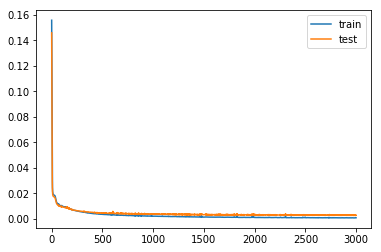

In [212]:
n_cells = 1
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cells'+str(n_cells)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad_1.fit(x_train, y_train, epochs=3000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

As we can see, adding that new feature has improven the validation score (MSE) from 0.0032 to 0.0026. Let's see if stacking more LSTM cells improve performance.

### 2 LSTM Cells

In [211]:
# design network: 2 stacked LSTM Cells + 1 fully connected layer
modelLoad_2 = Sequential()
modelLoad_2.add(LSTM(timesteps, return_sequences=True, input_shape=input_shape))
modelLoad_2.add(LSTM(timesteps))
modelLoad_2.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad_2.summary())

# compilation
modelLoad_2.compile(loss='mean_squared_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 24)            2976      
_________________________________________________________________
lstm_5 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
Total params: 8,280
Trainable params: 8,280
Non-trainable params: 0
_________________________________________________________________
None


Train on 282 samples, validate on 84 samples
Epoch 1/3000
Epoch 00000: val_loss improved from inf to 0.15264, saving model to saved_models/weights.best.cells2.hdf5
1s - loss: 0.1592 - val_loss: 0.1526
Epoch 2/3000
Epoch 00001: val_loss improved from 0.15264 to 0.12813, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.1441 - val_loss: 0.1281
Epoch 3/3000
Epoch 00002: val_loss improved from 0.12813 to 0.08619, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.1104 - val_loss: 0.0862
Epoch 4/3000
Epoch 00003: val_loss improved from 0.08619 to 0.05745, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0735 - val_loss: 0.0574
Epoch 5/3000
Epoch 00004: val_loss improved from 0.05745 to 0.03995, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0499 - val_loss: 0.0399
Epoch 6/3000
Epoch 00005: val_loss improved from 0.03995 to 0.03008, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0359 - val_loss: 0.0301

Epoch 00051: val_loss improved from 0.01703 to 0.01701, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0185 - val_loss: 0.0170
Epoch 53/3000
Epoch 00052: val_loss improved from 0.01701 to 0.01698, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0185 - val_loss: 0.0170
Epoch 54/3000
Epoch 00053: val_loss improved from 0.01698 to 0.01693, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0185 - val_loss: 0.0169
Epoch 55/3000
Epoch 00054: val_loss improved from 0.01693 to 0.01687, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0185 - val_loss: 0.0169
Epoch 56/3000
Epoch 00055: val_loss improved from 0.01687 to 0.01679, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0184 - val_loss: 0.0168
Epoch 57/3000
Epoch 00056: val_loss improved from 0.01679 to 0.01669, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0183 - val_loss: 0.0167
Epoch 58/3000
Epoch 00057: val_loss improved fro

Epoch 00116: val_loss did not improve
0s - loss: 0.0132 - val_loss: 0.0125
Epoch 118/3000
Epoch 00117: val_loss improved from 0.01137 to 0.01131, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0142 - val_loss: 0.0113
Epoch 119/3000
Epoch 00118: val_loss improved from 0.01131 to 0.01123, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0127 - val_loss: 0.0112
Epoch 120/3000
Epoch 00119: val_loss did not improve
0s - loss: 0.0122 - val_loss: 0.0113
Epoch 121/3000
Epoch 00120: val_loss did not improve
0s - loss: 0.0120 - val_loss: 0.0112
Epoch 122/3000
Epoch 00121: val_loss improved from 0.01123 to 0.01114, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0118 - val_loss: 0.0111
Epoch 123/3000
Epoch 00122: val_loss improved from 0.01114 to 0.01106, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0117 - val_loss: 0.0111
Epoch 124/3000
Epoch 00123: val_loss did not improve
0s - loss: 0.0117 - val_loss: 0.0112
Epoch 1

Epoch 00184: val_loss improved from 0.00957 to 0.00953, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0099 - val_loss: 0.0095
Epoch 186/3000
Epoch 00185: val_loss did not improve
0s - loss: 0.0098 - val_loss: 0.0096
Epoch 187/3000
Epoch 00186: val_loss improved from 0.00953 to 0.00953, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0097 - val_loss: 0.0095
Epoch 188/3000
Epoch 00187: val_loss did not improve
0s - loss: 0.0097 - val_loss: 0.0096
Epoch 189/3000
Epoch 00188: val_loss did not improve
0s - loss: 0.0097 - val_loss: 0.0096
Epoch 190/3000
Epoch 00189: val_loss did not improve
0s - loss: 0.0097 - val_loss: 0.0097
Epoch 191/3000
Epoch 00190: val_loss did not improve
0s - loss: 0.0097 - val_loss: 0.0096
Epoch 192/3000
Epoch 00191: val_loss did not improve
0s - loss: 0.0096 - val_loss: 0.0097
Epoch 193/3000
Epoch 00192: val_loss improved from 0.00953 to 0.00952, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0096 - val_lo

Epoch 00254: val_loss did not improve
0s - loss: 0.0071 - val_loss: 0.0079
Epoch 256/3000
Epoch 00255: val_loss did not improve
0s - loss: 0.0071 - val_loss: 0.0078
Epoch 257/3000
Epoch 00256: val_loss did not improve
0s - loss: 0.0073 - val_loss: 0.0080
Epoch 258/3000
Epoch 00257: val_loss did not improve
0s - loss: 0.0072 - val_loss: 0.0079
Epoch 259/3000
Epoch 00258: val_loss improved from 0.00760 to 0.00749, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0072 - val_loss: 0.0075
Epoch 260/3000
Epoch 00259: val_loss did not improve
0s - loss: 0.0071 - val_loss: 0.0077
Epoch 261/3000
Epoch 00260: val_loss did not improve
0s - loss: 0.0069 - val_loss: 0.0075
Epoch 262/3000
Epoch 00261: val_loss improved from 0.00749 to 0.00742, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0069 - val_loss: 0.0074
Epoch 263/3000
Epoch 00262: val_loss did not improve
0s - loss: 0.0068 - val_loss: 0.0078
Epoch 264/3000
Epoch 00263: val_loss did not improve
0s - los

Epoch 00326: val_loss did not improve
0s - loss: 0.0056 - val_loss: 0.0072
Epoch 328/3000
Epoch 00327: val_loss did not improve
0s - loss: 0.0062 - val_loss: 0.0071
Epoch 329/3000
Epoch 00328: val_loss did not improve
0s - loss: 0.0061 - val_loss: 0.0074
Epoch 330/3000
Epoch 00329: val_loss did not improve
0s - loss: 0.0072 - val_loss: 0.0069
Epoch 331/3000
Epoch 00330: val_loss did not improve
0s - loss: 0.0062 - val_loss: 0.0064
Epoch 332/3000
Epoch 00331: val_loss improved from 0.00626 to 0.00621, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0058 - val_loss: 0.0062
Epoch 333/3000
Epoch 00332: val_loss improved from 0.00621 to 0.00606, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0057 - val_loss: 0.0061
Epoch 334/3000
Epoch 00333: val_loss improved from 0.00606 to 0.00603, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0055 - val_loss: 0.0060
Epoch 335/3000
Epoch 00334: val_loss improved from 0.00603 to 0.00602, saving m

Epoch 00392: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0051
Epoch 394/3000
Epoch 00393: val_loss improved from 0.00507 to 0.00505, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0038 - val_loss: 0.0051
Epoch 395/3000
Epoch 00394: val_loss improved from 0.00505 to 0.00504, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0038 - val_loss: 0.0050
Epoch 396/3000
Epoch 00395: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0051
Epoch 397/3000
Epoch 00396: val_loss improved from 0.00504 to 0.00501, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0038 - val_loss: 0.0050
Epoch 398/3000
Epoch 00397: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0051
Epoch 399/3000
Epoch 00398: val_loss improved from 0.00501 to 0.00500, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0038 - val_loss: 0.0050
Epoch 400/3000
Epoch 00399: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0051
Epoch 4

Epoch 00470: val_loss did not improve
0s - loss: 0.0031 - val_loss: 0.0046
Epoch 472/3000
Epoch 00471: val_loss improved from 0.00441 to 0.00434, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0031 - val_loss: 0.0043
Epoch 473/3000
Epoch 00472: val_loss did not improve
0s - loss: 0.0030 - val_loss: 0.0045
Epoch 474/3000
Epoch 00473: val_loss did not improve
0s - loss: 0.0030 - val_loss: 0.0045
Epoch 475/3000
Epoch 00474: val_loss did not improve
0s - loss: 0.0030 - val_loss: 0.0045
Epoch 476/3000
Epoch 00475: val_loss did not improve
0s - loss: 0.0030 - val_loss: 0.0045
Epoch 477/3000
Epoch 00476: val_loss did not improve
0s - loss: 0.0030 - val_loss: 0.0045
Epoch 478/3000
Epoch 00477: val_loss did not improve
0s - loss: 0.0032 - val_loss: 0.0049
Epoch 479/3000
Epoch 00478: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0047
Epoch 480/3000
Epoch 00479: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0047
Epoch 481/3000
Epoch 00480: val_loss did no

Epoch 00558: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 560/3000
Epoch 00559: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 561/3000
Epoch 00560: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 562/3000
Epoch 00561: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0044
Epoch 563/3000
Epoch 00562: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 564/3000
Epoch 00563: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0044
Epoch 565/3000
Epoch 00564: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 566/3000
Epoch 00565: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0043
Epoch 567/3000
Epoch 00566: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0043
Epoch 568/3000
Epoch 00567: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0043
Epoch 569/3000
Epoch 00568: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0044
Epoch 570/3000
Epoch 0056

Epoch 00646: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0045
Epoch 648/3000
Epoch 00647: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0045
Epoch 649/3000
Epoch 00648: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0043
Epoch 650/3000
Epoch 00649: val_loss improved from 0.00422 to 0.00418, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 651/3000
Epoch 00650: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0045
Epoch 652/3000
Epoch 00651: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0043
Epoch 653/3000
Epoch 00652: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0047
Epoch 654/3000
Epoch 00653: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0043
Epoch 655/3000
Epoch 00654: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0044
Epoch 656/3000
Epoch 00655: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 657/3000
Epoch 00656: val_loss did no

Epoch 00735: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 737/3000
Epoch 00736: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0046
Epoch 738/3000
Epoch 00737: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 739/3000
Epoch 00738: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0044
Epoch 740/3000
Epoch 00739: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 741/3000
Epoch 00740: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0044
Epoch 742/3000
Epoch 00741: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0041
Epoch 743/3000
Epoch 00742: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0045
Epoch 744/3000
Epoch 00743: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0042
Epoch 745/3000
Epoch 00744: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0047
Epoch 746/3000
Epoch 00745: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 747/3000
Epoch 0074

Epoch 00826: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0042
Epoch 828/3000
Epoch 00827: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0044
Epoch 829/3000
Epoch 00828: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0042
Epoch 830/3000
Epoch 00829: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0044
Epoch 831/3000
Epoch 00830: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0041
Epoch 832/3000
Epoch 00831: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0044
Epoch 833/3000
Epoch 00832: val_loss improved from 0.00408 to 0.00402, saving model to saved_models/weights.best.cells2.hdf5
0s - loss: 0.0015 - val_loss: 0.0040
Epoch 834/3000
Epoch 00833: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0046
Epoch 835/3000
Epoch 00834: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0041
Epoch 836/3000
Epoch 00835: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0044
Epoch 837/3000
Epoch 00836: val_loss did no

Epoch 00916: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0040
Epoch 918/3000
Epoch 00917: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0042
Epoch 919/3000
Epoch 00918: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 920/3000
Epoch 00919: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 921/3000
Epoch 00920: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0042
Epoch 922/3000
Epoch 00921: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0041
Epoch 923/3000
Epoch 00922: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0042
Epoch 924/3000
Epoch 00923: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0042
Epoch 925/3000
Epoch 00924: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0040
Epoch 926/3000
Epoch 00925: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0042
Epoch 927/3000
Epoch 00926: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 928/3000
Epoch 0092

Epoch 01007: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0042
Epoch 1009/3000
Epoch 01008: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0044
Epoch 1010/3000
Epoch 01009: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 1011/3000
Epoch 01010: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0043
Epoch 1012/3000
Epoch 01011: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0042
Epoch 1013/3000
Epoch 01012: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 1014/3000
Epoch 01013: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0043
Epoch 1015/3000
Epoch 01014: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0041
Epoch 1016/3000
Epoch 01015: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0043
Epoch 1017/3000
Epoch 01016: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0042
Epoch 1018/3000
Epoch 01017: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0042
Epoch 1019/3000

Epoch 01097: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0042
Epoch 1099/3000
Epoch 01098: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0045
Epoch 1100/3000
Epoch 01099: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0042
Epoch 1101/3000
Epoch 01100: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0043
Epoch 1102/3000
Epoch 01101: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0042
Epoch 1103/3000
Epoch 01102: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0042
Epoch 1104/3000
Epoch 01103: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0043
Epoch 1105/3000
Epoch 01104: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0043
Epoch 1106/3000
Epoch 01105: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0042
Epoch 1107/3000
Epoch 01106: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0044
Epoch 1108/3000
Epoch 01107: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0042
Epoch 1109/3000

Epoch 01186: val_loss did not improve
0s - loss: 9.2682e-04 - val_loss: 0.0042
Epoch 1188/3000
Epoch 01187: val_loss did not improve
0s - loss: 9.1058e-04 - val_loss: 0.0042
Epoch 1189/3000
Epoch 01188: val_loss did not improve
0s - loss: 9.0773e-04 - val_loss: 0.0042
Epoch 1190/3000
Epoch 01189: val_loss did not improve
0s - loss: 9.5407e-04 - val_loss: 0.0044
Epoch 1191/3000
Epoch 01190: val_loss did not improve
0s - loss: 9.3886e-04 - val_loss: 0.0043
Epoch 1192/3000
Epoch 01191: val_loss did not improve
0s - loss: 9.3147e-04 - val_loss: 0.0043
Epoch 1193/3000
Epoch 01192: val_loss did not improve
0s - loss: 9.2852e-04 - val_loss: 0.0043
Epoch 1194/3000
Epoch 01193: val_loss did not improve
0s - loss: 9.3420e-04 - val_loss: 0.0042
Epoch 1195/3000
Epoch 01194: val_loss did not improve
0s - loss: 9.4962e-04 - val_loss: 0.0044
Epoch 1196/3000
Epoch 01195: val_loss did not improve
0s - loss: 9.2552e-04 - val_loss: 0.0043
Epoch 1197/3000
Epoch 01196: val_loss did not improve
0s - loss: 9

Epoch 01273: val_loss did not improve
0s - loss: 9.1234e-04 - val_loss: 0.0043
Epoch 1275/3000
Epoch 01274: val_loss did not improve
0s - loss: 8.7371e-04 - val_loss: 0.0042
Epoch 1276/3000
Epoch 01275: val_loss did not improve
0s - loss: 8.4881e-04 - val_loss: 0.0043
Epoch 1277/3000
Epoch 01276: val_loss did not improve
0s - loss: 8.4149e-04 - val_loss: 0.0043
Epoch 1278/3000
Epoch 01277: val_loss did not improve
0s - loss: 8.4911e-04 - val_loss: 0.0044
Epoch 1279/3000
Epoch 01278: val_loss did not improve
0s - loss: 8.5735e-04 - val_loss: 0.0043
Epoch 1280/3000
Epoch 01279: val_loss did not improve
0s - loss: 8.6466e-04 - val_loss: 0.0044
Epoch 1281/3000
Epoch 01280: val_loss did not improve
0s - loss: 8.5159e-04 - val_loss: 0.0043
Epoch 1282/3000
Epoch 01281: val_loss did not improve
0s - loss: 8.8204e-04 - val_loss: 0.0044
Epoch 1283/3000
Epoch 01282: val_loss did not improve
0s - loss: 8.9012e-04 - val_loss: 0.0044
Epoch 1284/3000
Epoch 01283: val_loss did not improve
0s - loss: 9

Epoch 01360: val_loss did not improve
0s - loss: 7.6052e-04 - val_loss: 0.0043
Epoch 1362/3000
Epoch 01361: val_loss did not improve
0s - loss: 7.5849e-04 - val_loss: 0.0045
Epoch 1363/3000
Epoch 01362: val_loss did not improve
0s - loss: 7.4890e-04 - val_loss: 0.0044
Epoch 1364/3000
Epoch 01363: val_loss did not improve
0s - loss: 7.4880e-04 - val_loss: 0.0044
Epoch 1365/3000
Epoch 01364: val_loss did not improve
0s - loss: 7.6629e-04 - val_loss: 0.0045
Epoch 1366/3000
Epoch 01365: val_loss did not improve
0s - loss: 7.7108e-04 - val_loss: 0.0044
Epoch 1367/3000
Epoch 01366: val_loss did not improve
0s - loss: 7.8678e-04 - val_loss: 0.0045
Epoch 1368/3000
Epoch 01367: val_loss did not improve
0s - loss: 7.8681e-04 - val_loss: 0.0045
Epoch 1369/3000
Epoch 01368: val_loss did not improve
0s - loss: 7.8749e-04 - val_loss: 0.0044
Epoch 1370/3000
Epoch 01369: val_loss did not improve
0s - loss: 8.1242e-04 - val_loss: 0.0045
Epoch 1371/3000
Epoch 01370: val_loss did not improve
0s - loss: 8

Epoch 01447: val_loss did not improve
0s - loss: 6.9098e-04 - val_loss: 0.0045
Epoch 1449/3000
Epoch 01448: val_loss did not improve
0s - loss: 7.3243e-04 - val_loss: 0.0045
Epoch 1450/3000
Epoch 01449: val_loss did not improve
0s - loss: 7.8619e-04 - val_loss: 0.0046
Epoch 1451/3000
Epoch 01450: val_loss did not improve
0s - loss: 8.2064e-04 - val_loss: 0.0045
Epoch 1452/3000
Epoch 01451: val_loss did not improve
0s - loss: 7.9965e-04 - val_loss: 0.0045
Epoch 1453/3000
Epoch 01452: val_loss did not improve
0s - loss: 8.0626e-04 - val_loss: 0.0046
Epoch 1454/3000
Epoch 01453: val_loss did not improve
0s - loss: 8.2378e-04 - val_loss: 0.0044
Epoch 1455/3000
Epoch 01454: val_loss did not improve
0s - loss: 9.1851e-04 - val_loss: 0.0048
Epoch 1456/3000
Epoch 01455: val_loss did not improve
0s - loss: 9.2994e-04 - val_loss: 0.0045
Epoch 1457/3000
Epoch 01456: val_loss did not improve
0s - loss: 9.0104e-04 - val_loss: 0.0046
Epoch 1458/3000
Epoch 01457: val_loss did not improve
0s - loss: 8

Epoch 01534: val_loss did not improve
0s - loss: 6.9797e-04 - val_loss: 0.0045
Epoch 1536/3000
Epoch 01535: val_loss did not improve
0s - loss: 6.7016e-04 - val_loss: 0.0045
Epoch 1537/3000
Epoch 01536: val_loss did not improve
0s - loss: 6.5731e-04 - val_loss: 0.0046
Epoch 1538/3000
Epoch 01537: val_loss did not improve
0s - loss: 6.4407e-04 - val_loss: 0.0045
Epoch 1539/3000
Epoch 01538: val_loss did not improve
0s - loss: 6.3947e-04 - val_loss: 0.0046
Epoch 1540/3000
Epoch 01539: val_loss did not improve
0s - loss: 6.4674e-04 - val_loss: 0.0046
Epoch 1541/3000
Epoch 01540: val_loss did not improve
0s - loss: 6.6540e-04 - val_loss: 0.0045
Epoch 1542/3000
Epoch 01541: val_loss did not improve
0s - loss: 7.3625e-04 - val_loss: 0.0048
Epoch 1543/3000
Epoch 01542: val_loss did not improve
0s - loss: 7.6351e-04 - val_loss: 0.0045
Epoch 1544/3000
Epoch 01543: val_loss did not improve
0s - loss: 8.3537e-04 - val_loss: 0.0048
Epoch 1545/3000
Epoch 01544: val_loss did not improve
0s - loss: 8

Epoch 01621: val_loss did not improve
0s - loss: 6.6999e-04 - val_loss: 0.0045
Epoch 1623/3000
Epoch 01622: val_loss did not improve
0s - loss: 6.3884e-04 - val_loss: 0.0047
Epoch 1624/3000
Epoch 01623: val_loss did not improve
0s - loss: 6.2371e-04 - val_loss: 0.0045
Epoch 1625/3000
Epoch 01624: val_loss did not improve
0s - loss: 6.0942e-04 - val_loss: 0.0046
Epoch 1626/3000
Epoch 01625: val_loss did not improve
0s - loss: 6.1267e-04 - val_loss: 0.0046
Epoch 1627/3000
Epoch 01626: val_loss did not improve
0s - loss: 6.2675e-04 - val_loss: 0.0045
Epoch 1628/3000
Epoch 01627: val_loss did not improve
0s - loss: 6.8839e-04 - val_loss: 0.0048
Epoch 1629/3000
Epoch 01628: val_loss did not improve
0s - loss: 7.2988e-04 - val_loss: 0.0045
Epoch 1630/3000
Epoch 01629: val_loss did not improve
0s - loss: 7.6044e-04 - val_loss: 0.0049
Epoch 1631/3000
Epoch 01630: val_loss did not improve
0s - loss: 7.4971e-04 - val_loss: 0.0046
Epoch 1632/3000
Epoch 01631: val_loss did not improve
0s - loss: 6

Epoch 01708: val_loss did not improve
0s - loss: 5.7883e-04 - val_loss: 0.0047
Epoch 1710/3000
Epoch 01709: val_loss did not improve
0s - loss: 5.7779e-04 - val_loss: 0.0045
Epoch 1711/3000
Epoch 01710: val_loss did not improve
0s - loss: 5.8966e-04 - val_loss: 0.0048
Epoch 1712/3000
Epoch 01711: val_loss did not improve
0s - loss: 5.9895e-04 - val_loss: 0.0045
Epoch 1713/3000
Epoch 01712: val_loss did not improve
0s - loss: 6.0247e-04 - val_loss: 0.0046
Epoch 1714/3000
Epoch 01713: val_loss did not improve
0s - loss: 6.1016e-04 - val_loss: 0.0047
Epoch 1715/3000
Epoch 01714: val_loss did not improve
0s - loss: 6.0247e-04 - val_loss: 0.0045
Epoch 1716/3000
Epoch 01715: val_loss did not improve
0s - loss: 6.0542e-04 - val_loss: 0.0048
Epoch 1717/3000
Epoch 01716: val_loss did not improve
0s - loss: 5.9931e-04 - val_loss: 0.0045
Epoch 1718/3000
Epoch 01717: val_loss did not improve
0s - loss: 5.9463e-04 - val_loss: 0.0047
Epoch 1719/3000
Epoch 01718: val_loss did not improve
0s - loss: 5

Epoch 01795: val_loss did not improve
0s - loss: 5.5303e-04 - val_loss: 0.0046
Epoch 1797/3000
Epoch 01796: val_loss did not improve
0s - loss: 5.2996e-04 - val_loss: 0.0046
Epoch 1798/3000
Epoch 01797: val_loss did not improve
0s - loss: 5.1606e-04 - val_loss: 0.0047
Epoch 1799/3000
Epoch 01798: val_loss did not improve
0s - loss: 5.1346e-04 - val_loss: 0.0045
Epoch 1800/3000
Epoch 01799: val_loss did not improve
0s - loss: 5.3018e-04 - val_loss: 0.0047
Epoch 1801/3000
Epoch 01800: val_loss did not improve
0s - loss: 5.4196e-04 - val_loss: 0.0045
Epoch 1802/3000
Epoch 01801: val_loss did not improve
0s - loss: 5.4423e-04 - val_loss: 0.0047
Epoch 1803/3000
Epoch 01802: val_loss did not improve
0s - loss: 5.5988e-04 - val_loss: 0.0046
Epoch 1804/3000
Epoch 01803: val_loss did not improve
0s - loss: 5.6147e-04 - val_loss: 0.0046
Epoch 1805/3000
Epoch 01804: val_loss did not improve
0s - loss: 5.7183e-04 - val_loss: 0.0048
Epoch 1806/3000
Epoch 01805: val_loss did not improve
0s - loss: 5

Epoch 01882: val_loss did not improve
0s - loss: 5.0823e-04 - val_loss: 0.0047
Epoch 1884/3000
Epoch 01883: val_loss did not improve
0s - loss: 5.0531e-04 - val_loss: 0.0046
Epoch 1885/3000
Epoch 01884: val_loss did not improve
0s - loss: 5.2178e-04 - val_loss: 0.0049
Epoch 1886/3000
Epoch 01885: val_loss did not improve
0s - loss: 5.4336e-04 - val_loss: 0.0045
Epoch 1887/3000
Epoch 01886: val_loss did not improve
0s - loss: 5.4841e-04 - val_loss: 0.0049
Epoch 1888/3000
Epoch 01887: val_loss did not improve
0s - loss: 5.4924e-04 - val_loss: 0.0046
Epoch 1889/3000
Epoch 01888: val_loss did not improve
0s - loss: 5.1652e-04 - val_loss: 0.0046
Epoch 1890/3000
Epoch 01889: val_loss did not improve
0s - loss: 5.0162e-04 - val_loss: 0.0047
Epoch 1891/3000
Epoch 01890: val_loss did not improve
0s - loss: 4.8743e-04 - val_loss: 0.0045
Epoch 1892/3000
Epoch 01891: val_loss did not improve
0s - loss: 4.8382e-04 - val_loss: 0.0048
Epoch 1893/3000
Epoch 01892: val_loss did not improve
0s - loss: 4

Epoch 01969: val_loss did not improve
0s - loss: 5.6730e-04 - val_loss: 0.0047
Epoch 1971/3000
Epoch 01970: val_loss did not improve
0s - loss: 5.5535e-04 - val_loss: 0.0048
Epoch 1972/3000
Epoch 01971: val_loss did not improve
0s - loss: 5.3452e-04 - val_loss: 0.0046
Epoch 1973/3000
Epoch 01972: val_loss did not improve
0s - loss: 5.3160e-04 - val_loss: 0.0048
Epoch 1974/3000
Epoch 01973: val_loss did not improve
0s - loss: 5.1894e-04 - val_loss: 0.0047
Epoch 1975/3000
Epoch 01974: val_loss did not improve
0s - loss: 4.9748e-04 - val_loss: 0.0046
Epoch 1976/3000
Epoch 01975: val_loss did not improve
0s - loss: 5.1010e-04 - val_loss: 0.0050
Epoch 1977/3000
Epoch 01976: val_loss did not improve
0s - loss: 5.2665e-04 - val_loss: 0.0045
Epoch 1978/3000
Epoch 01977: val_loss did not improve
0s - loss: 5.8688e-04 - val_loss: 0.0051
Epoch 1979/3000
Epoch 01978: val_loss did not improve
0s - loss: 6.0432e-04 - val_loss: 0.0045
Epoch 1980/3000
Epoch 01979: val_loss did not improve
0s - loss: 5

Epoch 02056: val_loss did not improve
0s - loss: 6.0613e-04 - val_loss: 0.0046
Epoch 2058/3000
Epoch 02057: val_loss did not improve
0s - loss: 5.7688e-04 - val_loss: 0.0048
Epoch 2059/3000
Epoch 02058: val_loss did not improve
0s - loss: 5.6122e-04 - val_loss: 0.0050
Epoch 2060/3000
Epoch 02059: val_loss did not improve
0s - loss: 5.5509e-04 - val_loss: 0.0045
Epoch 2061/3000
Epoch 02060: val_loss did not improve
0s - loss: 6.2678e-04 - val_loss: 0.0053
Epoch 2062/3000
Epoch 02061: val_loss did not improve
0s - loss: 6.2921e-04 - val_loss: 0.0045
Epoch 2063/3000
Epoch 02062: val_loss did not improve
0s - loss: 5.9367e-04 - val_loss: 0.0050
Epoch 2064/3000
Epoch 02063: val_loss did not improve
0s - loss: 5.4155e-04 - val_loss: 0.0047
Epoch 2065/3000
Epoch 02064: val_loss did not improve
0s - loss: 4.7571e-04 - val_loss: 0.0048
Epoch 2066/3000
Epoch 02065: val_loss did not improve
0s - loss: 4.5189e-04 - val_loss: 0.0048
Epoch 2067/3000
Epoch 02066: val_loss did not improve
0s - loss: 4

Epoch 02143: val_loss did not improve
0s - loss: 4.5273e-04 - val_loss: 0.0049
Epoch 2145/3000
Epoch 02144: val_loss did not improve
0s - loss: 4.5902e-04 - val_loss: 0.0047
Epoch 2146/3000
Epoch 02145: val_loss did not improve
0s - loss: 4.6741e-04 - val_loss: 0.0050
Epoch 2147/3000
Epoch 02146: val_loss did not improve
0s - loss: 4.7476e-04 - val_loss: 0.0047
Epoch 2148/3000
Epoch 02147: val_loss did not improve
0s - loss: 4.5364e-04 - val_loss: 0.0049
Epoch 2149/3000
Epoch 02148: val_loss did not improve
0s - loss: 4.4236e-04 - val_loss: 0.0048
Epoch 2150/3000
Epoch 02149: val_loss did not improve
0s - loss: 4.2810e-04 - val_loss: 0.0048
Epoch 2151/3000
Epoch 02150: val_loss did not improve
0s - loss: 4.2941e-04 - val_loss: 0.0049
Epoch 2152/3000
Epoch 02151: val_loss did not improve
0s - loss: 4.4717e-04 - val_loss: 0.0048
Epoch 2153/3000
Epoch 02152: val_loss did not improve
0s - loss: 4.5854e-04 - val_loss: 0.0049
Epoch 2154/3000
Epoch 02153: val_loss did not improve
0s - loss: 4

Epoch 02230: val_loss did not improve
0s - loss: 4.6198e-04 - val_loss: 0.0047
Epoch 2232/3000
Epoch 02231: val_loss did not improve
0s - loss: 4.8647e-04 - val_loss: 0.0051
Epoch 2233/3000
Epoch 02232: val_loss did not improve
0s - loss: 4.9175e-04 - val_loss: 0.0047
Epoch 2234/3000
Epoch 02233: val_loss did not improve
0s - loss: 4.9179e-04 - val_loss: 0.0052
Epoch 2235/3000
Epoch 02234: val_loss did not improve
0s - loss: 4.8437e-04 - val_loss: 0.0046
Epoch 2236/3000
Epoch 02235: val_loss did not improve
0s - loss: 4.7291e-04 - val_loss: 0.0051
Epoch 2237/3000
Epoch 02236: val_loss did not improve
0s - loss: 4.6221e-04 - val_loss: 0.0047
Epoch 2238/3000
Epoch 02237: val_loss did not improve
0s - loss: 4.3987e-04 - val_loss: 0.0049
Epoch 2239/3000
Epoch 02238: val_loss did not improve
0s - loss: 4.2847e-04 - val_loss: 0.0048
Epoch 2240/3000
Epoch 02239: val_loss did not improve
0s - loss: 4.2104e-04 - val_loss: 0.0049
Epoch 2241/3000
Epoch 02240: val_loss did not improve
0s - loss: 4

Epoch 02317: val_loss did not improve
0s - loss: 4.7475e-04 - val_loss: 0.0047
Epoch 2319/3000
Epoch 02318: val_loss did not improve
0s - loss: 4.9890e-04 - val_loss: 0.0050
Epoch 2320/3000
Epoch 02319: val_loss did not improve
0s - loss: 4.9357e-04 - val_loss: 0.0047
Epoch 2321/3000
Epoch 02320: val_loss did not improve
0s - loss: 4.5210e-04 - val_loss: 0.0049
Epoch 2322/3000
Epoch 02321: val_loss did not improve
0s - loss: 4.2950e-04 - val_loss: 0.0049
Epoch 2323/3000
Epoch 02322: val_loss did not improve
0s - loss: 4.0928e-04 - val_loss: 0.0047
Epoch 2324/3000
Epoch 02323: val_loss did not improve
0s - loss: 4.0497e-04 - val_loss: 0.0050
Epoch 2325/3000
Epoch 02324: val_loss did not improve
0s - loss: 4.1749e-04 - val_loss: 0.0047
Epoch 2326/3000
Epoch 02325: val_loss did not improve
0s - loss: 4.1420e-04 - val_loss: 0.0049
Epoch 2327/3000
Epoch 02326: val_loss did not improve
0s - loss: 4.2124e-04 - val_loss: 0.0049
Epoch 2328/3000
Epoch 02327: val_loss did not improve
0s - loss: 4

Epoch 02404: val_loss did not improve
0s - loss: 3.7880e-04 - val_loss: 0.0049
Epoch 2406/3000
Epoch 02405: val_loss did not improve
0s - loss: 3.8179e-04 - val_loss: 0.0048
Epoch 2407/3000
Epoch 02406: val_loss did not improve
0s - loss: 3.9666e-04 - val_loss: 0.0050
Epoch 2408/3000
Epoch 02407: val_loss did not improve
0s - loss: 3.9521e-04 - val_loss: 0.0048
Epoch 2409/3000
Epoch 02408: val_loss did not improve
0s - loss: 3.7150e-04 - val_loss: 0.0048
Epoch 2410/3000
Epoch 02409: val_loss did not improve
0s - loss: 3.6789e-04 - val_loss: 0.0050
Epoch 2411/3000
Epoch 02410: val_loss did not improve
0s - loss: 4.0187e-04 - val_loss: 0.0047
Epoch 2412/3000
Epoch 02411: val_loss did not improve
0s - loss: 4.5043e-04 - val_loss: 0.0051
Epoch 2413/3000
Epoch 02412: val_loss did not improve
0s - loss: 4.5465e-04 - val_loss: 0.0047
Epoch 2414/3000
Epoch 02413: val_loss did not improve
0s - loss: 4.1492e-04 - val_loss: 0.0049
Epoch 2415/3000
Epoch 02414: val_loss did not improve
0s - loss: 4

Epoch 02491: val_loss did not improve
0s - loss: 3.5838e-04 - val_loss: 0.0049
Epoch 2493/3000
Epoch 02492: val_loss did not improve
0s - loss: 3.5802e-04 - val_loss: 0.0048
Epoch 2494/3000
Epoch 02493: val_loss did not improve
0s - loss: 3.6782e-04 - val_loss: 0.0050
Epoch 2495/3000
Epoch 02494: val_loss did not improve
0s - loss: 3.7583e-04 - val_loss: 0.0048
Epoch 2496/3000
Epoch 02495: val_loss did not improve
0s - loss: 3.6631e-04 - val_loss: 0.0050
Epoch 2497/3000
Epoch 02496: val_loss did not improve
0s - loss: 3.7272e-04 - val_loss: 0.0049
Epoch 2498/3000
Epoch 02497: val_loss did not improve
0s - loss: 3.6632e-04 - val_loss: 0.0049
Epoch 2499/3000
Epoch 02498: val_loss did not improve
0s - loss: 3.8255e-04 - val_loss: 0.0050
Epoch 2500/3000
Epoch 02499: val_loss did not improve
0s - loss: 4.0537e-04 - val_loss: 0.0048
Epoch 2501/3000
Epoch 02500: val_loss did not improve
0s - loss: 4.0959e-04 - val_loss: 0.0051
Epoch 2502/3000
Epoch 02501: val_loss did not improve
0s - loss: 4

Epoch 02578: val_loss did not improve
0s - loss: 3.4375e-04 - val_loss: 0.0050
Epoch 2580/3000
Epoch 02579: val_loss did not improve
0s - loss: 3.4418e-04 - val_loss: 0.0049
Epoch 2581/3000
Epoch 02580: val_loss did not improve
0s - loss: 3.3862e-04 - val_loss: 0.0050
Epoch 2582/3000
Epoch 02581: val_loss did not improve
0s - loss: 3.3170e-04 - val_loss: 0.0049
Epoch 2583/3000
Epoch 02582: val_loss did not improve
0s - loss: 3.2634e-04 - val_loss: 0.0050
Epoch 2584/3000
Epoch 02583: val_loss did not improve
0s - loss: 3.2401e-04 - val_loss: 0.0049
Epoch 2585/3000
Epoch 02584: val_loss did not improve
0s - loss: 3.2596e-04 - val_loss: 0.0050
Epoch 2586/3000
Epoch 02585: val_loss did not improve
0s - loss: 3.3449e-04 - val_loss: 0.0049
Epoch 2587/3000
Epoch 02586: val_loss did not improve
0s - loss: 3.5129e-04 - val_loss: 0.0050
Epoch 2588/3000
Epoch 02587: val_loss did not improve
0s - loss: 3.7186e-04 - val_loss: 0.0049
Epoch 2589/3000
Epoch 02588: val_loss did not improve
0s - loss: 3

Epoch 02665: val_loss did not improve
0s - loss: 3.6796e-04 - val_loss: 0.0049
Epoch 2667/3000
Epoch 02666: val_loss did not improve
0s - loss: 3.6703e-04 - val_loss: 0.0050
Epoch 2668/3000
Epoch 02667: val_loss did not improve
0s - loss: 3.6980e-04 - val_loss: 0.0050
Epoch 2669/3000
Epoch 02668: val_loss did not improve
0s - loss: 4.0890e-04 - val_loss: 0.0049
Epoch 2670/3000
Epoch 02669: val_loss did not improve
0s - loss: 4.8552e-04 - val_loss: 0.0054
Epoch 2671/3000
Epoch 02670: val_loss did not improve
0s - loss: 5.7175e-04 - val_loss: 0.0048
Epoch 2672/3000
Epoch 02671: val_loss did not improve
0s - loss: 6.8951e-04 - val_loss: 0.0056
Epoch 2673/3000
Epoch 02672: val_loss did not improve
0s - loss: 6.1625e-04 - val_loss: 0.0049
Epoch 2674/3000
Epoch 02673: val_loss did not improve
0s - loss: 5.4328e-04 - val_loss: 0.0051
Epoch 2675/3000
Epoch 02674: val_loss did not improve
0s - loss: 4.7724e-04 - val_loss: 0.0050
Epoch 2676/3000
Epoch 02675: val_loss did not improve
0s - loss: 4

Epoch 02752: val_loss did not improve
0s - loss: 3.1355e-04 - val_loss: 0.0050
Epoch 2754/3000
Epoch 02753: val_loss did not improve
0s - loss: 3.1168e-04 - val_loss: 0.0049
Epoch 2755/3000
Epoch 02754: val_loss did not improve
0s - loss: 3.0458e-04 - val_loss: 0.0051
Epoch 2756/3000
Epoch 02755: val_loss did not improve
0s - loss: 3.1146e-04 - val_loss: 0.0049
Epoch 2757/3000
Epoch 02756: val_loss did not improve
0s - loss: 3.0910e-04 - val_loss: 0.0051
Epoch 2758/3000
Epoch 02757: val_loss did not improve
0s - loss: 3.1413e-04 - val_loss: 0.0049
Epoch 2759/3000
Epoch 02758: val_loss did not improve
0s - loss: 3.1056e-04 - val_loss: 0.0051
Epoch 2760/3000
Epoch 02759: val_loss did not improve
0s - loss: 3.0739e-04 - val_loss: 0.0050
Epoch 2761/3000
Epoch 02760: val_loss did not improve
0s - loss: 3.0434e-04 - val_loss: 0.0050
Epoch 2762/3000
Epoch 02761: val_loss did not improve
0s - loss: 3.0273e-04 - val_loss: 0.0050
Epoch 2763/3000
Epoch 02762: val_loss did not improve
0s - loss: 3

Epoch 02839: val_loss did not improve
0s - loss: 3.6499e-04 - val_loss: 0.0053
Epoch 2841/3000
Epoch 02840: val_loss did not improve
0s - loss: 4.0016e-04 - val_loss: 0.0048
Epoch 2842/3000
Epoch 02841: val_loss did not improve
0s - loss: 4.1066e-04 - val_loss: 0.0052
Epoch 2843/3000
Epoch 02842: val_loss did not improve
0s - loss: 3.8810e-04 - val_loss: 0.0050
Epoch 2844/3000
Epoch 02843: val_loss did not improve
0s - loss: 3.6339e-04 - val_loss: 0.0049
Epoch 2845/3000
Epoch 02844: val_loss did not improve
0s - loss: 3.5234e-04 - val_loss: 0.0051
Epoch 2846/3000
Epoch 02845: val_loss did not improve
0s - loss: 3.5267e-04 - val_loss: 0.0048
Epoch 2847/3000
Epoch 02846: val_loss did not improve
0s - loss: 3.5976e-04 - val_loss: 0.0052
Epoch 2848/3000
Epoch 02847: val_loss did not improve
0s - loss: 3.7140e-04 - val_loss: 0.0048
Epoch 2849/3000
Epoch 02848: val_loss did not improve
0s - loss: 3.7850e-04 - val_loss: 0.0051
Epoch 2850/3000
Epoch 02849: val_loss did not improve
0s - loss: 3

Epoch 02926: val_loss did not improve
0s - loss: 4.4083e-04 - val_loss: 0.0046
Epoch 2928/3000
Epoch 02927: val_loss did not improve
0s - loss: 4.0886e-04 - val_loss: 0.0046
Epoch 2929/3000
Epoch 02928: val_loss did not improve
0s - loss: 3.8557e-04 - val_loss: 0.0047
Epoch 2930/3000
Epoch 02929: val_loss did not improve
0s - loss: 3.6986e-04 - val_loss: 0.0047
Epoch 2931/3000
Epoch 02930: val_loss did not improve
0s - loss: 3.5775e-04 - val_loss: 0.0047
Epoch 2932/3000
Epoch 02931: val_loss did not improve
0s - loss: 3.4829e-04 - val_loss: 0.0047
Epoch 2933/3000
Epoch 02932: val_loss did not improve
0s - loss: 3.4055e-04 - val_loss: 0.0047
Epoch 2934/3000
Epoch 02933: val_loss did not improve
0s - loss: 3.3376e-04 - val_loss: 0.0047
Epoch 2935/3000
Epoch 02934: val_loss did not improve
0s - loss: 3.2820e-04 - val_loss: 0.0048
Epoch 2936/3000
Epoch 02935: val_loss did not improve
0s - loss: 3.2330e-04 - val_loss: 0.0048
Epoch 2937/3000
Epoch 02936: val_loss did not improve
0s - loss: 3

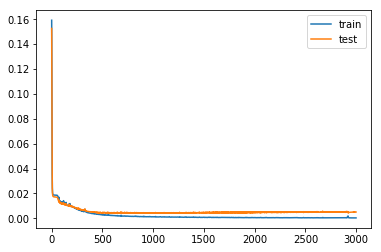

In [213]:
n_cells = 2
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cells'+str(n_cells)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad_2.fit(x_train, y_train, epochs=3000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3 LSTM Cells

In [215]:
# design network: 3 stacked LSTM Cells + 1 fully connected layer
modelLoad_3 = Sequential()
modelLoad_3.add(LSTM(timesteps, return_sequences=True, input_shape=input_shape))
modelLoad_3.add(LSTM(timesteps, return_sequences=True))
modelLoad_3.add(LSTM(timesteps))
modelLoad_3.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad_3.summary())

# compilation
modelLoad_3.compile(loss='mean_squared_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 24)            2976      
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_11 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
Total params: 12,984
Trainable params: 12,984
Non-trainable params: 0
_________________________________________________________________
None


Train on 282 samples, validate on 84 samples
Epoch 1/3000
Epoch 00000: val_loss improved from inf to 0.14602, saving model to saved_models/weights.best.cells3.hdf5
1s - loss: 0.1553 - val_loss: 0.1460
Epoch 2/3000
Epoch 00001: val_loss improved from 0.14602 to 0.11575, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.1341 - val_loss: 0.1158
Epoch 3/3000
Epoch 00002: val_loss improved from 0.11575 to 0.08629, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.1030 - val_loss: 0.0863
Epoch 4/3000
Epoch 00003: val_loss improved from 0.08629 to 0.06292, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0765 - val_loss: 0.0629
Epoch 5/3000
Epoch 00004: val_loss improved from 0.06292 to 0.04427, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0554 - val_loss: 0.0443
Epoch 6/3000
Epoch 00005: val_loss improved from 0.04427 to 0.03128, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0394 - val_loss: 0.0313

Epoch 00061: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 63/3000
Epoch 00062: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 64/3000
Epoch 00063: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 65/3000
Epoch 00064: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 66/3000
Epoch 00065: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 67/3000
Epoch 00066: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 68/3000
Epoch 00067: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 69/3000
Epoch 00068: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 70/3000
Epoch 00069: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 71/3000
Epoch 00070: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 72/3000
Epoch 00071: val_loss did not improve
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 73/3000
Epoch 00072: val_loss

Epoch 00137: val_loss improved from 0.01712 to 0.01711, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 139/3000
Epoch 00138: val_loss improved from 0.01711 to 0.01710, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 140/3000
Epoch 00139: val_loss improved from 0.01710 to 0.01709, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 141/3000
Epoch 00140: val_loss improved from 0.01709 to 0.01708, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 142/3000
Epoch 00141: val_loss improved from 0.01708 to 0.01707, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 143/3000
Epoch 00142: val_loss improved from 0.01707 to 0.01705, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0186 - val_loss: 0.0171
Epoch 144/3000
Epoch 00143: val_loss improv

Epoch 00201: val_loss did not improve
0s - loss: 0.0130 - val_loss: 0.0115
Epoch 203/3000
Epoch 00202: val_loss did not improve
0s - loss: 0.0124 - val_loss: 0.0112
Epoch 204/3000
Epoch 00203: val_loss improved from 0.01114 to 0.01100, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0121 - val_loss: 0.0110
Epoch 205/3000
Epoch 00204: val_loss improved from 0.01100 to 0.01089, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0119 - val_loss: 0.0109
Epoch 206/3000
Epoch 00205: val_loss improved from 0.01089 to 0.01084, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0117 - val_loss: 0.0108
Epoch 207/3000
Epoch 00206: val_loss improved from 0.01084 to 0.01078, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0116 - val_loss: 0.0108
Epoch 208/3000
Epoch 00207: val_loss improved from 0.01078 to 0.01072, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0116 - val_loss: 0.0107
Epoch 209/3000
Epoch 0020

Epoch 00272: val_loss did not improve
0s - loss: 0.0094 - val_loss: 0.0092
Epoch 274/3000
Epoch 00273: val_loss did not improve
0s - loss: 0.0096 - val_loss: 0.0096
Epoch 275/3000
Epoch 00274: val_loss improved from 0.00890 to 0.00888, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0095 - val_loss: 0.0089
Epoch 276/3000
Epoch 00275: val_loss did not improve
0s - loss: 0.0094 - val_loss: 0.0090
Epoch 277/3000
Epoch 00276: val_loss did not improve
0s - loss: 0.0096 - val_loss: 0.0092
Epoch 278/3000
Epoch 00277: val_loss did not improve
0s - loss: 0.0094 - val_loss: 0.0091
Epoch 279/3000
Epoch 00278: val_loss did not improve
0s - loss: 0.0093 - val_loss: 0.0091
Epoch 280/3000
Epoch 00279: val_loss improved from 0.00888 to 0.00870, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0091 - val_loss: 0.0087
Epoch 281/3000
Epoch 00280: val_loss improved from 0.00870 to 0.00865, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0090 - val_lo

Epoch 00341: val_loss improved from 0.00651 to 0.00640, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0065 - val_loss: 0.0064
Epoch 343/3000
Epoch 00342: val_loss did not improve
0s - loss: 0.0063 - val_loss: 0.0064
Epoch 344/3000
Epoch 00343: val_loss improved from 0.00640 to 0.00636, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0062 - val_loss: 0.0064
Epoch 345/3000
Epoch 00344: val_loss improved from 0.00636 to 0.00623, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0061 - val_loss: 0.0062
Epoch 346/3000
Epoch 00345: val_loss did not improve
0s - loss: 0.0060 - val_loss: 0.0063
Epoch 347/3000
Epoch 00346: val_loss did not improve
0s - loss: 0.0060 - val_loss: 0.0064
Epoch 348/3000
Epoch 00347: val_loss improved from 0.00623 to 0.00618, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0061 - val_loss: 0.0062
Epoch 349/3000
Epoch 00348: val_loss did not improve
0s - loss: 0.0059 - val_loss: 0.0062
Epoch 3

Epoch 00417: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0055
Epoch 419/3000
Epoch 00418: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 420/3000
Epoch 00419: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0056
Epoch 421/3000
Epoch 00420: val_loss improved from 0.00514 to 0.00512, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 422/3000
Epoch 00421: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0056
Epoch 423/3000
Epoch 00422: val_loss improved from 0.00512 to 0.00509, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0044 - val_loss: 0.0051
Epoch 424/3000
Epoch 00423: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0056
Epoch 425/3000
Epoch 00424: val_loss did not improve
0s - loss: 0.0045 - val_loss: 0.0051
Epoch 426/3000
Epoch 00425: val_loss did not improve
0s - loss: 0.0044 - val_loss: 0.0054
Epoch 427/3000
Epoch 00426: val_loss did not improve
0s - los

Epoch 00497: val_loss improved from 0.00473 to 0.00470, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0033 - val_loss: 0.0047
Epoch 499/3000
Epoch 00498: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0053
Epoch 500/3000
Epoch 00499: val_loss improved from 0.00470 to 0.00462, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0034 - val_loss: 0.0046
Epoch 501/3000
Epoch 00500: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0051
Epoch 502/3000
Epoch 00501: val_loss improved from 0.00462 to 0.00461, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0033 - val_loss: 0.0046
Epoch 503/3000
Epoch 00502: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0051
Epoch 504/3000
Epoch 00503: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0047
Epoch 505/3000
Epoch 00504: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0053
Epoch 506/3000
Epoch 00505: val_loss did not improve
0s - loss: 0.0034 - val_lo

Epoch 00582: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0047
Epoch 584/3000
Epoch 00583: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0045
Epoch 585/3000
Epoch 00584: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0045
Epoch 586/3000
Epoch 00585: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0045
Epoch 587/3000
Epoch 00586: val_loss improved from 0.00442 to 0.00437, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0024 - val_loss: 0.0044
Epoch 588/3000
Epoch 00587: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0046
Epoch 589/3000
Epoch 00588: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0044
Epoch 590/3000
Epoch 00589: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0047
Epoch 591/3000
Epoch 00590: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0045
Epoch 592/3000
Epoch 00591: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0046
Epoch 593/3000
Epoch 00592: val_loss did no

Epoch 00669: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0051
Epoch 671/3000
Epoch 00670: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0047
Epoch 672/3000
Epoch 00671: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0047
Epoch 673/3000
Epoch 00672: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0043
Epoch 674/3000
Epoch 00673: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0042
Epoch 675/3000
Epoch 00674: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0043
Epoch 676/3000
Epoch 00675: val_loss improved from 0.00420 to 0.00417, saving model to saved_models/weights.best.cells3.hdf5
0s - loss: 0.0019 - val_loss: 0.0042
Epoch 677/3000
Epoch 00676: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0043
Epoch 678/3000
Epoch 00677: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0043
Epoch 679/3000
Epoch 00678: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0042
Epoch 680/3000
Epoch 00679: val_loss did no

Epoch 00758: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 760/3000
Epoch 00759: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0044
Epoch 761/3000
Epoch 00760: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0044
Epoch 762/3000
Epoch 00761: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 763/3000
Epoch 00762: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0044
Epoch 764/3000
Epoch 00763: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 765/3000
Epoch 00764: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 766/3000
Epoch 00765: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0044
Epoch 767/3000
Epoch 00766: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 768/3000
Epoch 00767: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0045
Epoch 769/3000
Epoch 00768: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0043
Epoch 770/3000
Epoch 0076

Epoch 00850: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0046
Epoch 852/3000
Epoch 00851: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0046
Epoch 853/3000
Epoch 00852: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0045
Epoch 854/3000
Epoch 00853: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0044
Epoch 855/3000
Epoch 00854: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0047
Epoch 856/3000
Epoch 00855: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0045
Epoch 857/3000
Epoch 00856: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0048
Epoch 858/3000
Epoch 00857: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0045
Epoch 859/3000
Epoch 00858: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0045
Epoch 860/3000
Epoch 00859: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0047
Epoch 861/3000
Epoch 00860: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0045
Epoch 862/3000
Epoch 0086

Epoch 00942: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0047
Epoch 944/3000
Epoch 00943: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0046
Epoch 945/3000
Epoch 00944: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0044
Epoch 946/3000
Epoch 00945: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0049
Epoch 947/3000
Epoch 00946: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0046
Epoch 948/3000
Epoch 00947: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0049
Epoch 949/3000
Epoch 00948: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0047
Epoch 950/3000
Epoch 00949: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0049
Epoch 951/3000
Epoch 00950: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0044
Epoch 952/3000
Epoch 00951: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0046
Epoch 953/3000
Epoch 00952: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0046
Epoch 954/3000
Epoch 0095

Epoch 01031: val_loss did not improve
0s - loss: 9.0398e-04 - val_loss: 0.0047
Epoch 1033/3000
Epoch 01032: val_loss did not improve
0s - loss: 9.0154e-04 - val_loss: 0.0046
Epoch 1034/3000
Epoch 01033: val_loss did not improve
0s - loss: 9.1458e-04 - val_loss: 0.0047
Epoch 1035/3000
Epoch 01034: val_loss did not improve
0s - loss: 9.1259e-04 - val_loss: 0.0046
Epoch 1036/3000
Epoch 01035: val_loss did not improve
0s - loss: 9.2779e-04 - val_loss: 0.0047
Epoch 1037/3000
Epoch 01036: val_loss did not improve
0s - loss: 9.1526e-04 - val_loss: 0.0046
Epoch 1038/3000
Epoch 01037: val_loss did not improve
0s - loss: 9.2239e-04 - val_loss: 0.0047
Epoch 1039/3000
Epoch 01038: val_loss did not improve
0s - loss: 9.1263e-04 - val_loss: 0.0046
Epoch 1040/3000
Epoch 01039: val_loss did not improve
0s - loss: 9.3061e-04 - val_loss: 0.0048
Epoch 1041/3000
Epoch 01040: val_loss did not improve
0s - loss: 9.4009e-04 - val_loss: 0.0046
Epoch 1042/3000
Epoch 01041: val_loss did not improve
0s - loss: 9

Epoch 01118: val_loss did not improve
0s - loss: 8.2541e-04 - val_loss: 0.0047
Epoch 1120/3000
Epoch 01119: val_loss did not improve
0s - loss: 8.3595e-04 - val_loss: 0.0049
Epoch 1121/3000
Epoch 01120: val_loss did not improve
0s - loss: 8.5058e-04 - val_loss: 0.0047
Epoch 1122/3000
Epoch 01121: val_loss did not improve
0s - loss: 8.3205e-04 - val_loss: 0.0047
Epoch 1123/3000
Epoch 01122: val_loss did not improve
0s - loss: 7.9933e-04 - val_loss: 0.0049
Epoch 1124/3000
Epoch 01123: val_loss did not improve
0s - loss: 8.0058e-04 - val_loss: 0.0047
Epoch 1125/3000
Epoch 01124: val_loss did not improve
0s - loss: 7.9666e-04 - val_loss: 0.0048
Epoch 1126/3000
Epoch 01125: val_loss did not improve
0s - loss: 7.8422e-04 - val_loss: 0.0047
Epoch 1127/3000
Epoch 01126: val_loss did not improve
0s - loss: 7.6660e-04 - val_loss: 0.0047
Epoch 1128/3000
Epoch 01127: val_loss did not improve
0s - loss: 7.7378e-04 - val_loss: 0.0049
Epoch 1129/3000
Epoch 01128: val_loss did not improve
0s - loss: 7

Epoch 01205: val_loss did not improve
0s - loss: 7.2510e-04 - val_loss: 0.0049
Epoch 1207/3000
Epoch 01206: val_loss did not improve
0s - loss: 7.1477e-04 - val_loss: 0.0048
Epoch 1208/3000
Epoch 01207: val_loss did not improve
0s - loss: 7.5365e-04 - val_loss: 0.0053
Epoch 1209/3000
Epoch 01208: val_loss did not improve
0s - loss: 8.1816e-04 - val_loss: 0.0048
Epoch 1210/3000
Epoch 01209: val_loss did not improve
0s - loss: 8.6805e-04 - val_loss: 0.0052
Epoch 1211/3000
Epoch 01210: val_loss did not improve
0s - loss: 8.0932e-04 - val_loss: 0.0049
Epoch 1212/3000
Epoch 01211: val_loss did not improve
0s - loss: 7.6631e-04 - val_loss: 0.0050
Epoch 1213/3000
Epoch 01212: val_loss did not improve
0s - loss: 7.5157e-04 - val_loss: 0.0050
Epoch 1214/3000
Epoch 01213: val_loss did not improve
0s - loss: 7.6678e-04 - val_loss: 0.0047
Epoch 1215/3000
Epoch 01214: val_loss did not improve
0s - loss: 7.5094e-04 - val_loss: 0.0052
Epoch 1216/3000
Epoch 01215: val_loss did not improve
0s - loss: 7

Epoch 01292: val_loss did not improve
0s - loss: 6.9442e-04 - val_loss: 0.0052
Epoch 1294/3000
Epoch 01293: val_loss did not improve
0s - loss: 6.7421e-04 - val_loss: 0.0049
Epoch 1295/3000
Epoch 01294: val_loss did not improve
0s - loss: 6.6068e-04 - val_loss: 0.0050
Epoch 1296/3000
Epoch 01295: val_loss did not improve
0s - loss: 6.3010e-04 - val_loss: 0.0050
Epoch 1297/3000
Epoch 01296: val_loss did not improve
0s - loss: 6.2929e-04 - val_loss: 0.0048
Epoch 1298/3000
Epoch 01297: val_loss did not improve
0s - loss: 6.9498e-04 - val_loss: 0.0054
Epoch 1299/3000
Epoch 01298: val_loss did not improve
0s - loss: 7.1916e-04 - val_loss: 0.0049
Epoch 1300/3000
Epoch 01299: val_loss did not improve
0s - loss: 7.4393e-04 - val_loss: 0.0052
Epoch 1301/3000
Epoch 01300: val_loss did not improve
0s - loss: 7.1232e-04 - val_loss: 0.0050
Epoch 1302/3000
Epoch 01301: val_loss did not improve
0s - loss: 6.9220e-04 - val_loss: 0.0050
Epoch 1303/3000
Epoch 01302: val_loss did not improve
0s - loss: 6

Epoch 01379: val_loss did not improve
0s - loss: 5.5708e-04 - val_loss: 0.0052
Epoch 1381/3000
Epoch 01380: val_loss did not improve
0s - loss: 5.7074e-04 - val_loss: 0.0050
Epoch 1382/3000
Epoch 01381: val_loss did not improve
0s - loss: 5.8510e-04 - val_loss: 0.0052
Epoch 1383/3000
Epoch 01382: val_loss did not improve
0s - loss: 5.8657e-04 - val_loss: 0.0051
Epoch 1384/3000
Epoch 01383: val_loss did not improve
0s - loss: 5.8213e-04 - val_loss: 0.0049
Epoch 1385/3000
Epoch 01384: val_loss did not improve
0s - loss: 6.1037e-04 - val_loss: 0.0054
Epoch 1386/3000
Epoch 01385: val_loss did not improve
0s - loss: 6.1850e-04 - val_loss: 0.0048
Epoch 1387/3000
Epoch 01386: val_loss did not improve
0s - loss: 6.3333e-04 - val_loss: 0.0053
Epoch 1388/3000
Epoch 01387: val_loss did not improve
0s - loss: 6.1496e-04 - val_loss: 0.0051
Epoch 1389/3000
Epoch 01388: val_loss did not improve
0s - loss: 6.1239e-04 - val_loss: 0.0050
Epoch 1390/3000
Epoch 01389: val_loss did not improve
0s - loss: 6

Epoch 01466: val_loss did not improve
0s - loss: 5.5040e-04 - val_loss: 0.0051
Epoch 1468/3000
Epoch 01467: val_loss did not improve
0s - loss: 5.3281e-04 - val_loss: 0.0050
Epoch 1469/3000
Epoch 01468: val_loss did not improve
0s - loss: 5.2740e-04 - val_loss: 0.0053
Epoch 1470/3000
Epoch 01469: val_loss did not improve
0s - loss: 5.2367e-04 - val_loss: 0.0050
Epoch 1471/3000
Epoch 01470: val_loss did not improve
0s - loss: 5.4861e-04 - val_loss: 0.0054
Epoch 1472/3000
Epoch 01471: val_loss did not improve
0s - loss: 5.3998e-04 - val_loss: 0.0051
Epoch 1473/3000
Epoch 01472: val_loss did not improve
0s - loss: 5.3409e-04 - val_loss: 0.0050
Epoch 1474/3000
Epoch 01473: val_loss did not improve
0s - loss: 5.2923e-04 - val_loss: 0.0053
Epoch 1475/3000
Epoch 01474: val_loss did not improve
0s - loss: 5.2769e-04 - val_loss: 0.0050
Epoch 1476/3000
Epoch 01475: val_loss did not improve
0s - loss: 5.3827e-04 - val_loss: 0.0053
Epoch 1477/3000
Epoch 01476: val_loss did not improve
0s - loss: 5

Epoch 01553: val_loss did not improve
0s - loss: 4.9171e-04 - val_loss: 0.0050
Epoch 1555/3000
Epoch 01554: val_loss did not improve
0s - loss: 4.6831e-04 - val_loss: 0.0051
Epoch 1556/3000
Epoch 01555: val_loss did not improve
0s - loss: 4.5462e-04 - val_loss: 0.0052
Epoch 1557/3000
Epoch 01556: val_loss did not improve
0s - loss: 4.6162e-04 - val_loss: 0.0051
Epoch 1558/3000
Epoch 01557: val_loss did not improve
0s - loss: 4.7307e-04 - val_loss: 0.0052
Epoch 1559/3000
Epoch 01558: val_loss did not improve
0s - loss: 4.8976e-04 - val_loss: 0.0052
Epoch 1560/3000
Epoch 01559: val_loss did not improve
0s - loss: 5.0588e-04 - val_loss: 0.0051
Epoch 1561/3000
Epoch 01560: val_loss did not improve
0s - loss: 5.0327e-04 - val_loss: 0.0053
Epoch 1562/3000
Epoch 01561: val_loss did not improve
0s - loss: 5.0454e-04 - val_loss: 0.0051
Epoch 1563/3000
Epoch 01562: val_loss did not improve
0s - loss: 5.0724e-04 - val_loss: 0.0052
Epoch 1564/3000
Epoch 01563: val_loss did not improve
0s - loss: 5

Epoch 01640: val_loss did not improve
0s - loss: 5.1011e-04 - val_loss: 0.0051
Epoch 1642/3000
Epoch 01641: val_loss did not improve
0s - loss: 5.3867e-04 - val_loss: 0.0051
Epoch 1643/3000
Epoch 01642: val_loss did not improve
0s - loss: 5.3979e-04 - val_loss: 0.0052
Epoch 1644/3000
Epoch 01643: val_loss did not improve
0s - loss: 5.2091e-04 - val_loss: 0.0051
Epoch 1645/3000
Epoch 01644: val_loss did not improve
0s - loss: 4.8195e-04 - val_loss: 0.0050
Epoch 1646/3000
Epoch 01645: val_loss did not improve
0s - loss: 4.8053e-04 - val_loss: 0.0053
Epoch 1647/3000
Epoch 01646: val_loss did not improve
0s - loss: 4.8804e-04 - val_loss: 0.0049
Epoch 1648/3000
Epoch 01647: val_loss did not improve
0s - loss: 4.9541e-04 - val_loss: 0.0052
Epoch 1649/3000
Epoch 01648: val_loss did not improve
0s - loss: 4.7106e-04 - val_loss: 0.0050
Epoch 1650/3000
Epoch 01649: val_loss did not improve
0s - loss: 4.4809e-04 - val_loss: 0.0050
Epoch 1651/3000
Epoch 01650: val_loss did not improve
0s - loss: 4

Epoch 01727: val_loss did not improve
0s - loss: 3.9425e-04 - val_loss: 0.0048
Epoch 1729/3000
Epoch 01728: val_loss did not improve
0s - loss: 3.9254e-04 - val_loss: 0.0048
Epoch 1730/3000
Epoch 01729: val_loss did not improve
0s - loss: 3.9124e-04 - val_loss: 0.0048
Epoch 1731/3000
Epoch 01730: val_loss did not improve
0s - loss: 3.8979e-04 - val_loss: 0.0049
Epoch 1732/3000
Epoch 01731: val_loss did not improve
0s - loss: 3.8841e-04 - val_loss: 0.0049
Epoch 1733/3000
Epoch 01732: val_loss did not improve
0s - loss: 3.8728e-04 - val_loss: 0.0049
Epoch 1734/3000
Epoch 01733: val_loss did not improve
0s - loss: 3.8580e-04 - val_loss: 0.0049
Epoch 1735/3000
Epoch 01734: val_loss did not improve
0s - loss: 3.8477e-04 - val_loss: 0.0049
Epoch 1736/3000
Epoch 01735: val_loss did not improve
0s - loss: 3.8367e-04 - val_loss: 0.0049
Epoch 1737/3000
Epoch 01736: val_loss did not improve
0s - loss: 3.8242e-04 - val_loss: 0.0049
Epoch 1738/3000
Epoch 01737: val_loss did not improve
0s - loss: 3

Epoch 01814: val_loss did not improve
0s - loss: 3.8689e-04 - val_loss: 0.0051
Epoch 1816/3000
Epoch 01815: val_loss did not improve
0s - loss: 3.9454e-04 - val_loss: 0.0051
Epoch 1817/3000
Epoch 01816: val_loss did not improve
0s - loss: 4.0197e-04 - val_loss: 0.0051
Epoch 1818/3000
Epoch 01817: val_loss did not improve
0s - loss: 4.1002e-04 - val_loss: 0.0052
Epoch 1819/3000
Epoch 01818: val_loss did not improve
0s - loss: 4.0464e-04 - val_loss: 0.0050
Epoch 1820/3000
Epoch 01819: val_loss did not improve
0s - loss: 4.0760e-04 - val_loss: 0.0053
Epoch 1821/3000
Epoch 01820: val_loss did not improve
0s - loss: 4.0117e-04 - val_loss: 0.0049
Epoch 1822/3000
Epoch 01821: val_loss did not improve
0s - loss: 3.9849e-04 - val_loss: 0.0052
Epoch 1823/3000
Epoch 01822: val_loss did not improve
0s - loss: 3.9013e-04 - val_loss: 0.0051
Epoch 1824/3000
Epoch 01823: val_loss did not improve
0s - loss: 3.8646e-04 - val_loss: 0.0050
Epoch 1825/3000
Epoch 01824: val_loss did not improve
0s - loss: 3

Epoch 01901: val_loss did not improve
0s - loss: 4.0008e-04 - val_loss: 0.0050
Epoch 1903/3000
Epoch 01902: val_loss did not improve
0s - loss: 3.9260e-04 - val_loss: 0.0052
Epoch 1904/3000
Epoch 01903: val_loss did not improve
0s - loss: 3.9054e-04 - val_loss: 0.0053
Epoch 1905/3000
Epoch 01904: val_loss did not improve
0s - loss: 4.0603e-04 - val_loss: 0.0050
Epoch 1906/3000
Epoch 01905: val_loss did not improve
0s - loss: 4.5293e-04 - val_loss: 0.0056
Epoch 1907/3000
Epoch 01906: val_loss did not improve
0s - loss: 4.7815e-04 - val_loss: 0.0050
Epoch 1908/3000
Epoch 01907: val_loss did not improve
0s - loss: 4.6168e-04 - val_loss: 0.0053
Epoch 1909/3000
Epoch 01908: val_loss did not improve
0s - loss: 4.0849e-04 - val_loss: 0.0051
Epoch 1910/3000
Epoch 01909: val_loss did not improve
0s - loss: 3.8963e-04 - val_loss: 0.0052
Epoch 1911/3000
Epoch 01910: val_loss did not improve
0s - loss: 3.8468e-04 - val_loss: 0.0052
Epoch 1912/3000
Epoch 01911: val_loss did not improve
0s - loss: 3

Epoch 01988: val_loss did not improve
0s - loss: 3.8099e-04 - val_loss: 0.0053
Epoch 1990/3000
Epoch 01989: val_loss did not improve
0s - loss: 3.7552e-04 - val_loss: 0.0053
Epoch 1991/3000
Epoch 01990: val_loss did not improve
0s - loss: 3.9369e-04 - val_loss: 0.0052
Epoch 1992/3000
Epoch 01991: val_loss did not improve
0s - loss: 4.2436e-04 - val_loss: 0.0054
Epoch 1993/3000
Epoch 01992: val_loss did not improve
0s - loss: 4.3565e-04 - val_loss: 0.0051
Epoch 1994/3000
Epoch 01993: val_loss did not improve
0s - loss: 4.1304e-04 - val_loss: 0.0053
Epoch 1995/3000
Epoch 01994: val_loss did not improve
0s - loss: 4.0046e-04 - val_loss: 0.0052
Epoch 1996/3000
Epoch 01995: val_loss did not improve
0s - loss: 3.8936e-04 - val_loss: 0.0052
Epoch 1997/3000
Epoch 01996: val_loss did not improve
0s - loss: 3.7645e-04 - val_loss: 0.0053
Epoch 1998/3000
Epoch 01997: val_loss did not improve
0s - loss: 3.6279e-04 - val_loss: 0.0052
Epoch 1999/3000
Epoch 01998: val_loss did not improve
0s - loss: 3

Epoch 02075: val_loss did not improve
0s - loss: 2.8910e-04 - val_loss: 0.0052
Epoch 2077/3000
Epoch 02076: val_loss did not improve
0s - loss: 2.8898e-04 - val_loss: 0.0052
Epoch 2078/3000
Epoch 02077: val_loss did not improve
0s - loss: 2.8971e-04 - val_loss: 0.0052
Epoch 2079/3000
Epoch 02078: val_loss did not improve
0s - loss: 2.9103e-04 - val_loss: 0.0052
Epoch 2080/3000
Epoch 02079: val_loss did not improve
0s - loss: 2.9279e-04 - val_loss: 0.0052
Epoch 2081/3000
Epoch 02080: val_loss did not improve
0s - loss: 2.9310e-04 - val_loss: 0.0052
Epoch 2082/3000
Epoch 02081: val_loss did not improve
0s - loss: 2.9595e-04 - val_loss: 0.0052
Epoch 2083/3000
Epoch 02082: val_loss did not improve
0s - loss: 3.0340e-04 - val_loss: 0.0052
Epoch 2084/3000
Epoch 02083: val_loss did not improve
0s - loss: 3.1036e-04 - val_loss: 0.0052
Epoch 2085/3000
Epoch 02084: val_loss did not improve
0s - loss: 3.1452e-04 - val_loss: 0.0052
Epoch 2086/3000
Epoch 02085: val_loss did not improve
0s - loss: 3

Epoch 02162: val_loss did not improve
0s - loss: 3.5054e-04 - val_loss: 0.0054
Epoch 2164/3000
Epoch 02163: val_loss did not improve
0s - loss: 3.6013e-04 - val_loss: 0.0053
Epoch 2165/3000
Epoch 02164: val_loss did not improve
0s - loss: 3.5923e-04 - val_loss: 0.0053
Epoch 2166/3000
Epoch 02165: val_loss did not improve
0s - loss: 3.5466e-04 - val_loss: 0.0054
Epoch 2167/3000
Epoch 02166: val_loss did not improve
0s - loss: 3.6700e-04 - val_loss: 0.0052
Epoch 2168/3000
Epoch 02167: val_loss did not improve
0s - loss: 3.7899e-04 - val_loss: 0.0054
Epoch 2169/3000
Epoch 02168: val_loss did not improve
0s - loss: 3.8035e-04 - val_loss: 0.0053
Epoch 2170/3000
Epoch 02169: val_loss did not improve
0s - loss: 3.7815e-04 - val_loss: 0.0052
Epoch 2171/3000
Epoch 02170: val_loss did not improve
0s - loss: 3.7038e-04 - val_loss: 0.0053
Epoch 2172/3000
Epoch 02171: val_loss did not improve
0s - loss: 3.5788e-04 - val_loss: 0.0053
Epoch 2173/3000
Epoch 02172: val_loss did not improve
0s - loss: 3

Epoch 02249: val_loss did not improve
0s - loss: 3.5449e-04 - val_loss: 0.0053
Epoch 2251/3000
Epoch 02250: val_loss did not improve
0s - loss: 3.3863e-04 - val_loss: 0.0053
Epoch 2252/3000
Epoch 02251: val_loss did not improve
0s - loss: 3.2403e-04 - val_loss: 0.0053
Epoch 2253/3000
Epoch 02252: val_loss did not improve
0s - loss: 3.1410e-04 - val_loss: 0.0053
Epoch 2254/3000
Epoch 02253: val_loss did not improve
0s - loss: 3.0274e-04 - val_loss: 0.0052
Epoch 2255/3000
Epoch 02254: val_loss did not improve
0s - loss: 2.9836e-04 - val_loss: 0.0053
Epoch 2256/3000
Epoch 02255: val_loss did not improve
0s - loss: 3.0693e-04 - val_loss: 0.0053
Epoch 2257/3000
Epoch 02256: val_loss did not improve
0s - loss: 3.1132e-04 - val_loss: 0.0053
Epoch 2258/3000
Epoch 02257: val_loss did not improve
0s - loss: 3.0452e-04 - val_loss: 0.0053
Epoch 2259/3000
Epoch 02258: val_loss did not improve
0s - loss: 3.0355e-04 - val_loss: 0.0054
Epoch 2260/3000
Epoch 02259: val_loss did not improve
0s - loss: 3

Epoch 02336: val_loss did not improve
0s - loss: 3.1970e-04 - val_loss: 0.0054
Epoch 2338/3000
Epoch 02337: val_loss did not improve
0s - loss: 3.3855e-04 - val_loss: 0.0053
Epoch 2339/3000
Epoch 02338: val_loss did not improve
0s - loss: 3.3885e-04 - val_loss: 0.0055
Epoch 2340/3000
Epoch 02339: val_loss did not improve
0s - loss: 3.2932e-04 - val_loss: 0.0052
Epoch 2341/3000
Epoch 02340: val_loss did not improve
0s - loss: 3.1319e-04 - val_loss: 0.0055
Epoch 2342/3000
Epoch 02341: val_loss did not improve
0s - loss: 3.0435e-04 - val_loss: 0.0053
Epoch 2343/3000
Epoch 02342: val_loss did not improve
0s - loss: 3.0467e-04 - val_loss: 0.0054
Epoch 2344/3000
Epoch 02343: val_loss did not improve
0s - loss: 3.0201e-04 - val_loss: 0.0054
Epoch 2345/3000
Epoch 02344: val_loss did not improve
0s - loss: 2.9990e-04 - val_loss: 0.0055
Epoch 2346/3000
Epoch 02345: val_loss did not improve
0s - loss: 2.9680e-04 - val_loss: 0.0052
Epoch 2347/3000
Epoch 02346: val_loss did not improve
0s - loss: 3

Epoch 02423: val_loss did not improve
0s - loss: 2.9281e-04 - val_loss: 0.0054
Epoch 2425/3000
Epoch 02424: val_loss did not improve
0s - loss: 2.9081e-04 - val_loss: 0.0055
Epoch 2426/3000
Epoch 02425: val_loss did not improve
0s - loss: 2.7714e-04 - val_loss: 0.0055
Epoch 2427/3000
Epoch 02426: val_loss did not improve
0s - loss: 2.7467e-04 - val_loss: 0.0053
Epoch 2428/3000
Epoch 02427: val_loss did not improve
0s - loss: 3.0114e-04 - val_loss: 0.0058
Epoch 2429/3000
Epoch 02428: val_loss did not improve
0s - loss: 3.3345e-04 - val_loss: 0.0052
Epoch 2430/3000
Epoch 02429: val_loss did not improve
0s - loss: 3.4611e-04 - val_loss: 0.0056
Epoch 2431/3000
Epoch 02430: val_loss did not improve
0s - loss: 3.4239e-04 - val_loss: 0.0055
Epoch 2432/3000
Epoch 02431: val_loss did not improve
0s - loss: 3.9051e-04 - val_loss: 0.0053
Epoch 2433/3000
Epoch 02432: val_loss did not improve
0s - loss: 5.5335e-04 - val_loss: 0.0059
Epoch 2434/3000
Epoch 02433: val_loss did not improve
0s - loss: 5

Epoch 02510: val_loss did not improve
0s - loss: 2.9773e-04 - val_loss: 0.0055
Epoch 2512/3000
Epoch 02511: val_loss did not improve
0s - loss: 2.9375e-04 - val_loss: 0.0055
Epoch 2513/3000
Epoch 02512: val_loss did not improve
0s - loss: 2.7241e-04 - val_loss: 0.0055
Epoch 2514/3000
Epoch 02513: val_loss did not improve
0s - loss: 2.6802e-04 - val_loss: 0.0055
Epoch 2515/3000
Epoch 02514: val_loss did not improve
0s - loss: 2.6619e-04 - val_loss: 0.0054
Epoch 2516/3000
Epoch 02515: val_loss did not improve
0s - loss: 2.7287e-04 - val_loss: 0.0056
Epoch 2517/3000
Epoch 02516: val_loss did not improve
0s - loss: 2.7110e-04 - val_loss: 0.0054
Epoch 2518/3000
Epoch 02517: val_loss did not improve
0s - loss: 2.6768e-04 - val_loss: 0.0055
Epoch 2519/3000
Epoch 02518: val_loss did not improve
0s - loss: 2.6167e-04 - val_loss: 0.0056
Epoch 2520/3000
Epoch 02519: val_loss did not improve
0s - loss: 2.6824e-04 - val_loss: 0.0054
Epoch 2521/3000
Epoch 02520: val_loss did not improve
0s - loss: 2

Epoch 02597: val_loss did not improve
0s - loss: 2.2549e-04 - val_loss: 0.0056
Epoch 2599/3000
Epoch 02598: val_loss did not improve
0s - loss: 2.2799e-04 - val_loss: 0.0056
Epoch 2600/3000
Epoch 02599: val_loss did not improve
0s - loss: 2.3251e-04 - val_loss: 0.0057
Epoch 2601/3000
Epoch 02600: val_loss did not improve
0s - loss: 2.3334e-04 - val_loss: 0.0055
Epoch 2602/3000
Epoch 02601: val_loss did not improve
0s - loss: 2.3491e-04 - val_loss: 0.0057
Epoch 2603/3000
Epoch 02602: val_loss did not improve
0s - loss: 2.3385e-04 - val_loss: 0.0055
Epoch 2604/3000
Epoch 02603: val_loss did not improve
0s - loss: 2.3314e-04 - val_loss: 0.0057
Epoch 2605/3000
Epoch 02604: val_loss did not improve
0s - loss: 2.3267e-04 - val_loss: 0.0055
Epoch 2606/3000
Epoch 02605: val_loss did not improve
0s - loss: 2.3307e-04 - val_loss: 0.0057
Epoch 2607/3000
Epoch 02606: val_loss did not improve
0s - loss: 2.3302e-04 - val_loss: 0.0056
Epoch 2608/3000
Epoch 02607: val_loss did not improve
0s - loss: 2

Epoch 02684: val_loss did not improve
0s - loss: 2.0406e-04 - val_loss: 0.0055
Epoch 2686/3000
Epoch 02685: val_loss did not improve
0s - loss: 2.0369e-04 - val_loss: 0.0055
Epoch 2687/3000
Epoch 02686: val_loss did not improve
0s - loss: 2.0334e-04 - val_loss: 0.0055
Epoch 2688/3000
Epoch 02687: val_loss did not improve
0s - loss: 2.0226e-04 - val_loss: 0.0055
Epoch 2689/3000
Epoch 02688: val_loss did not improve
0s - loss: 2.0216e-04 - val_loss: 0.0055
Epoch 2690/3000
Epoch 02689: val_loss did not improve
0s - loss: 2.0190e-04 - val_loss: 0.0055
Epoch 2691/3000
Epoch 02690: val_loss did not improve
0s - loss: 2.0167e-04 - val_loss: 0.0056
Epoch 2692/3000
Epoch 02691: val_loss did not improve
0s - loss: 2.0194e-04 - val_loss: 0.0055
Epoch 2693/3000
Epoch 02692: val_loss did not improve
0s - loss: 2.0164e-04 - val_loss: 0.0056
Epoch 2694/3000
Epoch 02693: val_loss did not improve
0s - loss: 2.0195e-04 - val_loss: 0.0056
Epoch 2695/3000
Epoch 02694: val_loss did not improve
0s - loss: 2

Epoch 02771: val_loss did not improve
0s - loss: 2.2206e-04 - val_loss: 0.0057
Epoch 2773/3000
Epoch 02772: val_loss did not improve
0s - loss: 2.1729e-04 - val_loss: 0.0055
Epoch 2774/3000
Epoch 02773: val_loss did not improve
0s - loss: 2.1690e-04 - val_loss: 0.0057
Epoch 2775/3000
Epoch 02774: val_loss did not improve
0s - loss: 2.1465e-04 - val_loss: 0.0056
Epoch 2776/3000
Epoch 02775: val_loss did not improve
0s - loss: 2.1849e-04 - val_loss: 0.0057
Epoch 2777/3000
Epoch 02776: val_loss did not improve
0s - loss: 2.1530e-04 - val_loss: 0.0056
Epoch 2778/3000
Epoch 02777: val_loss did not improve
0s - loss: 2.1712e-04 - val_loss: 0.0057
Epoch 2779/3000
Epoch 02778: val_loss did not improve
0s - loss: 2.2556e-04 - val_loss: 0.0057
Epoch 2780/3000
Epoch 02779: val_loss did not improve
0s - loss: 2.3333e-04 - val_loss: 0.0055
Epoch 2781/3000
Epoch 02780: val_loss did not improve
0s - loss: 2.3237e-04 - val_loss: 0.0057
Epoch 2782/3000
Epoch 02781: val_loss did not improve
0s - loss: 2

Epoch 02858: val_loss did not improve
0s - loss: 2.4951e-04 - val_loss: 0.0056
Epoch 2860/3000
Epoch 02859: val_loss did not improve
0s - loss: 2.5532e-04 - val_loss: 0.0058
Epoch 2861/3000
Epoch 02860: val_loss did not improve
0s - loss: 2.5144e-04 - val_loss: 0.0056
Epoch 2862/3000
Epoch 02861: val_loss did not improve
0s - loss: 2.5756e-04 - val_loss: 0.0057
Epoch 2863/3000
Epoch 02862: val_loss did not improve
0s - loss: 2.7038e-04 - val_loss: 0.0059
Epoch 2864/3000
Epoch 02863: val_loss did not improve
0s - loss: 2.7310e-04 - val_loss: 0.0055
Epoch 2865/3000
Epoch 02864: val_loss did not improve
0s - loss: 2.6700e-04 - val_loss: 0.0057
Epoch 2866/3000
Epoch 02865: val_loss did not improve
0s - loss: 2.5555e-04 - val_loss: 0.0058
Epoch 2867/3000
Epoch 02866: val_loss did not improve
0s - loss: 2.5797e-04 - val_loss: 0.0055
Epoch 2868/3000
Epoch 02867: val_loss did not improve
0s - loss: 2.7227e-04 - val_loss: 0.0059
Epoch 2869/3000
Epoch 02868: val_loss did not improve
0s - loss: 2

Epoch 02945: val_loss did not improve
0s - loss: 1.8152e-04 - val_loss: 0.0056
Epoch 2947/3000
Epoch 02946: val_loss did not improve
0s - loss: 1.8118e-04 - val_loss: 0.0056
Epoch 2948/3000
Epoch 02947: val_loss did not improve
0s - loss: 1.8083e-04 - val_loss: 0.0056
Epoch 2949/3000
Epoch 02948: val_loss did not improve
0s - loss: 1.8049e-04 - val_loss: 0.0056
Epoch 2950/3000
Epoch 02949: val_loss did not improve
0s - loss: 1.8018e-04 - val_loss: 0.0056
Epoch 2951/3000
Epoch 02950: val_loss did not improve
0s - loss: 1.7984e-04 - val_loss: 0.0056
Epoch 2952/3000
Epoch 02951: val_loss did not improve
0s - loss: 1.7956e-04 - val_loss: 0.0056
Epoch 2953/3000
Epoch 02952: val_loss did not improve
0s - loss: 1.7925e-04 - val_loss: 0.0057
Epoch 2954/3000
Epoch 02953: val_loss did not improve
0s - loss: 1.7897e-04 - val_loss: 0.0057
Epoch 2955/3000
Epoch 02954: val_loss did not improve
0s - loss: 1.7868e-04 - val_loss: 0.0057
Epoch 2956/3000
Epoch 02955: val_loss did not improve
0s - loss: 1

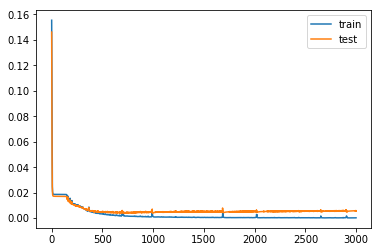

In [216]:
n_cells = 3
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cells'+str(n_cells)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad_3.fit(x_train, y_train, epochs=3000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Based MSE values on the validation set for each of the models:
- 1 LSTM Cell: 0.00261
- 2 LSTM Cell: 0.00424
- 3 LSTM Cell: 0.00453

We select model 1 as the best model both for model's simplicity and best performance on the validation set.

### Model Evaluation

In [46]:
n_cells = 1
# reload parameters
modelLoad_1.load_weights('saved_models/weights.best.cells'+str(n_cells)+'.hdf5')

In [47]:
y_test_pred = modelLoad_1.predict(x_test)
evaluate_model(y_test_pred.reshape(-1), y_test.reshape(-1))


Mean Square Error: 0.004137
Mean Absolute Error: 0.038083


In [48]:
# evaluate model with rescaled values
y_test_pred = scalerOutput.inverse_transform(y_test_pred)
evaluate_model(y_test_pred.reshape(-1), data_test.as_matrix().reshape(-1))

Mean Square Error: 1.847166
Mean Absolute Error: 0.851032


"\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6), sharey=True)\naxes[0, 0].boxplot(mse_test)\naxes[0, 0].set_title('MSE')\n\naxes[0, 1].boxplot(mae_test)\naxes[0, 1].set_title('MAE')\n"

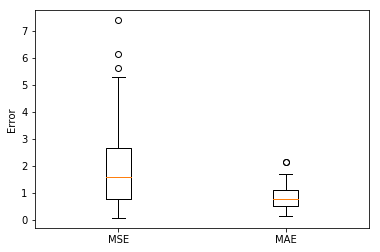

In [50]:
# error distribution across different days
y_test_pred_day = y_test_pred.reshape(-1, 24)
y_test_day = data_test.as_matrix().reshape(-1, 24)

mse_test = []
mae_test = []
for i in range(y_test_day.shape[0]):
    mse_test.append(mean_squared_error(y_test_day[i,:], y_test_pred_day[i,:]))
    mae_test.append(mean_absolute_error(y_test_day[i,:], y_test_pred_day[i,:]))
error_test = [mse_test, mae_test]
plt.figure()
plt.boxplot(error_test)
plt.xticks([1, 2], ['MSE', 'MAE'])
plt.ylabel('Error')


'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6), sharey=True)
axes[0, 0].boxplot(mse_test)
axes[0, 0].set_title('MSE')

axes[0, 1].boxplot(mae_test)
axes[0, 1].set_title('MAE')
'''

## Comparison

In [51]:
loadPred = energyData60[idHouse].copy()
loadReal = energyData60[idHouse].copy()
print(loadPred.loc['2017-01-01':'2017-06-30'].shape)
print(y_test_pred.reshape(-1,1).shape)
loadPred.loc['2017-01-01':'2017-06-30'] = y_test_pred.reshape(-1, 1)

(4344, 1)
(4344, 1)


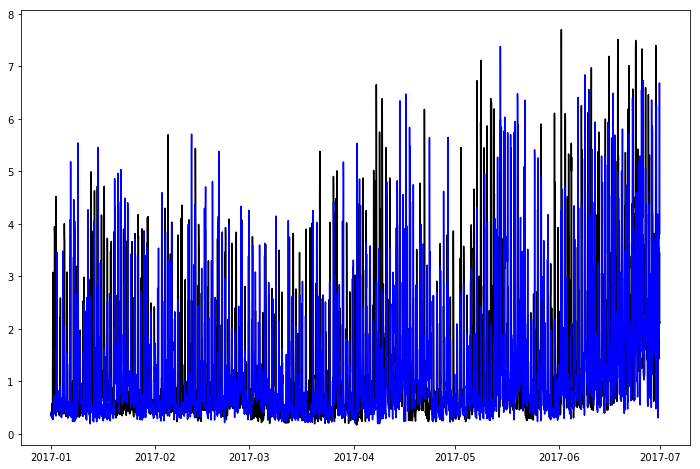

In [52]:
# plot train data real vs prediction for the whole testing period
fig = plt.figure(figsize=(12, 8))
start = '2017-01-01'
end = '2017-06-30'
plt.plot(data_test[start:end], color='black')
plt.plot(loadPred[start:end], color='blue')

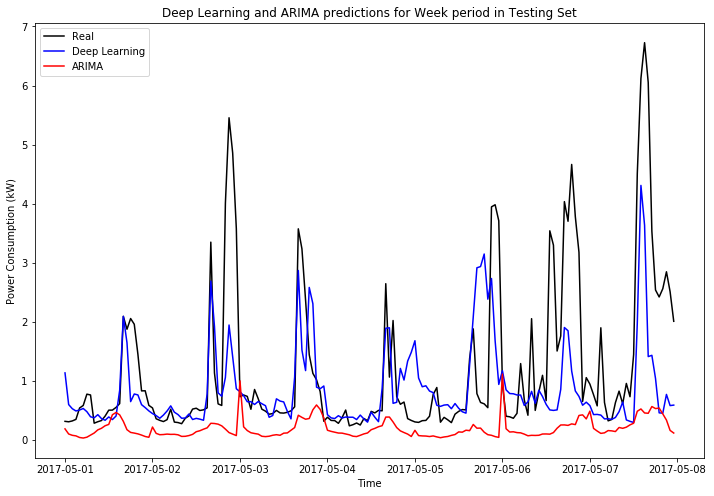

In [53]:
# plot train data real vs prediction for a week
fig = plt.figure(figsize=(12, 8))
start = '2017-05-01'
end = '2017-05-07'
plt.plot(data_test[start:end], color='black', label='Real')
plt.plot(loadPred[start:end], color='blue', label='Deep Learning')
plt.plot(test_pred[start:end], color='red', label='ARIMA')
plt.legend(loc='best')
plt.title('Deep Learning and ARIMA predictions for Week period in Testing Set')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.show()